# Redes Neurais para Processamento de Áudio

Este notebook abrange o uso de modelos de redes neurais para processamento de áudio, com foco em duas abordagens principais: `Wav2Vec`, `HuBERT`, `WAVLM`, `Whisper`.

## 1. Configurações Iniciais

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Instalação do SoX no Google Colab
!apt-get install sox libsox-dev libsox-fmt-all


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libao-common libao4 libid3tag0 libmad0 libopencore-amrnb0 libopencore-amrwb0 libsox-fmt-alsa
  libsox-fmt-ao libsox-fmt-base libsox-fmt-mp3 libsox-fmt-oss libsox-fmt-pulse libsox3 libwavpack1
Suggested packages:
  libaudio2 libsndio6.1
The following NEW packages will be installed:
  libao-common libao4 libid3tag0 libmad0 libopencore-amrnb0 libopencore-amrwb0 libsox-dev
  libsox-fmt-all libsox-fmt-alsa libsox-fmt-ao libsox-fmt-base libsox-fmt-mp3 libsox-fmt-oss
  libsox-fmt-pulse libsox3 libwavpack1 sox
0 upgraded, 17 newly installed, 0 to remove and 49 not upgraded.
Need to get 1,157 kB of archives.
After this operation, 4,262 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libao-common all 1.2.2+20180113-1.1ubuntu3 [6,568 B]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libao4

In [ ]:
# Importação de bibliotecas e configuração do ambiente
import os
import torch
import torchaudio
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import time
import random
import re
import seaborn as sns
import torchvision.models as models
import torch.optim as optim
import librosa
import io
import gc
import librosa
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from transformers import WhisperProcessor, WhisperModel
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from transformers import Wav2Vec2Model, Wav2Vec2Processor, HubertModel
from pathlib import Path
from collections import Counter
from torch.utils.data import ConcatDataset
from torch.nn.utils.rnn import pad_sequence
from transformers import Wav2Vec2Processor
from transformers import Wav2Vec2FeatureExtractor
from transformers import WavLMModel, Wav2Vec2Processor
from PIL import Image
from torchvision import transforms
from transformers import Wav2Vec2ForSequenceClassification, Wav2Vec2FeatureExtractor


# Definir dispositivo (GPU se disponível)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Dataset

### Carregamento e pré-processamento do dataset CREMA-D

In [ ]:
class CREMADataset(Dataset):
    def __init__(self, file_paths, labels, processor, sample_rate=16000):
        self.file_paths = file_paths
        self.labels = labels
        self.processor = processor
        self.sample_rate = sample_rate

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        label = self.labels[idx]

        # Carregar áudio
        waveform, sr = torchaudio.load(file_path)
        if sr != self.sample_rate:
            waveform = torchaudio.transforms.Resample(orig_freq=sr, new_freq=self.sample_rate)(waveform)

        waveform = waveform.squeeze(0)  # Remove a dimensão do canal (assumindo áudio mono)

        # Processar com o processor
        input_values = self.processor(waveform, sampling_rate=self.sample_rate, return_tensors="pt").input_values

        input_values = input_values.squeeze(0)  # Remove a dimensão do batch

        return input_values, label


In [ ]:
# Funções de aumento de dados
def pitch_shift(waveform, sample_rate, n_steps):
    effect = [['pitch', str(n_steps)], ['rate', str(sample_rate)]]
    waveform, _ = torchaudio.sox_effects.apply_effects_tensor(waveform, sample_rate, effect)
    return waveform

def add_noise(waveform, noise_factor=0.005):
    noise = torch.randn(waveform.size()) * noise_factor
    augmented_waveform = waveform + noise
    augmented_waveform = augmented_waveform.clamp(-1.0, 1.0)
    return augmented_waveform

def add_reverb(waveform, sample_rate):
    effect = [['reverb', '50', '50', '100']]
    augmented_waveform, _ = torchaudio.sox_effects.apply_effects_tensor(waveform, sample_rate, effect)

    # Verificar o número de canais
    if augmented_waveform.shape[0] > 1:
        # Converter para mono fazendo a média dos canais
        augmented_waveform = torch.mean(augmented_waveform, dim=0, keepdim=True)

    return augmented_waveform

def insert_silence(waveform, sample_rate, max_silence_length=0.5):
    silence_length = random.uniform(0, max_silence_length)
    silence_samples = int(silence_length * sample_rate)

    # Criar silêncio com o mesmo número de canais do waveform
    silence = torch.zeros(waveform.shape[0], silence_samples)

    # Concatenar ao longo da dimensão do tempo
    augmented_waveform = torch.cat((silence, waveform), dim=1)

    return augmented_waveform


In [ ]:
# Classe Dataset com aumento de dados "on-the-fly"
class AugmentedCREMADataset(Dataset):
    def __init__(self, file_paths, labels, processor, sample_rate=16000):
        self.file_paths = file_paths
        self.labels = labels
        self.processor = processor
        self.sample_rate = sample_rate

    def __len__(self):
        # Retorna o dobro do tamanho para incluir dados originais e aumentados
        return len(self.file_paths) * 2

    def __getitem__(self, idx):
        if idx < len(self.file_paths):
            # Dados originais
            file_path = self.file_paths[idx]
            label = self.labels[idx]

            # Carregar áudio
            waveform, sr = torchaudio.load(file_path)
            if sr != self.sample_rate:
                waveform = torchaudio.transforms.Resample(orig_freq=sr, new_freq=self.sample_rate)(waveform)

            waveform = waveform.squeeze(0)  # Remove a dimensão do canal (mono)

            # Processar com o processor
            inputs = self.processor(
            waveform,
            sampling_rate=self.sample_rate,
            return_tensors="pt"
            )
            input_values = inputs.input_values.squeeze(0)  # Remove a dimensão do batch

            return input_values, label
        else:
            # Dados aumentados
            # Ajustar índice para acessar o dado correspondente
            idx = idx - len(self.file_paths)
            file_path = self.file_paths[idx]
            label = self.labels[idx]

            # Carregar áudio
            waveform, sr = torchaudio.load(file_path)
            if sr != self.sample_rate:
                waveform = torchaudio.transforms.Resample(orig_freq=sr, new_freq=self.sample_rate)(waveform)

            waveform = waveform.squeeze(0)  # Remove a dimensão do canal (mono)

            # Aplicar aumento de dados
            waveform = self.apply_random_augmentation(waveform, sr)

            # Processar com o processor
            input_values = self.processor(waveform, sampling_rate=self.sample_rate, return_tensors="pt").input_values
            input_values = input_values.squeeze(0)  # Remove a dimensão do batch

            return input_values, label

    def apply_random_augmentation(self, waveform, sample_rate):
        # Escolha aleatória de uma técnica de aumento
        augmentation_methods = ['pitch_shift', 'add_noise', 'add_reverb', 'insert_silence']
        augmentation = random.choice(augmentation_methods)

        if augmentation == 'pitch_shift':
            n_steps = random.choice([-2, -1, 1, 2])  # Deslocamento de pitch
            augmented_waveform = pitch_shift(waveform.unsqueeze(0), sample_rate, n_steps).squeeze(0)
        elif augmentation == 'add_noise':
            noise_factor = random.uniform(0.001, 0.01)
            augmented_waveform = add_noise(waveform, noise_factor)
        elif augmentation == 'add_reverb':
            augmented_waveform = add_reverb(waveform.unsqueeze(0), sample_rate).squeeze(0)
        elif augmentation == 'insert_silence':
            max_silence_length = 0.5  # Em segundos
            augmented_waveform = insert_silence(waveform.unsqueeze(0), sample_rate, max_silence_length).squeeze(0)
        else:
            augmented_waveform = waveform  # Nenhuma alteração

        return augmented_waveform

### Função para carregar os arquivos e rótulos do CREMA-D

In [ ]:
def stretch_audio(audio_path, output_path, target_duration):
    # Carregar áudio em 16 kHz
    y, sr = librosa.load(audio_path, sr=16000)
    duration = librosa.get_duration(y=y, sr=sr)

    # Esticar se o áudio for menor que o target_duration
    if duration < target_duration:
        stretch_factor = target_duration / duration
        if stretch_factor > 2:  # Evitar estiramento excessivo
            print(f"Skipping excessive stretch for {audio_path}")
            return
        y_stretched = librosa.effects.time_stretch(y, stretch_factor)
        sf.write(output_path, y_stretched, sr)
    else:
        print(f"Audio {audio_path} already meets or exceeds target duration.")

def compress_audio(audio_path, output_path, target_duration):
    # Carregar áudio em 16 kHz
    y, sr = librosa.load(audio_path, sr=16000)
    duration = librosa.get_duration(y=y, sr=sr)

    # Comprimir se o áudio for maior que o target_duration
    if duration > target_duration:
        stretch_factor = duration / target_duration
        if stretch_factor > 2:  # Evitar compressão excessiva
            print(f"Skipping excessive compression for {audio_path}")
            return
        y_compressed = librosa.effects.time_stretch(y, stretch_factor)
        sf.write(output_path, y_compressed, sr)
    else:
        print(f"Audio {audio_path} already meets or is less than target duration.")

In [ ]:
def load_crema_d_data(data_dir):
    file_paths = []
    labels = []
    # Padrão de nome de arquivo esperado (ajuste conforme necessário)
    pattern = re.compile(r'(\w+)_(\w+)_(\w+)_.*\.wav$')

    for file_name in os.listdir(data_dir):
        if file_name.endswith(".wav"):
            match = pattern.match(file_name)
            if match:
                # Extraia o terceiro grupo como rótulo
                label = match.group(3)
                file_paths.append(os.path.join(data_dir, file_name))
                labels.append(label)
            else:
                print(f"Aviso: O arquivo '{file_name}' não corresponde ao padrão esperado e será ignorado.")
    return file_paths, labels

data_dir_cremaD = "/content/drive/MyDrive/testes_ML/CremaD"
data_dir_ravdess = "/content/drive/MyDrive/testes_ML/RAVDESS"
data_dir_tess = "/content/drive/MyDrive/testes_ML/TESS2"
#data_dir_frances = "/content/drive/MyDrive/testes_ML/Fran"
#data_dir_italiano = "/content/drive/MyDrive/testes_ML/EMOVO"
#data_dir_alemao = "/content/drive/MyDrive/testes_ML/EMODB"

file_paths, labels = load_crema_d_data(data_dir_cremaD)
file_paths2, labels2 = load_crema_d_data(data_dir_ravdess)
file_paths3, labels3 = load_crema_d_data(data_dir_tess)
#file_paths4, labels4 = load_crema_d_data(data_dir_frances)
#file_paths5, labels5 = load_crema_d_data(data_dir_italiano)
#file_paths6, labels6 = load_crema_d_data(data_dir_alemao)

file_paths = file_paths + file_paths2 + file_paths3 # + file_paths4 + file_paths5 + file_paths6
labels = labels + labels2 + labels3 #+ labels4 + labels5 + labels6



# Codificar os rótulos
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
# Criar o mapeamento de índices para labels
id2label = {idx: label for idx, label in enumerate(label_encoder.classes_)}

# Imprimir as labels e seus respectivos números associados
print("Mapeamento de labels para números:")
for idx, label in id2label.items():
    print(f"{idx}: {label}")


Mapeamento de labels para números:
0: ANG
1: DIS
2: FEA
3: HAP
4: NEU
5: SAD


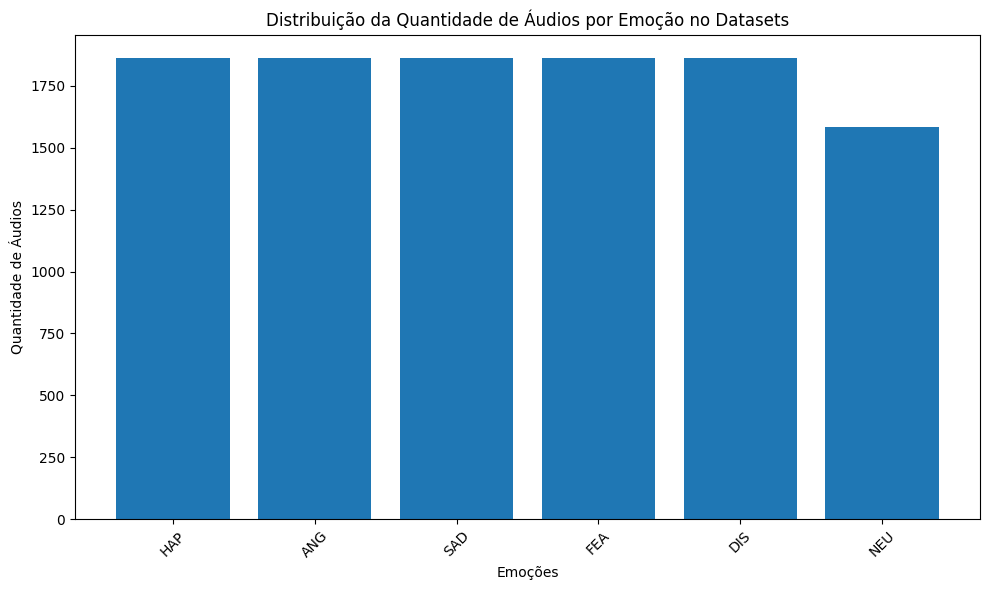

In [ ]:
# Contagem dos rótulos
label_counts = Counter(labels)

# Plotando o gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(label_counts.keys(), label_counts.values())
plt.xlabel('Emoções')
plt.ylabel('Quantidade de Áudios')
plt.title('Distribuição da Quantidade de Áudios por Emoção no Datasets')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Divisão dos dados em treino e teste

In [ ]:
# %% Divisão dos dados em treino e teste
train_files, test_files, train_labels, test_labels = train_test_split(
    file_paths, encoded_labels, test_size=0.2, random_state=42
)

# Divisão dos dados de treino em treino e validação
train_files, val_files, train_labels, val_labels = train_test_split(
    train_files, train_labels, test_size=0.25, random_state=42  # 0.25 de 80% resulta em 20% para validação
)


In [ ]:
# Calculando as quantidades de áudio para treino, validação e teste
train_count = len(train_files)
val_count = len(val_files)
test_count = len(test_files)

# Exibindo as quantidades
print(f"Quantidade de áudios de treino: {train_count}")
print(f"Quantidade de áudios de validação: {val_count}")
print(f"Quantidade de áudios de teste: {test_count}")

Quantidade de áudios de treino: 6538
Quantidade de áudios de validação: 2180
Quantidade de áudios de teste: 2180


In [ ]:
# %% Função de collate para preencher áudios de tamanhos diferentes
def collate_fn(batch):
    inputs = []
    labels = []

    for input_values, label in batch:
        #print(f"Forma do tensor de entrada: {input_values.shape}")
        inputs.append(input_values)
        labels.append(label)

    # Padronizar os tensores de entrada
    padded_inputs = pad_sequence(inputs, batch_first=True)

    labels_tensor = torch.tensor(labels)

    return padded_inputs, labels_tensor



## Wav2Vec

In [ ]:
# Wav2Vec2
wav2vec_processor = Wav2Vec2Processor.from_pretrained("audeering/wav2vec2-large-robust-12-ft-emotion-msp-dim")
wav2vec_model = Wav2Vec2Model.from_pretrained("audeering/wav2vec2-large-robust-12-ft-emotion-msp-dim").to(device)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of Wav2Vec2Model were not initialized from the model checkpoint at audeering/wav2vec2-large-robust-12-ft-emotion-msp-dim and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Definir o batch size
batch_size = 8

# Data loaders para cada modelo, usando a função de collate personalizada
train_loader_wav2vec = DataLoader(
    AugmentedCREMADataset(train_files, train_labels, wav2vec_processor),
    batch_size=batch_size, shuffle=True, collate_fn=collate_fn
)

val_loader_wav2vec = DataLoader(
    AugmentedCREMADataset(val_files, val_labels, wav2vec_processor),
    batch_size=batch_size, shuffle=False, collate_fn=collate_fn
)

test_loader_wav2vec = DataLoader(
    AugmentedCREMADataset(test_files, test_labels, wav2vec_processor),
    batch_size=batch_size, shuffle=False, collate_fn=collate_fn
)


In [ ]:
class Wav2VecClassifierWithRNN(nn.Module):
    def __init__(self, wav2vec_model, hidden_size=256, rnn_type='GRU'):
        super(Wav2VecClassifierWithRNN, self).__init__()
        self.wav2vec = wav2vec_model
        self.hidden_size = hidden_size

        # Use either LSTM or GRU based on rnn_type parameter
        if rnn_type == 'GRU':
            self.rnn = nn.GRU(input_size=wav2vec_model.config.hidden_size, hidden_size=hidden_size, batch_first=True)
        else:
            self.rnn = nn.LSTM(input_size=wav2vec_model.config.hidden_size, hidden_size=hidden_size, batch_first=True)

        # Classifier with a simple linear layer
        self.classifier = nn.Linear(hidden_size, 6)

    def forward(self, input_values):
        with torch.no_grad():
            hidden_states = self.wav2vec(input_values).last_hidden_state  # Shape: [batch_size, seq_len, hidden_size]

        # Pass through the RNN (LSTM or GRU)
        rnn_output, _ = self.rnn(hidden_states)  # Shape: [batch_size, seq_len, hidden_size]

        # Aggregate by taking the mean over the sequence length
        rnn_output = rnn_output.mean(dim=1)  # Shape: [batch_size, hidden_size]

        # Classify using the linear layer
        logits = self.classifier(rnn_output)
        return logits


In [ ]:
def train_model_with_rnn(
    model, train_loader, val_loader, epochs=50, learning_rate=1e-5, patience=5
):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    best_val_loss = np.inf
    patience_counter = 0

    model.train()
    for epoch in range(epochs):
        start_time = time.time()  # Início da medição do tempo

        # Treinamento
        model.train()
        total_train_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)

        # Validação
        model.eval()
        total_val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass
                outputs = model(inputs)
                val_loss = criterion(outputs, labels)

                total_val_loss += val_loss.item()

        avg_val_loss = total_val_loss / len(val_loader)

        # Tempo decorrido
        elapsed_time = time.time() - start_time
        print(f"Epoch {epoch + 1}, Train Loss: {avg_train_loss}, Val Loss: {avg_val_loss}, Time: {elapsed_time:.2f} seconds")

        # Early Stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            # Salvar o melhor modelo (opcional)
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            patience_counter += 1
            print(f"No improvement in validation loss for {patience_counter} epochs.")

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch + 1}")
            break

    # Carregar o melhor modelo (opcional)
    model.load_state_dict(torch.load('best_model.pth'))
    return model




In [ ]:

# Criação do modelo e envio para o dispositivo (CPU ou GPU)
wav2vec_rnn_model = Wav2VecClassifierWithRNN(wav2vec_model, rnn_type='GRU').to(device)

# Treinamento com Early Stopping
trained_wav2vec_rnn = train_model_with_rnn(
    wav2vec_rnn_model,
    train_loader=train_loader_wav2vec,
    val_loader=val_loader_wav2vec,
    epochs=50,  # Ajuste o número de épocas conforme necessário
    learning_rate=1e-4,
    patience=3  # Define a paciência para o Early Stopping
)


Epoch 1, Train Loss: 1.4747646711933473, Val Loss: 1.3112464400143151, Time: 416.27 seconds
Epoch 2, Train Loss: 1.2600662992164933, Val Loss: 1.1563784810077729, Time: 417.89 seconds
Epoch 3, Train Loss: 1.1717420311889801, Val Loss: 1.0762147228295937, Time: 419.42 seconds
Epoch 4, Train Loss: 1.1262949400697313, Val Loss: 1.0427119604064696, Time: 418.54 seconds
Epoch 5, Train Loss: 1.0836924322503105, Val Loss: 0.9954206489685713, Time: 418.26 seconds
Epoch 6, Train Loss: 1.0581223512987208, Val Loss: 1.069836115549461, Time: 420.75 seconds
No improvement in validation loss for 1 epochs.
Epoch 7, Train Loss: 1.030934261389897, Val Loss: 1.068775475025177, Time: 416.59 seconds
No improvement in validation loss for 2 epochs.
Epoch 8, Train Loss: 1.0105326735450417, Val Loss: 1.0438875582358793, Time: 417.42 seconds
No improvement in validation loss for 3 epochs.
Early stopping at epoch 8


<ipython-input-101-c26aed612014>:65: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


In [ ]:
def evaluate_model_wav2vec(model, test_loader, label_encoder):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)  # inputs.shape: [batch_size, sequence_length]
            labels = labels.to(device)

            # Forward pass through the model
            logits = model(inputs)  # logits.shape: [batch_size, num_labels]
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calcular a acurácia
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"Accuracy: {accuracy:.4f}")

    # Gerar relatório de classificação
    target_names = label_encoder.classes_
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=target_names))

    # Calcular a matriz de confusão
    cm = confusion_matrix(all_labels, all_preds)

    # Plotar a matriz de confusão
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=target_names,
                yticklabels=target_names)
    plt.ylabel('Rótulo Verdadeiro')
    plt.xlabel('Previsão do Modelo')
    plt.title('Matriz de Confusão')
    plt.show()

    return accuracy

Accuracy: 0.6285

Classification Report:
              precision    recall  f1-score   support

         ANG       0.65      0.89      0.75       510
         DIS       0.69      0.46      0.55       528
         FEA       0.64      0.41      0.50       514
         HAP       0.69      0.63      0.66       446
         NEU       0.68      0.72      0.70       482
         SAD       0.50      0.67      0.57       500

    accuracy                           0.63      2980
   macro avg       0.64      0.63      0.62      2980
weighted avg       0.64      0.63      0.62      2980



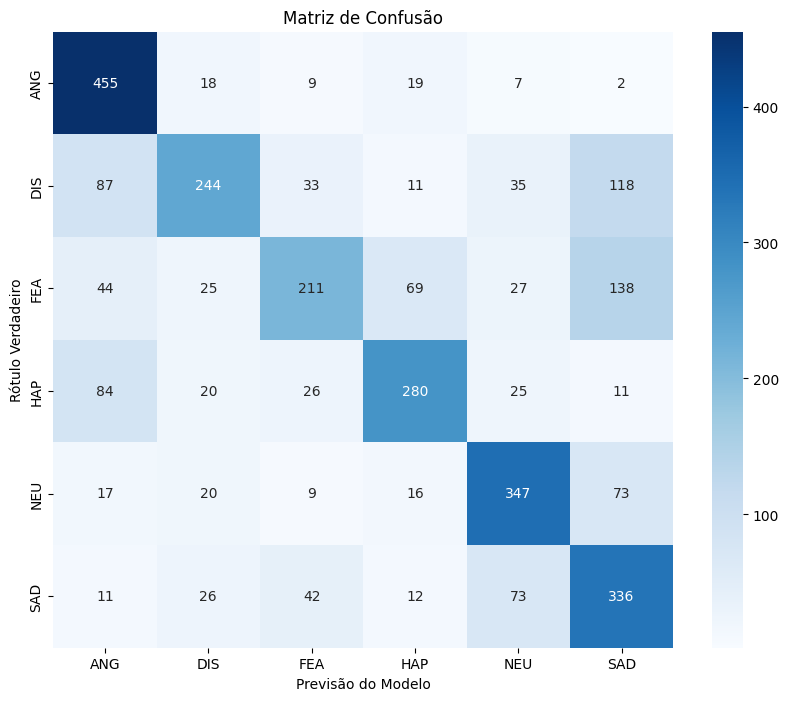

Wav2Vec2 with GRU Accuracy: 0.6285
Modelo e acurácia salvos em 'wav2vec_rnn_model.pt'


In [ ]:
# Evaluate the trained model
wav2vec_rnn_accuracy = evaluate_model_wav2vec(trained_wav2vec_rnn, test_loader_wav2vec, label_encoder)
print(f"Wav2Vec2 with GRU Accuracy: {wav2vec_rnn_accuracy:.4f}")

# Salvar os pesos do modelo e a acurácia de teste
torch.save({
    'model_state_dict': trained_wav2vec_rnn.state_dict(),
    'test_accuracy': wav2vec_rnn_accuracy,
    'model_architecture': {
        'hidden_size': 256,  # Ou o valor que você utilizou
        'rnn_type': 'GRU'
    }
}, 'wav2vec_rnn_model.pt')

print("Modelo e acurácia salvos em 'wav2vec_rnn_model.pt'")

## Hubert

In [ ]:
# HuBERT
hubert_model = HubertModel.from_pretrained("facebook/hubert-base-ls960").to(device)

feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained('facebook/hubert-base-ls960')

Some weights of the model checkpoint at superb/wav2vec2-base-superb-er were not used when initializing Wav2Vec2ForSequenceClassification: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at superb/wav2vec2-base-superb-er and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_em

In [ ]:
# Definir o batch size
batch_size = 128

# Data loaders para HuBERT, sem o processador
train_loader_hubert = DataLoader(
    AugmentedCREMADataset(train_files, train_labels, processor=feature_extractor),  # Removido o processor
    batch_size=batch_size, shuffle=True, collate_fn=collate_fn
)

val_loader_hubert = DataLoader(
    AugmentedCREMADataset(val_files, val_labels, processor=feature_extractor),  # Removido o processor
    batch_size=batch_size, shuffle=False, collate_fn=collate_fn
)

test_loader_hubert = DataLoader(
    AugmentedCREMADataset(test_files, test_labels, processor=feature_extractor),  # Removido o processor
    batch_size=batch_size, shuffle=False, collate_fn=collate_fn
)

In [ ]:
def train_model_with_rnn(
    model, train_loader, val_loader, epochs=50, learning_rate=1e-5, patience=5
):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    best_val_loss = np.inf
    patience_counter = 0

    model.train()
    for epoch in range(epochs):
        start_time = time.time()  # Início da medição do tempo

        # Treinamento
        model.train()
        total_train_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)

        # Validação
        model.eval()
        total_val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass
                outputs = model(inputs)
                val_loss = criterion(outputs, labels)

                total_val_loss += val_loss.item()

        avg_val_loss = total_val_loss / len(val_loader)

        # Tempo decorrido
        elapsed_time = time.time() - start_time
        print(f"Epoch {epoch + 1}, Train Loss: {avg_train_loss}, Val Loss: {avg_val_loss}, Time: {elapsed_time:.2f} seconds")

        # Early Stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            # Salvar o melhor modelo (opcional)
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            patience_counter += 1
            print(f"No improvement in validation loss for {patience_counter} epochs.")

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch + 1}")
            break

    # Carregar o melhor modelo (opcional)
    model.load_state_dict(torch.load('best_model.pth'))
    return model




In [ ]:
# Criação do modelo e envio para o dispositivo (CPU ou GPU)
hubert_rnn_model = HubertClassifierWithRNN(hubert_model, rnn_type='GRU').to(device)

# Treinamento com Early Stopping para o modelo HuBERT
trained_hubert_rnn = train_model_with_rnn(
    hubert_rnn_model,
    train_loader=train_loader_hubert,
    val_loader=val_loader_hubert,
    epochs=50,  # Ajuste o número de épocas conforme necessário
    learning_rate=1e-4,
    patience=3  # Define a paciência para o Early Stopping
)




/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:92: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


AttributeError: 'SequenceClassifierOutput' object has no attribute 'last_hidden_state'

In [ ]:
def evaluate_model_hubert(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)  # inputs.shape: [batch_size, sequence_length]
            labels = labels.to(device)

            # Forward pass through the model
            logits = model(inputs)  # logits.shape: [batch_size, num_labels]
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    print(f"Accuracy: {accuracy:.4f}")
    return accuracy

In [ ]:
# Avaliar o modelo HuBERT treinado
hubert_rnn_accuracy = evaluate_model_hubert(trained_hubert_rnn, test_loader_hubert)
print(f"HuBERT with GRU Accuracy: {hubert_rnn_accuracy:.4f}")

# Salvar os pesos do modelo e a acurácia de teste
torch.save({
    'model_state_dict': trained_hubert_rnn.state_dict(),
    'test_accuracy': hubert_rnn_accuracy,
    'model_architecture': {
        'hidden_size': 256,  # Ou o valor que você utilizou no modelo HuBERT
        'rnn_type': 'GRU'
    }
}, 'hubert_rnn_model2.pt')

print("Modelo e acurácia salvos em 'hubert_rnn_model.pt'")

Accuracy: 0.6664
HuBERT with GRU Accuracy: 0.6664
Modelo e acurácia salvos em 'hubert_rnn_model.pt'


## WavLm

In [ ]:
# Carregue o modelo WavLM Large+ (modelo mais robusto)
wavlm_model = WavLMModel.from_pretrained("microsoft/wavlm-large")

# Use o Wav2Vec2FeatureExtractor para preparar o áudio
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("microsoft/wavlm-large")

config.json:   0%|          | 0.00/2.24k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/378M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/wavlm-base were not used when initializing WavLMModel: ['encoder.pos_conv_embed.conv.weight_g', 'encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing WavLMModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing WavLMModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of WavLMModel were not initialized from the model checkpoint at microsoft/wavlm-base and are newly initialized: ['encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inf

In [ ]:
batch_size=16

# Data loaders para cada modelo, usando a função de collate personalizada (ajustada para WavLM)
train_loader_wavlm = DataLoader(
    AugmentedCREMADataset(train_files, train_labels, feature_extractor),
    batch_size=batch_size, shuffle=True, collate_fn=collate_fn
)

val_loader_wavlm = DataLoader(
    AugmentedCREMADataset(val_files, val_labels, feature_extractor),
    batch_size=batch_size, shuffle=False, collate_fn=collate_fn
)

test_loader_wavlm = DataLoader(
    AugmentedCREMADataset(test_files, test_labels, feature_extractor),
    batch_size=batch_size, shuffle=False, collate_fn=collate_fn
)

In [ ]:
class WavLMClassifierWithRNN(nn.Module):
    def __init__(self, wavlm_model, hidden_size=256, rnn_type='GRU'):
        super(WavLMClassifierWithRNN, self).__init__()
        self.wavlm = wavlm_model
        self.hidden_size = hidden_size

        # Defina a RNN
        if rnn_type == 'GRU':
            self.rnn = nn.GRU(input_size=wavlm_model.config.hidden_size, hidden_size=hidden_size, batch_first=True)
        else:
            self.rnn = nn.LSTM(input_size=wavlm_model.config.hidden_size, hidden_size=hidden_size, batch_first=True)

        # Camada de classificação
        self.classifier = nn.Linear(hidden_size, 6)  # Supondo 6 classes

    def forward(self, input_values):
        # Obter os hidden states do WavLMModel
        with torch.no_grad():
            outputs = self.wavlm(input_values)
            hidden_states = outputs.last_hidden_state  # Atributo correto para WavLMModel

        # Passar pela RNN
        rnn_output, _ = self.rnn(hidden_states)

        # Agregar (por exemplo, média)
        rnn_output = rnn_output.mean(dim=1)

        # Classificar
        logits = self.classifier(rnn_output)
        return logits



In [ ]:
# Função de treinamento adaptada (idêntica à sua função original)
def train_model_with_rnn(
    model, train_loader, val_loader, epochs=50, learning_rate=1e-5, patience=5
):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    best_val_loss = np.inf
    patience_counter = 0

    model.train()
    for epoch in range(epochs):
        start_time = time.time()  # Início da medição do tempo

        # Treinamento
        model.train()
        total_train_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)

        # Validação
        model.eval()
        total_val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass
                outputs = model(inputs)
                val_loss = criterion(outputs, labels)

                total_val_loss += val_loss.item()

        avg_val_loss = total_val_loss / len(val_loader)

        # Tempo decorrido
        elapsed_time = time.time() - start_time
        print(f"Epoch {epoch + 1}, Train Loss: {avg_train_loss}, Val Loss: {avg_val_loss}, Time: {elapsed_time:.2f} seconds")

        # Early Stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            # Salvar o melhor modelo (opcional)
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            patience_counter += 1
            print(f"No improvement in validation loss for {patience_counter} epochs.")

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch + 1}")
            break

    # Carregar o melhor modelo (opcional)
    model.load_state_dict(torch.load('best_model.pth'))
    return model

In [ ]:
# Criação do modelo WavLM com RNN e envio para o dispositivo (CPU ou GPU)
wavlm_rnn_model = WavLMClassifierWithRNN(wavlm_model, rnn_type='GRU').to(device)

# Treinamento com Early Stopping
trained_wavlm_rnn = train_model_with_rnn(
    wavlm_rnn_model,
    train_loader=train_loader_wavlm,
    val_loader=val_loader_wavlm,
    epochs=50,  # Ajuste o número de épocas conforme necessário
    learning_rate=1e-4,
    patience=3  # Define a paciência para o Early Stopping
)

Epoch 1, Train Loss: 1.5343158006241582, Val Loss: 1.379964535886591, Time: 2814.66 seconds
Epoch 2, Train Loss: 1.2666777224148322, Val Loss: 1.1949284169125685, Time: 328.62 seconds
Epoch 3, Train Loss: 1.1258270976155302, Val Loss: 1.1367626808543894, Time: 328.83 seconds
Epoch 4, Train Loss: 1.0462931393510753, Val Loss: 1.048493890838827, Time: 327.72 seconds
Epoch 5, Train Loss: 0.9899809146716471, Val Loss: 1.0332953646221263, Time: 330.37 seconds
Epoch 6, Train Loss: 0.9549565903295985, Val Loss: 1.0080272171267852, Time: 327.36 seconds
Epoch 7, Train Loss: 0.9224605475534053, Val Loss: 0.9892046053141834, Time: 328.21 seconds
Epoch 8, Train Loss: 0.8944338840000958, Val Loss: 1.0086547182524268, Time: 329.18 seconds
No improvement in validation loss for 1 epochs.
Epoch 9, Train Loss: 0.8599582278237999, Val Loss: 0.9962045892993396, Time: 328.09 seconds
No improvement in validation loss for 2 epochs.
Epoch 10, Train Loss: 0.8383551502003866, Val Loss: 0.9570173751861654, Time:

<ipython-input-41-3717a9a82c86>:66: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


In [ ]:
# Função de avaliação adaptada (mesma lógica usada no Wav2Vec)
def evaluate_model_wavlm(model, test_loader, label_encoder):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)  # inputs.shape: [batch_size, sequence_length]
            labels = labels.to(device)

            # Forward pass through the model
            logits = model(inputs)  # logits.shape: [batch_size, num_labels]
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calcular a acurácia
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"Accuracy: {accuracy:.4f}")

    # Gerar relatório de classificação
    target_names = label_encoder.classes_
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=target_names))

    # Calcular a matriz de confusão
    cm = confusion_matrix(all_labels, all_preds)

    # Plotar a matriz de confusão
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=target_names,
                yticklabels=target_names)
    plt.ylabel('Rótulo Verdadeiro')
    plt.xlabel('Previsão do Modelo')
    plt.title('Matriz de Confusão')
    plt.show()

    return accuracy

Accuracy: 0.6889

Classification Report:
              precision    recall  f1-score   support

         ANG       0.72      0.87      0.79       510
         DIS       0.69      0.60      0.65       530
         FEA       0.64      0.64      0.64       494
         HAP       0.70      0.65      0.68       474
         NEU       0.66      0.82      0.73       426
         SAD       0.70      0.58      0.64       546

    accuracy                           0.69      2980
   macro avg       0.69      0.69      0.69      2980
weighted avg       0.69      0.69      0.68      2980



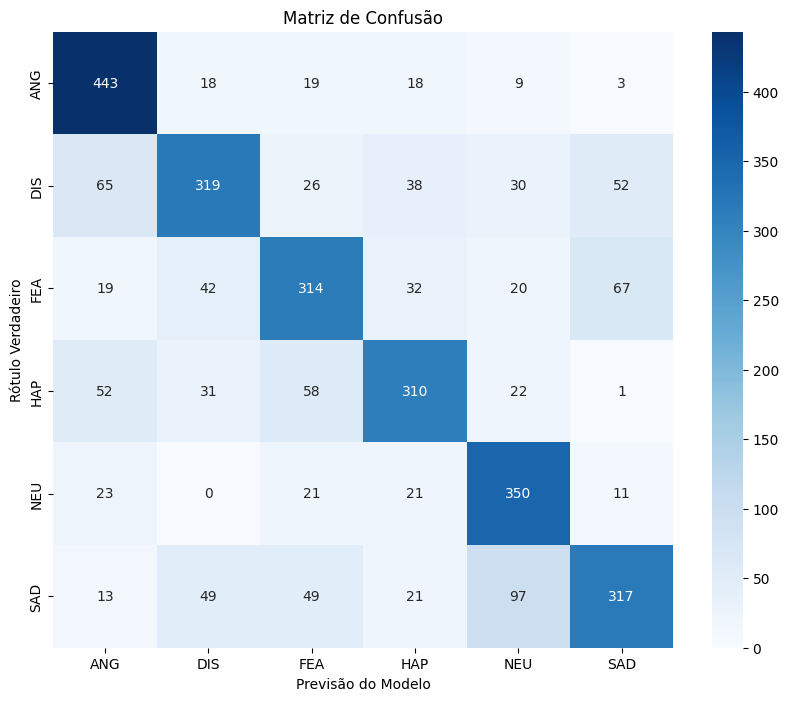

WavLM with GRU Accuracy: 0.6889
Modelo e acurácia salvos em 'wavlm_rnn_model.pt'


In [ ]:
# Avaliar o modelo treinado
wavlm_rnn_accuracy = evaluate_model_wavlm(trained_wavlm_rnn, test_loader_wavlm, label_encoder)
print(f"WavLM with GRU Accuracy: {wavlm_rnn_accuracy:.4f}")

# Salvar os pesos do modelo e a acurácia de teste
torch.save({
    'model_state_dict': trained_wavlm_rnn.state_dict(),
    'test_accuracy': wavlm_rnn_accuracy,
    'model_architecture': {
        'hidden_size': 256,  # Ou o valor que você utilizou
        'rnn_type': 'GRU'
    }
}, 'wavlm_rnn_model.pt')

print("Modelo e acurácia salvos em 'wavlm_rnn_model.pt'")

## Whisper Large

In [ ]:
# Classe Dataset com aumento de dados "on-the-fly"
class AugmentedCREMADataset(Dataset):
    def __init__(self, file_paths, labels, processor, sample_rate=16000):
        self.file_paths = file_paths
        self.labels = labels
        self.processor = processor  # Pode ser removido se não for usado
        self.sample_rate = sample_rate

    def __len__(self):
        # Retorna o dobro do tamanho para incluir dados originais e aumentados
        return len(self.file_paths) * 2

    def __getitem__(self, idx):
        if idx < len(self.file_paths):
            # Dados originais
            file_path = self.file_paths[idx]
            label = self.labels[idx]

            # Carregar áudio
            waveform, sr = torchaudio.load(file_path)
            if sr != self.sample_rate:
                waveform = torchaudio.transforms.Resample(orig_freq=sr, new_freq=self.sample_rate)(waveform)

            waveform = waveform.squeeze(0)  # Remove a dimensão extra (mono)

            # Retorna o waveform bruto e o label
            return waveform, label
        else:
            # Dados aumentados
            idx = idx - len(self.file_paths)
            file_path = self.file_paths[idx]
            label = self.labels[idx]

            # Carregar áudio
            waveform, sr = torchaudio.load(file_path)
            if sr != self.sample_rate:
                waveform = torchaudio.transforms.Resample(orig_freq=sr, new_freq=self.sample_rate)(waveform)

            waveform = waveform.squeeze(0)  # Remove a dimensão extra (mono)

            # Aplicar aumento de dados
            waveform = self.apply_random_augmentation(waveform, self.sample_rate)

            # Retorna o waveform aumentado e o label
            return waveform, label

    def apply_random_augmentation(self, waveform, sample_rate):
        # Escolha aleatória de uma técnica de aumento
        augmentation_methods = ['pitch_shift', 'add_noise', 'add_reverb', 'insert_silence']
        augmentation = random.choice(augmentation_methods)

        if augmentation == 'pitch_shift':
            n_steps = random.choice([-2, -1, 1, 2])  # Deslocamento de pitch
            augmented_waveform = pitch_shift(waveform.unsqueeze(0), sample_rate, n_steps).squeeze(0)
        elif augmentation == 'add_noise':
            noise_factor = random.uniform(0.001, 0.01)
            augmented_waveform = add_noise(waveform, noise_factor)
        elif augmentation == 'add_reverb':
            augmented_waveform = add_reverb(waveform.unsqueeze(0), sample_rate).squeeze(0)
        elif augmentation == 'insert_silence':
            max_silence_length = 0.5  # Em segundos
            augmented_waveform = insert_silence(waveform.unsqueeze(0), sample_rate, max_silence_length).squeeze(0)
        else:
            augmented_waveform = waveform  # Nenhuma alteração

        return augmented_waveform



In [ ]:
def collate_fn(batch):
    waveforms = [item[0] for item in batch]  # Lista de tensores PyTorch
    labels = [item[1] for item in batch]

    # Converter os waveforms para listas de numpy arrays
    waveforms = [waveform.numpy() for waveform in waveforms]

    # Processar usando o WhisperProcessor
    inputs = whisper_processor(
        waveforms,
        sampling_rate=16000,
        return_tensors="pt",
    )

    input_features = inputs.input_features  # Shape: [batch_size, num_mel_bins, seq_len]

    # Padronizar as input features para comprimento 3000 na dimensão temporal
    processed_inputs = []
    for feature in input_features:
        seq_len = feature.shape[1]
        if seq_len < 3000:
            # Pad com zeros até atingir 3000 frames
            pad_length = 3000 - seq_len
            padded_feature = torch.nn.functional.pad(feature, (0, pad_length), "constant", 0)
        elif seq_len > 3000:
            # Truncar para 3000 frames
            padded_feature = feature[:, :3000]
        else:
            padded_feature = feature  # Já tem comprimento 3000
        processed_inputs.append(padded_feature)

    # Empilhar as input features padronizadas
    processed_inputs = torch.stack(processed_inputs)

    # Verificar que as input features agora têm comprimento 3000
    #print(f"Input features shape after padding: {processed_inputs.shape}")  # Deve ser [batch_size, 80, 3000]

    labels = torch.tensor(labels)

    return processed_inputs, labels




In [ ]:
# Carregar o modelo Whisper pré-treinado
whisper_processor = WhisperProcessor.from_pretrained("openai/whisper-large-v3")
whisper_model = WhisperModel.from_pretrained("openai/whisper-large-v3").to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/340 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/283k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.48M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/494k [00:00<?, ?B/s]

normalizer.json:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.07k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.27k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.09G [00:00<?, ?B/s]

In [ ]:
# Definir o batch size
batch_size = 128

# Data loaders para o Whisper, usando a função de collate personalizada
train_loader_whisper = DataLoader(
    AugmentedCREMADataset(train_files, train_labels, whisper_processor),
    batch_size=batch_size, shuffle=True, collate_fn=collate_fn, num_workers=0, pin_memory=True
)

val_loader_whisper = DataLoader(
    AugmentedCREMADataset(val_files, val_labels, whisper_processor),
    batch_size=batch_size, shuffle=False, collate_fn=collate_fn, num_workers=0, pin_memory=True
)

test_loader_whisper = DataLoader(
    AugmentedCREMADataset(test_files, test_labels, whisper_processor),
    batch_size=batch_size, shuffle=False, collate_fn=collate_fn, num_workers=0, pin_memory=True
)


In [ ]:

# Definir o classificador baseado no Whisper com RNN
class WhisperClassifierWithRNN(nn.Module):
    def __init__(self, whisper_model, hidden_size=256, rnn_type='GRU'):
        super(WhisperClassifierWithRNN, self).__init__()
        self.whisper = whisper_model
        self.hidden_size = hidden_size

        # Use either LSTM or GRU based on rnn_type parameter
        if rnn_type == 'GRU':
            self.rnn = nn.GRU(input_size=whisper_model.config.d_model, hidden_size=hidden_size, batch_first=True)
        else:
            self.rnn = nn.LSTM(input_size=whisper_model.config.d_model, hidden_size=hidden_size, batch_first=True)

        # Classificador com uma camada linear simples
        self.classifier = nn.Linear(hidden_size, 6)

    def forward(self, input_features):
        with torch.no_grad():
            # Use apenas o encoder do modelo Whisper
            encoder_outputs = self.whisper.encoder(input_features)
            hidden_states = encoder_outputs.last_hidden_state  # Shape: [batch_size, seq_len, hidden_size]

        # Passar pelo RNN (LSTM ou GRU)
        rnn_output, _ = self.rnn(hidden_states)  # Shape: [batch_size, seq_len, hidden_size]

        # Agregar tirando a média ao longo do comprimento da sequência
        rnn_output = rnn_output.mean(dim=1)  # Shape: [batch_size, hidden_size]

        # Classificar usando a camada linear
        logits = self.classifier(rnn_output)
        return logits


In [ ]:
# Treinamento semelhante ao modelo Wav2Vec2
def train_model_with_rnn(
    model, train_loader, val_loader, epochs=50, learning_rate=1e-5, patience=5
):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    best_val_loss = np.inf
    patience_counter = 0

    model.train()
    for epoch in range(epochs):
        start_time = time.time()  # Início da medição do tempo

        # Treinamento
        model.train()
        total_train_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)

        # Validação
        model.eval()
        total_val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass
                outputs = model(inputs)
                val_loss = criterion(outputs, labels)

                total_val_loss += val_loss.item()

        avg_val_loss = total_val_loss / len(val_loader)

        # Tempo decorrido
        elapsed_time = time.time() - start_time
        print(f"Epoch {epoch + 1}, Train Loss: {avg_train_loss}, Val Loss: {avg_val_loss}, Time: {elapsed_time:.2f} seconds")

        # Early Stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            # Salvar o melhor modelo (opcional)
            torch.save(model.state_dict(), 'best_whisper_model.pth')
        else:
            patience_counter += 1
            print(f"No improvement in validation loss for {patience_counter} epochs.")

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch + 1}")
            break

        # Limpar memória após cada epoch
        gc.collect()  # Libera memória que não está mais em uso
        torch.cuda.empty_cache()  # Libera a memória da GPU (opcional)


    # Carregar o melhor modelo (opcional)
    model.load_state_dict(torch.load('best_whisper_model.pth'))
    return model

In [ ]:
# Criação do modelo e envio para o dispositivo (CPU ou GPU)
whisper_rnn_model = WhisperClassifierWithRNN(whisper_model, rnn_type='GRU').to(device)

# Treinamento com Early Stopping
trained_whisper_rnn = train_model_with_rnn(
    whisper_rnn_model,
    train_loader=train_loader_whisper,
    val_loader=val_loader_whisper,
    epochs=100,
    learning_rate=1e-4,
    patience=3
)


Epoch 1, Train Loss: 1.7733522098041274, Val Loss: 1.7402272258486067, Time: 4464.78 seconds
Epoch 2, Train Loss: 1.6291127066010411, Val Loss: 1.413420329775129, Time: 2544.78 seconds
Epoch 3, Train Loss: 1.2535020494924007, Val Loss: 1.0793114287512644, Time: 2542.51 seconds
Epoch 4, Train Loss: 0.9812433650192706, Val Loss: 0.951795300415584, Time: 2546.71 seconds
Epoch 5, Train Loss: 0.8488626075022428, Val Loss: 0.7977810689381191, Time: 2543.37 seconds
Epoch 6, Train Loss: 0.7568685076769116, Val Loss: 0.7218199380806514, Time: 2541.56 seconds
Epoch 7, Train Loss: 0.6896792927991997, Val Loss: 0.661060677255903, Time: 2544.86 seconds
Epoch 8, Train Loss: 0.6484819453896828, Val Loss: 0.6534487622124808, Time: 2543.57 seconds
Epoch 9, Train Loss: 0.6069791013176001, Val Loss: 0.6021514500890459, Time: 2543.46 seconds
Epoch 10, Train Loss: 0.5681197090635022, Val Loss: 0.651087088244302, Time: 2543.67 seconds
No improvement in validation loss for 1 epochs.
Epoch 11, Train Loss: 0.5

<ipython-input-18-6dc9878105b7>:71: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_whisper_model.pth'))


In [ ]:
# Função de avaliação do modelo Whisper
def evaluate_model_whisper(model, test_loader, label_encoder):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)  # inputs.shape: [batch_size, sequence_length]
            labels = labels.to(device)

            # Forward pass através do modelo
            logits = model(inputs)  # logits.shape: [batch_size, num_labels]
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calcular a acurácia
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"Accuracy: {accuracy:.4f}")

    # Gerar relatório de classificação
    target_names = label_encoder.classes_
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=target_names))

    # Calcular a matriz de confusão
    cm = confusion_matrix(all_labels, all_preds)

    # Plotar a matriz de confusão
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=target_names,
                yticklabels=target_names)
    plt.ylabel('Rótulo Verdadeiro')
    plt.xlabel('Previsão do Modelo')
    plt.title('Matriz de Confusão')
    plt.show()

    return accuracy

Accuracy: 0.8117

Classification Report:
              precision    recall  f1-score   support

         ANG       0.89      0.89      0.89       788
         DIS       0.86      0.71      0.78       748
         FEA       0.77      0.76      0.76       772
         HAP       0.79      0.88      0.83       698
         NEU       0.83      0.94      0.88       640
         SAD       0.74      0.70      0.72       714

    accuracy                           0.81      4360
   macro avg       0.81      0.81      0.81      4360
weighted avg       0.81      0.81      0.81      4360



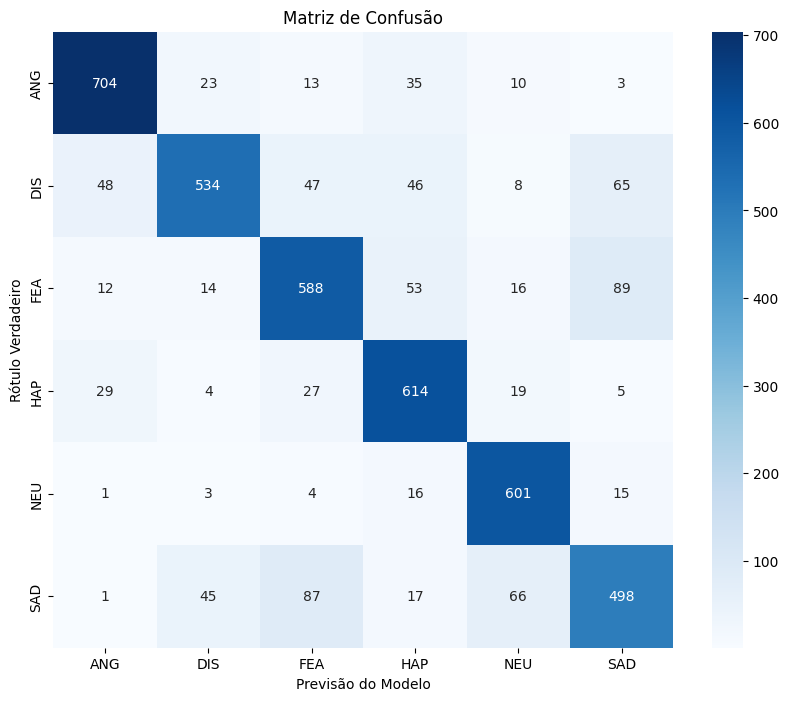

Whisper with GRU Accuracy: 0.8117


In [ ]:
# Avaliação do modelo treinado
whisper_rnn_accuracy = evaluate_model_whisper(trained_whisper_rnn, test_loader_whisper, label_encoder)
print(f"Whisper with GRU Accuracy: {whisper_rnn_accuracy:.4f}")

In [ ]:
# Salvar os pesos do modelo e a acurácia de teste
torch.save({
    'model_state_dict': trained_whisper_rnn.state_dict(),
    'test_accuracy': whisper_rnn_accuracy,
    'model_architecture': {
        'hidden_size': 256,  # Ou o valor que você utilizou
        'rnn_type': 'GRU'
    }
}, 'whisper_large4_rnn_model.pt')

print("Modelo e acurácia salvos em 'whisper_large4_rnn_model.pt'")

Modelo e acurácia salvos em 'whisper_large4_rnn_model.pt'


In [ ]:
!cp /content/whisper_large4_rnn_model.pt /content/drive/MyDrive/testes_ML/Modelos_treinados

## Whisper Medium

Número total de arquivos de áudio: 7446
Duração máxima: 5.00 segundos
Duração média: 2.54 segundos
Duração mínima: 1.27 segundos


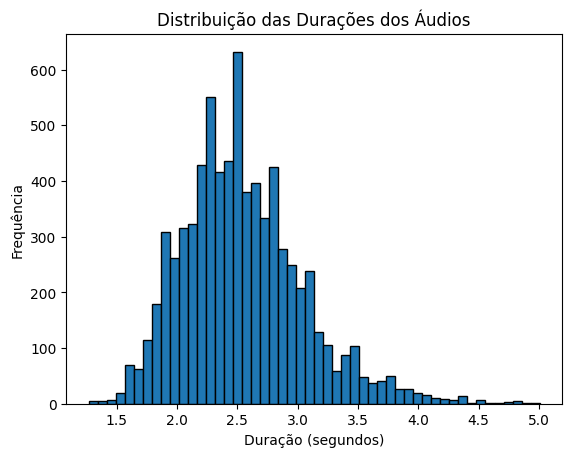

In [ ]:
def analyze_audio_durations(folder_path, sample_rate=16000):
    max_duration = 0.0
    total_duration = 0.0
    durations = []
    file_count = 0

    # Percorrer todos os arquivos na pasta especificada
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith('.wav'):  # Considere apenas arquivos WAV (ajuste conforme necessário)
                file_path = os.path.join(root, file)
                waveform, sr = torchaudio.load(file_path)
                if sr != sample_rate:
                    # Opcional: Resample para a taxa de amostragem desejada
                    resampler = torchaudio.transforms.Resample(orig_freq=sr, new_freq=sample_rate)
                    waveform = resampler(waveform)
                    sr = sample_rate
                # Calcular a duração em segundos
                duration = waveform.shape[1] / sr
                durations.append(duration)
                total_duration += duration
                file_count += 1
                if duration > max_duration:
                    max_duration = duration

    if file_count == 0:
        print("Nenhum arquivo de áudio encontrado na pasta especificada.")
        return

    average_duration = total_duration / file_count
    print(f"Número total de arquivos de áudio: {file_count}")
    print(f"Duração máxima: {max_duration:.2f} segundos")
    print(f"Duração média: {average_duration:.2f} segundos")
    print(f"Duração mínima: {min(durations):.2f} segundos")

    # Opcional: Exibir um histograma das durações
    import matplotlib.pyplot as plt
    plt.hist(durations, bins=50, edgecolor='black')
    plt.xlabel('Duração (segundos)')
    plt.ylabel('Frequência')
    plt.title('Distribuição das Durações dos Áudios')
    plt.show()

# Exemplo de uso:
folder_path = '/content/drive/MyDrive/testes_ML/CremaD'  # Substitua pelo caminho da sua pasta
analyze_audio_durations(folder_path)


In [ ]:
# Classe Dataset com aumento de dados "on-the-fly"
class AugmentedCREMADataset(Dataset):
    def __init__(self, file_paths, labels, processor, sample_rate=16000):
        self.file_paths = file_paths
        self.labels = labels
        self.processor = processor  # Pode ser removido se não for usado
        self.sample_rate = sample_rate

    def __len__(self):
        # Retorna o dobro do tamanho para incluir dados originais e aumentados
        return len(self.file_paths) * 2

    def __getitem__(self, idx):
        if idx < len(self.file_paths):
            # Dados originais
            file_path = self.file_paths[idx]
            label = self.labels[idx]

            # Carregar áudio
            waveform, sr = torchaudio.load(file_path)
            if sr != self.sample_rate:
                waveform = torchaudio.transforms.Resample(orig_freq=sr, new_freq=self.sample_rate)(waveform)

            waveform = waveform.squeeze(0)  # Remove a dimensão extra (mono)

            # Retorna o waveform bruto e o label
            return waveform, label
        else:
            # Dados aumentados
            idx = idx - len(self.file_paths)
            file_path = self.file_paths[idx]
            label = self.labels[idx]

            # Carregar áudio
            waveform, sr = torchaudio.load(file_path)
            if sr != self.sample_rate:
                waveform = torchaudio.transforms.Resample(orig_freq=sr, new_freq=self.sample_rate)(waveform)

            waveform = waveform.squeeze(0)  # Remove a dimensão extra (mono)

            # Aplicar aumento de dados
            waveform = self.apply_random_augmentation(waveform, self.sample_rate)

            # Retorna o waveform aumentado e o label
            return waveform, label

    def apply_random_augmentation(self, waveform, sample_rate):
        # Escolha aleatória de uma técnica de aumento
        augmentation_methods = ['pitch_shift', 'add_noise', 'add_reverb', 'insert_silence']
        augmentation = random.choice(augmentation_methods)

        if augmentation == 'pitch_shift':
            n_steps = random.choice([-2, -1, 1, 2])  # Deslocamento de pitch
            augmented_waveform = pitch_shift(waveform.unsqueeze(0), sample_rate, n_steps).squeeze(0)
        elif augmentation == 'add_noise':
            noise_factor = random.uniform(0.001, 0.01)
            augmented_waveform = add_noise(waveform, noise_factor)
        elif augmentation == 'add_reverb':
            augmented_waveform = add_reverb(waveform.unsqueeze(0), sample_rate).squeeze(0)
        elif augmentation == 'insert_silence':
            max_silence_length = 0.5  # Em segundos
            augmented_waveform = insert_silence(waveform.unsqueeze(0), sample_rate, max_silence_length).squeeze(0)
        else:
            augmented_waveform = waveform  # Nenhuma alteração

        return augmented_waveform



In [ ]:
def collate_fn(batch):
    waveforms = [item[0] for item in batch]  # Lista de tensores PyTorch
    labels = [item[1] for item in batch]

    # Converter os waveforms para listas de numpy arrays
    waveforms = [waveform.numpy() for waveform in waveforms]

    # Processar usando o WhisperProcessor
    inputs = whisper_processor(
        waveforms,
        sampling_rate=16000,
        return_tensors="pt",
        padding=True
    )

    input_features = inputs.input_features  # Shape: [batch_size, num_mel_bins, seq_len]

    # Padronizar as input features para comprimento 3000 na dimensão temporal
    processed_inputs = []
    for feature in input_features:
        seq_len = feature.shape[1]
        if seq_len < 3000:
            # Pad com zeros até atingir 3000 frames
            pad_length = 3000 - seq_len
            padded_feature = torch.nn.functional.pad(feature, (0, pad_length), "constant", 0)
        elif seq_len > 3000:
            # Truncar para 3000 frames
            padded_feature = feature[:, :3000]
        else:
            padded_feature = feature  # Já tem comprimento 3000
        processed_inputs.append(padded_feature)

    # Empilhar as input features padronizadas
    processed_inputs = torch.stack(processed_inputs)

    # Verificar que as input features agora têm comprimento 3000
    #print(f"Input features shape after padding: {processed_inputs.shape}")  # Deve ser [batch_size, 80, 3000]

    labels = torch.tensor(labels)

    return processed_inputs, labels

In [ ]:
# Carregar o modelo Whisper pré-treinado
whisper_processor = WhisperProcessor.from_pretrained("openai/whisper-medium")
whisper_model = WhisperModel.from_pretrained("openai/whisper-medium")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/185k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/283k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/836k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.48M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/494k [00:00<?, ?B/s]

normalizer.json:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.19k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.99k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.06G [00:00<?, ?B/s]

In [ ]:
# Definir o batch size
batch_size = 128

# Data loaders para o Whisper, usando a função de collate personalizada
train_loader_whisper = DataLoader(
    AugmentedCREMADataset(train_files, train_labels, whisper_processor),
    batch_size=batch_size, shuffle=True, collate_fn=collate_fn, num_workers=0, pin_memory=True
)

val_loader_whisper = DataLoader(
    AugmentedCREMADataset(val_files, val_labels, whisper_processor),
    batch_size=batch_size, shuffle=False, collate_fn=collate_fn, num_workers=0, pin_memory=True
)

test_loader_whisper = DataLoader(
    AugmentedCREMADataset(test_files, test_labels, whisper_processor),
    batch_size=batch_size, shuffle=False, collate_fn=collate_fn, num_workers=0, pin_memory=True
)


In [ ]:
# Definir o classificador baseado no Whisper com RNN
class WhisperClassifierWithRNN(nn.Module):
    def __init__(self, whisper_model, hidden_size=256, rnn_type='GRU'):
        super(WhisperClassifierWithRNN, self).__init__()
        self.whisper = whisper_model
        self.hidden_size = hidden_size

        # Use either LSTM or GRU based on rnn_type parameter
        if rnn_type == 'GRU':
            self.rnn = nn.GRU(input_size=whisper_model.config.d_model, hidden_size=hidden_size, batch_first=True)
        else:
            self.rnn = nn.LSTM(input_size=whisper_model.config.d_model, hidden_size=hidden_size, batch_first=True)

        # Classificador com uma camada linear simples
        self.classifier = nn.Linear(hidden_size, 6)

    def forward(self, input_features):
        with torch.no_grad():
            # Use apenas o encoder do modelo Whisper
            encoder_outputs = self.whisper.encoder(input_features)
            hidden_states = encoder_outputs.last_hidden_state  # Shape: [batch_size, seq_len, hidden_size]

        # Passar pelo RNN (LSTM ou GRU)
        rnn_output, _ = self.rnn(hidden_states)  # Shape: [batch_size, seq_len, hidden_size]

        # Agregar tirando a média ao longo do comprimento da sequência
        rnn_output = rnn_output.mean(dim=1)  # Shape: [batch_size, hidden_size]

        # Classificar usando a camada linear
        logits = self.classifier(rnn_output)
        return logits


In [ ]:
def calculate_accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    correct = (preds == labels).sum().item()
    return correct / len(labels)

In [ ]:
# Treinamento semelhante ao modelo Wav2Vec2
def train_model_with_rnn(
    model, train_loader, val_loader, epochs=50, learning_rate=1e-5, patience=5
):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    best_val_loss = np.inf
    patience_counter = 0

    # Listas para armazenar as métricas de cada época
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    model.train()
    for epoch in range(epochs):
        start_time = time.time()  # Início da medição do tempo

        # Treinamento
        model.train()
        total_train_loss = 0.0
        total_train_accuracy = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            total_train_accuracy += calculate_accuracy(outputs, labels)

        avg_train_loss = total_train_loss / len(train_loader)
        avg_train_accuracy = total_train_accuracy / len(train_loader)
        train_losses.append(avg_train_loss)
        train_accuracies.append(avg_train_accuracy)

        # Validação
        model.eval()
        total_val_loss = 0.0
        total_val_accuracy = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass
                outputs = model(inputs)
                val_loss = criterion(outputs, labels)

                total_val_loss += val_loss.item()
                total_val_accuracy += calculate_accuracy(outputs, labels)

        avg_val_loss = total_val_loss / len(val_loader)
        avg_val_accuracy = total_val_accuracy / len(val_loader)
        val_losses.append(avg_val_loss)
        val_accuracies.append(avg_val_accuracy)

        # Tempo decorrido
        elapsed_time = time.time() - start_time
        print(f"Epoch {epoch + 1}, Train Loss: {avg_train_loss}, Val Loss: {avg_val_loss}, Train Acc: {avg_train_accuracy}, Val Acc: {avg_val_accuracy}, Time: {elapsed_time:.2f} seconds")

        # Early Stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            # Salvar o melhor modelo (opcional)
            torch.save(model.state_dict(), 'best_whisper_model.pth')
        else:
            patience_counter += 1
            print(f"No improvement in validation loss for {patience_counter} epochs.")

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch + 1}")
            break

        # Limpar memória após cada epoch
        gc.collect()  # Libera memória que não está mais em uso
        torch.cuda.empty_cache()  # Libera a memória da GPU (opcional)

    # Carregar o melhor modelo (opcional)
    model.load_state_dict(torch.load('best_whisper_model.pth'))

    # Plotar os gráficos de perda e acurácia
    epochs_range = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 6))

    # Gráfico de Acurácia
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_accuracies, label="Training", color="blue")
    plt.plot(epochs_range, val_accuracies, label="Validation", color="orange")
    plt.title("Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    # Gráfico de Perda
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_losses, label="Training", color="blue")
    plt.plot(epochs_range, val_losses, label="Validation", color="orange")
    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()

    return model

Epoch 1, Train Loss: 1.7551281349999563, Val Loss: 1.6768296460310619, Train Acc: 0.3157366071428571, Val Acc: 0.51171875, Time: 2352.82 seconds
Epoch 2, Train Loss: 1.4534416607448033, Val Loss: 1.277024005850156, Train Acc: 0.4792148109243698, Val Acc: 0.5336243872549019, Time: 2086.32 seconds
Epoch 3, Train Loss: 1.2210606115204947, Val Loss: 1.1495914061864216, Train Acc: 0.546014968487395, Val Acc: 0.5687040441176471, Time: 2089.72 seconds
Epoch 4, Train Loss: 1.1197003270898547, Val Loss: 1.1500388632218044, Train Acc: 0.5898525035014005, Val Acc: 0.5717869178921569, Time: 2089.54 seconds
No improvement in validation loss for 1 epochs.
Epoch 5, Train Loss: 1.058008302109582, Val Loss: 1.0534668763478596, Train Acc: 0.6149356617647059, Val Acc: 0.5976753982843137, Time: 2086.91 seconds
Epoch 6, Train Loss: 1.0039158471993037, Val Loss: 1.002617781360944, Train Acc: 0.6319262079831933, Val Acc: 0.6047602634803921, Time: 2085.64 seconds
Epoch 7, Train Loss: 0.9782775785241808, Val L

<ipython-input-18-7d4fa640e652>:86: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_whisper_model.pth'))


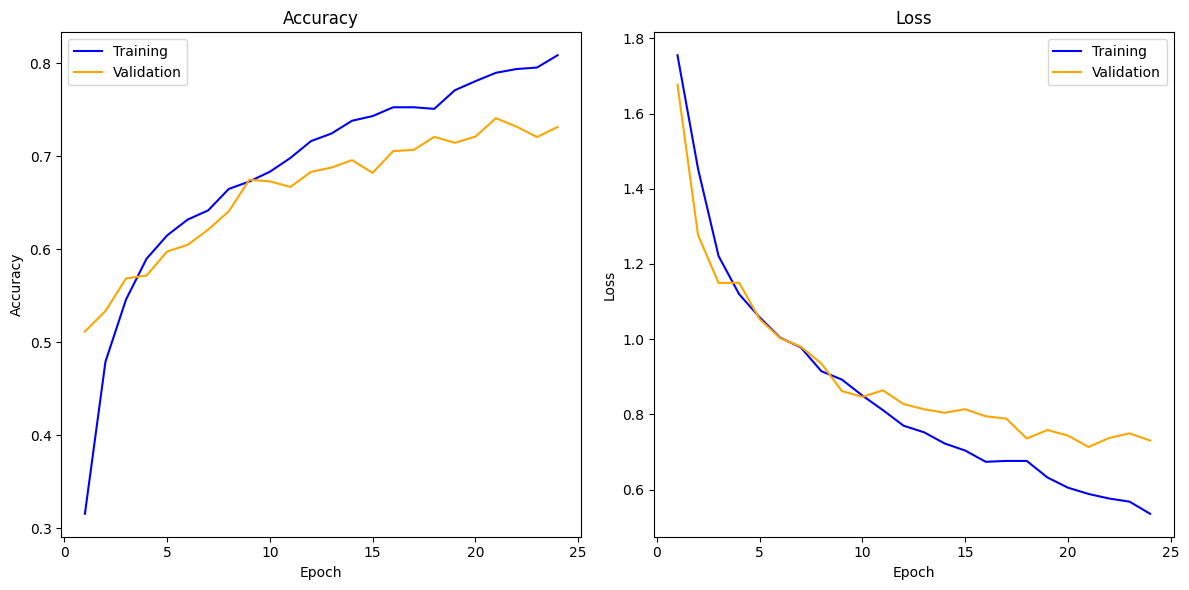

In [ ]:
# Criação do modelo e envio para o dispositivo (CPU ou GPU)
whisper_rnn_model = WhisperClassifierWithRNN(whisper_model, rnn_type='LTSM').to(device)

# Treinamento com Early Stopping
trained_whisper_rnn = train_model_with_rnn(
    whisper_rnn_model,
    train_loader=train_loader_whisper,
    val_loader=val_loader_whisper,
    epochs=500,
    learning_rate=1e-4,
    patience=3
)

In [ ]:
# Função de avaliação do modelo Whisper
def evaluate_model_whisper(model, test_loader, label_encoder):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)  # inputs.shape: [batch_size, sequence_length]
            labels = labels.to(device)

            # Forward pass através do modelo
            logits = model(inputs)  # logits.shape: [batch_size, num_labels]
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calcular a acurácia
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"Accuracy: {accuracy:.4f}")

    # Gerar relatório de classificação
    target_names = label_encoder.classes_
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=target_names))

    # Calcular a matriz de confusão
    cm = confusion_matrix(all_labels, all_preds)

    # Plotar a matriz de confusão
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=target_names,
                yticklabels=target_names)
    plt.ylabel('Rótulo Verdadeiro')
    plt.xlabel('Previsão do Modelo')
    plt.title('Matriz de Confusão')
    plt.show()

    return accuracy

In [ ]:
print(type(trained_whisper_rnn))


<class '__main__.WhisperClassifierWithRNN'>


Accuracy: 0.7446

Classification Report:
              precision    recall  f1-score   support

         ANG       0.85      0.83      0.84       510
         DIS       0.68      0.74      0.71       530
         FEA       0.69      0.67      0.68       494
         HAP       0.74      0.77      0.75       474
         NEU       0.79      0.86      0.82       426
         SAD       0.73      0.63      0.67       546

    accuracy                           0.74      2980
   macro avg       0.75      0.75      0.75      2980
weighted avg       0.74      0.74      0.74      2980



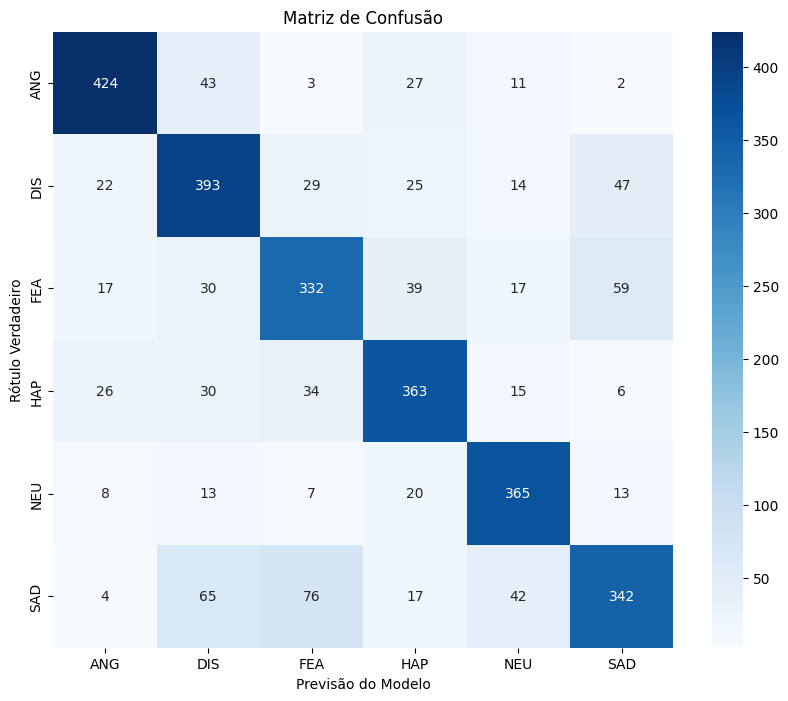

Whisper v3 with GRU Accuracy: 0.7446


In [ ]:
# Avaliação do modelo treinado
whisper_rnn_accuracy = evaluate_model_whisper(trained_whisper_rnn, test_loader_whisper, label_encoder)
print(f"Whisper v3 with GRU Accuracy: {whisper_rnn_accuracy:.4f}")

In [ ]:
# Salvar os pesos do modelo e a acurácia de teste
torch.save({
    'model_state_dict': trained_whisper_rnn.state_dict(),
    'test_accuracy': whisper_rnn_accuracy,
    'model_architecture': {
        'hidden_size': 256,  # Ou o valor que você utilizou
        'rnn_type': 'LSTM'
    }
}, 'whisper_medium_rnn_model.pt')

print("Modelo e acurácia salvos em 'whisper_rnn_model.pt'")

Modelo e acurácia salvos em 'whisper_rnn_model.pt'


In [ ]:
!cp /content/whisper_medium_rnn_model.pt /content/drive/MyDrive/testes_ML/Modelos_treinados



## Whisper Small

In [ ]:
# Classe Dataset com aumento de dados "on-the-fly"
class AugmentedCREMADataset(Dataset):
    def __init__(self, file_paths, labels, processor, sample_rate=16000):
        self.file_paths = file_paths
        self.labels = labels
        self.processor = processor  # Pode ser removido se não for usado
        self.sample_rate = sample_rate

    def __len__(self):
        # Retorna o dobro do tamanho para incluir dados originais e aumentados
        return len(self.file_paths) * 2

    def __getitem__(self, idx):
        if idx < len(self.file_paths):
            # Dados originais
            file_path = self.file_paths[idx]
            label = self.labels[idx]

            # Carregar áudio
            waveform, sr = torchaudio.load(file_path)
            if sr != self.sample_rate:
                waveform = torchaudio.transforms.Resample(orig_freq=sr, new_freq=self.sample_rate)(waveform)

            waveform = waveform.squeeze(0)  # Remove a dimensão extra (mono)

            # Retorna o waveform bruto e o label
            return waveform, label
        else:
            # Dados aumentados
            idx = idx - len(self.file_paths)
            file_path = self.file_paths[idx]
            label = self.labels[idx]

            # Carregar áudio
            waveform, sr = torchaudio.load(file_path)
            if sr != self.sample_rate:
                waveform = torchaudio.transforms.Resample(orig_freq=sr, new_freq=self.sample_rate)(waveform)

            waveform = waveform.squeeze(0)  # Remove a dimensão extra (mono)

            # Aplicar aumento de dados
            waveform = self.apply_random_augmentation(waveform, self.sample_rate)

            # Retorna o waveform aumentado e o label
            return waveform, label

    def apply_random_augmentation(self, waveform, sample_rate):
        # Escolha aleatória de uma técnica de aumento
        augmentation_methods = ['pitch_shift', 'add_noise', 'add_reverb', 'insert_silence']
        augmentation = random.choice(augmentation_methods)

        if augmentation == 'pitch_shift':
            n_steps = random.choice([-2, -1, 1, 2])  # Deslocamento de pitch
            augmented_waveform = pitch_shift(waveform.unsqueeze(0), sample_rate, n_steps).squeeze(0)
        elif augmentation == 'add_noise':
            noise_factor = random.uniform(0.001, 0.01)
            augmented_waveform = add_noise(waveform, noise_factor)
        elif augmentation == 'add_reverb':
            augmented_waveform = add_reverb(waveform.unsqueeze(0), sample_rate).squeeze(0)
        elif augmentation == 'insert_silence':
            max_silence_length = 0.5  # Em segundos
            augmented_waveform = insert_silence(waveform.unsqueeze(0), sample_rate, max_silence_length).squeeze(0)
        else:
            augmented_waveform = waveform  # Nenhuma alteração

        return augmented_waveform



In [ ]:
def collate_fn(batch):
    waveforms = [item[0] for item in batch]  # Lista de tensores PyTorch
    labels = [item[1] for item in batch]

    # Converter os waveforms para listas de numpy arrays
    waveforms = [waveform.numpy() for waveform in waveforms]

    # Processar usando o WhisperProcessor
    inputs = whisper_processor(
        waveforms,
        sampling_rate=16000,
        return_tensors="pt",
        padding=True
    )

    input_features = inputs.input_features  # Shape: [batch_size, num_mel_bins, seq_len]

    # Padronizar as input features para comprimento 3000 na dimensão temporal
    processed_inputs = []
    for feature in input_features:
        seq_len = feature.shape[1]
        if seq_len < 3000:
            # Pad com zeros até atingir 3000 frames
            pad_length = 3000 - seq_len
            padded_feature = torch.nn.functional.pad(feature, (0, pad_length), "constant", 0)
        elif seq_len > 3000:
            # Truncar para 3000 frames
            padded_feature = feature[:, :3000]
        else:
            padded_feature = feature  # Já tem comprimento 3000
        processed_inputs.append(padded_feature)

    # Empilhar as input features padronizadas
    processed_inputs = torch.stack(processed_inputs)

    # Verificar que as input features agora têm comprimento 3000
    #print(f"Input features shape after padding: {processed_inputs.shape}")  # Deve ser [batch_size, 80, 3000]

    labels = torch.tensor(labels)

    return processed_inputs, labels

In [ ]:
# Carregar o modelo Whisper pré-treinado
whisper_processor = WhisperProcessor.from_pretrained("openai/whisper-small")
whisper_model = WhisperModel.from_pretrained("openai/whisper-small")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/185k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/283k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/836k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.48M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/494k [00:00<?, ?B/s]

normalizer.json:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.19k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.97k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/967M [00:00<?, ?B/s]

In [ ]:
# Definir o batch size
batch_size = 128

# Data loaders para o Whisper, usando a função de collate personalizada
train_loader_whisper = DataLoader(
    AugmentedCREMADataset(train_files, train_labels, whisper_processor),
    batch_size=batch_size, shuffle=True, collate_fn=collate_fn, num_workers=0, pin_memory=True
)

val_loader_whisper = DataLoader(
    AugmentedCREMADataset(val_files, val_labels, whisper_processor),
    batch_size=batch_size, shuffle=False, collate_fn=collate_fn, num_workers=0, pin_memory=True
)

test_loader_whisper = DataLoader(
    AugmentedCREMADataset(test_files, test_labels, whisper_processor),
    batch_size=batch_size, shuffle=False, collate_fn=collate_fn, num_workers=0, pin_memory=True
)


In [ ]:
# Definir o classificador baseado no Whisper com RNN
class WhisperClassifierWithRNN(nn.Module):
    def __init__(self, whisper_model, hidden_size=256, rnn_type='GRU'):
        super(WhisperClassifierWithRNN, self).__init__()
        self.whisper = whisper_model
        self.hidden_size = hidden_size

        # Use either LSTM or GRU based on rnn_type parameter
        if rnn_type == 'GRU':
            self.rnn = nn.GRU(input_size=whisper_model.config.d_model, hidden_size=hidden_size, batch_first=True)
        else:
            self.rnn = nn.LSTM(input_size=whisper_model.config.d_model, hidden_size=hidden_size, batch_first=True)

        # Classificador com uma camada linear simples
        self.classifier = nn.Linear(hidden_size, 6)

    def forward(self, input_features):
        with torch.no_grad():
            # Use apenas o encoder do modelo Whisper
            encoder_outputs = self.whisper.encoder(input_features)
            hidden_states = encoder_outputs.last_hidden_state  # Shape: [batch_size, seq_len, hidden_size]

        # Passar pelo RNN (LSTM ou GRU)
        rnn_output, _ = self.rnn(hidden_states)  # Shape: [batch_size, seq_len, hidden_size]

        # Agregar tirando a média ao longo do comprimento da sequência
        rnn_output = rnn_output.mean(dim=1)  # Shape: [batch_size, hidden_size]

        # Classificar usando a camada linear
        logits = self.classifier(rnn_output)
        return logits


In [ ]:
def calculate_accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    correct = (preds == labels).sum().item()
    return correct / len(labels)

In [ ]:
# Treinamento semelhante ao modelo Wav2Vec2
def train_model_with_rnn(
    model, train_loader, val_loader, epochs=50, learning_rate=1e-5, patience=5
):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    best_val_loss = np.inf
    patience_counter = 0

    # Listas para armazenar as métricas de cada época
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    model.train()
    for epoch in range(epochs):
        start_time = time.time()  # Início da medição do tempo

        # Treinamento
        model.train()
        total_train_loss = 0.0
        total_train_accuracy = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            total_train_accuracy += calculate_accuracy(outputs, labels)

        avg_train_loss = total_train_loss / len(train_loader)
        avg_train_accuracy = total_train_accuracy / len(train_loader)
        train_losses.append(avg_train_loss)
        train_accuracies.append(avg_train_accuracy)

        # Validação
        model.eval()
        total_val_loss = 0.0
        total_val_accuracy = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass
                outputs = model(inputs)
                val_loss = criterion(outputs, labels)

                total_val_loss += val_loss.item()
                total_val_accuracy += calculate_accuracy(outputs, labels)

        avg_val_loss = total_val_loss / len(val_loader)
        avg_val_accuracy = total_val_accuracy / len(val_loader)
        val_losses.append(avg_val_loss)
        val_accuracies.append(avg_val_accuracy)

        # Tempo decorrido
        elapsed_time = time.time() - start_time
        print(f"Epoch {epoch + 1}, Train Loss: {avg_train_loss}, Val Loss: {avg_val_loss}, Train Acc: {avg_train_accuracy}, Val Acc: {avg_val_accuracy}, Time: {elapsed_time:.2f} seconds")

        # Early Stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            # Salvar o melhor modelo (opcional)
            torch.save(model.state_dict(), 'best_whisper_model.pth')
        else:
            patience_counter += 1
            print(f"No improvement in validation loss for {patience_counter} epochs.")

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch + 1}")
            break

        # Limpar memória após cada epoch
        gc.collect()  # Libera memória que não está mais em uso
        torch.cuda.empty_cache()  # Libera a memória da GPU (opcional)

    # Carregar o melhor modelo (opcional)
    model.load_state_dict(torch.load('best_whisper_model.pth'))

    # Plotar os gráficos de perda e acurácia
    epochs_range = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 6))

    # Gráfico de Acurácia
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_accuracies, label="Training", color="blue")
    plt.plot(epochs_range, val_accuracies, label="Validation", color="orange")
    plt.title("Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    # Gráfico de Perda
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_losses, label="Training", color="blue")
    plt.plot(epochs_range, val_losses, label="Validation", color="orange")
    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()

    return model

In [ ]:
# Criação do modelo e envio para o dispositivo (CPU ou GPU)
whisper_rnn_model = WhisperClassifierWithRNN(whisper_model, rnn_type='LTSM').to(device)

# Treinamento com Early Stopping
trained_whisper_rnn = train_model_with_rnn(
    whisper_rnn_model,
    train_loader=train_loader_whisper,
    val_loader=val_loader_whisper,
    epochs=20,
    learning_rate=1e-4,
    patience=5
)

In [ ]:
# Função de avaliação do modelo Whisper
def evaluate_model_whisper(model, test_loader, label_encoder):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)  # inputs.shape: [batch_size, sequence_length]
            labels = labels.to(device)

            # Forward pass através do modelo
            logits = model(inputs)  # logits.shape: [batch_size, num_labels]
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calcular a acurácia
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"Accuracy: {accuracy:.4f}")

    # Gerar relatório de classificação
    target_names = label_encoder.classes_
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=target_names))

    # Calcular a matriz de confusão
    cm = confusion_matrix(all_labels, all_preds)

    # Plotar a matriz de confusão
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=target_names,
                yticklabels=target_names)
    plt.ylabel('Rótulo Verdadeiro')
    plt.xlabel('Previsão do Modelo')
    plt.title('Matriz de Confusão')
    plt.show()

    return accuracy

In [ ]:
# Avaliação do modelo treinado
whisper_rnn_accuracy = evaluate_model_whisper(trained_whisper_rnn, test_loader_whisper, label_encoder)
print(f"Whisper v3 with GRU Accuracy: {whisper_rnn_accuracy:.4f}")

In [ ]:
# Salvar os pesos do modelo e a acurácia de teste
torch.save({
    'model_state_dict': trained_whisper_rnn.state_dict(),
    'test_accuracy': whisper_rnn_accuracy,
    'model_architecture': {
        'hidden_size': 256,  # Ou o valor que você utilizou
        'rnn_type': 'LSTM'
    }
}, 'whisper_small2_rnn_model.pt')

print("Modelo e acurácia salvos em 'whisper_small2_rnn_model.pt'")

In [ ]:
!cp /content/whisper_small2_rnn_model.pt /content/drive/MyDrive/testes_ML/Modelos_treinados

## Whisper Base

In [ ]:
# Classe Dataset com aumento de dados "on-the-fly"
class AugmentedCREMADataset(Dataset):
    def __init__(self, file_paths, labels, processor, sample_rate=16000):
        self.file_paths = file_paths
        self.labels = labels
        self.processor = processor  # Pode ser removido se não for usado
        self.sample_rate = sample_rate

    def __len__(self):
        # Retorna o dobro do tamanho para incluir dados originais e aumentados
        return len(self.file_paths) * 2

    def __getitem__(self, idx):
        if idx < len(self.file_paths):
            # Dados originais
            file_path = self.file_paths[idx]
            label = self.labels[idx]

            # Carregar áudio
            waveform, sr = torchaudio.load(file_path)
            if sr != self.sample_rate:
                waveform = torchaudio.transforms.Resample(orig_freq=sr, new_freq=self.sample_rate)(waveform)

            waveform = waveform.squeeze(0)  # Remove a dimensão extra (mono)

            # Retorna o waveform bruto e o label
            return waveform, label
        else:
            # Dados aumentados
            idx = idx - len(self.file_paths)
            file_path = self.file_paths[idx]
            label = self.labels[idx]

            # Carregar áudio
            waveform, sr = torchaudio.load(file_path)
            if sr != self.sample_rate:
                waveform = torchaudio.transforms.Resample(orig_freq=sr, new_freq=self.sample_rate)(waveform)

            waveform = waveform.squeeze(0)  # Remove a dimensão extra (mono)

            # Aplicar aumento de dados
            waveform = self.apply_random_augmentation(waveform, self.sample_rate)

            # Retorna o waveform aumentado e o label
            return waveform, label

    def apply_random_augmentation(self, waveform, sample_rate):
        # Escolha aleatória de uma técnica de aumento
        augmentation_methods = ['pitch_shift', 'add_noise', 'add_reverb', 'insert_silence']
        augmentation = random.choice(augmentation_methods)

        if augmentation == 'pitch_shift':
            n_steps = random.choice([-2, -1, 1, 2])  # Deslocamento de pitch
            augmented_waveform = pitch_shift(waveform.unsqueeze(0), sample_rate, n_steps).squeeze(0)
        elif augmentation == 'add_noise':
            noise_factor = random.uniform(0.001, 0.01)
            augmented_waveform = add_noise(waveform, noise_factor)
        elif augmentation == 'add_reverb':
            augmented_waveform = add_reverb(waveform.unsqueeze(0), sample_rate).squeeze(0)
        elif augmentation == 'insert_silence':
            max_silence_length = 0.5  # Em segundos
            augmented_waveform = insert_silence(waveform.unsqueeze(0), sample_rate, max_silence_length).squeeze(0)
        else:
            augmented_waveform = waveform  # Nenhuma alteração

        return augmented_waveform



In [ ]:
def collate_fn(batch):
    waveforms = [item[0] for item in batch]  # Lista de tensores PyTorch
    labels = [item[1] for item in batch]

    # Converter os waveforms para listas de numpy arrays
    waveforms = [waveform.numpy() for waveform in waveforms]

    # Processar usando o WhisperProcessor
    inputs = whisper_processor(
        waveforms,
        sampling_rate=16000,
        return_tensors="pt",
        padding=True
    )

    input_features = inputs.input_features  # Shape: [batch_size, num_mel_bins, seq_len]

    # Padronizar as input features para comprimento 3000 na dimensão temporal
    processed_inputs = []
    for feature in input_features:
        seq_len = feature.shape[1]
        if seq_len < 3000:
            # Pad com zeros até atingir 3000 frames
            pad_length = 3000 - seq_len
            padded_feature = torch.nn.functional.pad(feature, (0, pad_length), "constant", 0)
        elif seq_len > 3000:
            # Truncar para 3000 frames
            padded_feature = feature[:, :3000]
        else:
            padded_feature = feature  # Já tem comprimento 3000
        processed_inputs.append(padded_feature)

    # Empilhar as input features padronizadas
    processed_inputs = torch.stack(processed_inputs)

    # Verificar que as input features agora têm comprimento 3000
    #print(f"Input features shape after padding: {processed_inputs.shape}")  # Deve ser [batch_size, 80, 3000]

    labels = torch.tensor(labels)

    return processed_inputs, labels

In [ ]:
# Carregar o modelo Whisper pré-treinado
whisper_processor = WhisperProcessor.from_pretrained("openai/whisper-base")
whisper_model = WhisperModel.from_pretrained("openai/whisper-base")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/185k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/283k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/836k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.48M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/494k [00:00<?, ?B/s]

normalizer.json:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.19k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.98k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/290M [00:00<?, ?B/s]

In [ ]:
# Definir o batch size
batch_size = 64

# Data loaders para o Whisper, usando a função de collate personalizada
train_loader_whisper = DataLoader(
    AugmentedCREMADataset(train_files, train_labels, whisper_processor),
    batch_size=batch_size, shuffle=True, collate_fn=collate_fn, num_workers=0, pin_memory=True
)

val_loader_whisper = DataLoader(
    AugmentedCREMADataset(val_files, val_labels, whisper_processor),
    batch_size=batch_size, shuffle=False, collate_fn=collate_fn, num_workers=0, pin_memory=True
)

test_loader_whisper = DataLoader(
    AugmentedCREMADataset(test_files, test_labels, whisper_processor),
    batch_size=batch_size, shuffle=False, collate_fn=collate_fn, num_workers=0, pin_memory=True
)

In [ ]:
# Definir o classificador baseado no Whisper com RNN
class WhisperClassifierWithRNN(nn.Module):
    def __init__(self, whisper_model, hidden_size=256, rnn_type='GRU'):
        super(WhisperClassifierWithRNN, self).__init__()
        self.whisper = whisper_model
        self.hidden_size = hidden_size

        # Use either LSTM or GRU based on rnn_type parameter
        if rnn_type == 'GRU':
            self.rnn = nn.GRU(input_size=whisper_model.config.d_model, hidden_size=hidden_size, batch_first=True)
        else:
            self.rnn = nn.LSTM(input_size=whisper_model.config.d_model, hidden_size=hidden_size, batch_first=True)

        # Classificador com uma camada linear simples
        self.classifier = nn.Linear(hidden_size, 6)

    def forward(self, input_features):
        with torch.no_grad():
            # Use apenas o encoder do modelo Whisper
            encoder_outputs = self.whisper.encoder(input_features)
            hidden_states = encoder_outputs.last_hidden_state  # Shape: [batch_size, seq_len, hidden_size]

        # Passar pelo RNN (LSTM ou GRU)
        rnn_output, _ = self.rnn(hidden_states)  # Shape: [batch_size, seq_len, hidden_size]

        # Agregar tirando a média ao longo do comprimento da sequência
        rnn_output = rnn_output.mean(dim=1)  # Shape: [batch_size, hidden_size]

        # Classificar usando a camada linear
        logits = self.classifier(rnn_output)
        return logits


In [ ]:
def calculate_accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    correct = (preds == labels).sum().item()
    return correct / len(labels)

In [ ]:
# Treinamento semelhante ao modelo Wav2Vec2
def train_model_with_rnn(
    model, train_loader, val_loader, epochs=50, learning_rate=1e-5, patience=5
):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    best_val_loss = np.inf
    patience_counter = 0

    # Listas para armazenar as métricas de cada época
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    model.train()
    for epoch in range(epochs):
        start_time = time.time()  # Início da medição do tempo

        # Treinamento
        model.train()
        total_train_loss = 0.0
        total_train_accuracy = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            total_train_accuracy += calculate_accuracy(outputs, labels)

        avg_train_loss = total_train_loss / len(train_loader)
        avg_train_accuracy = total_train_accuracy / len(train_loader)
        train_losses.append(avg_train_loss)
        train_accuracies.append(avg_train_accuracy)

        # Validação
        model.eval()
        total_val_loss = 0.0
        total_val_accuracy = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass
                outputs = model(inputs)
                val_loss = criterion(outputs, labels)

                total_val_loss += val_loss.item()
                total_val_accuracy += calculate_accuracy(outputs, labels)

        avg_val_loss = total_val_loss / len(val_loader)
        avg_val_accuracy = total_val_accuracy / len(val_loader)
        val_losses.append(avg_val_loss)
        val_accuracies.append(avg_val_accuracy)

        # Tempo decorrido
        elapsed_time = time.time() - start_time
        print(f"Epoch {epoch + 1}, Train Loss: {avg_train_loss}, Val Loss: {avg_val_loss}, Train Acc: {avg_train_accuracy}, Val Acc: {avg_val_accuracy}, Time: {elapsed_time:.2f} seconds")

        # Early Stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            # Salvar o melhor modelo (opcional)
            torch.save(model.state_dict(), 'best_whisper_model.pth')
        else:
            patience_counter += 1
            print(f"No improvement in validation loss for {patience_counter} epochs.")

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch + 1}")
            break

        # Limpar memória após cada epoch
        gc.collect()  # Libera memória que não está mais em uso
        torch.cuda.empty_cache()  # Libera a memória da GPU (opcional)

    # Carregar o melhor modelo (opcional)
    model.load_state_dict(torch.load('best_whisper_model.pth'))

    # Plotar os gráficos de perda e acurácia
    epochs_range = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 6))

    # Gráfico de Acurácia
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_accuracies, label="Training", color="blue")
    plt.plot(epochs_range, val_accuracies, label="Validation", color="orange")
    plt.title("Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    # Gráfico de Perda
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_losses, label="Training", color="blue")
    plt.plot(epochs_range, val_losses, label="Validation", color="orange")
    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()

    return model

In [ ]:
# Criação do modelo e envio para o dispositivo (CPU ou GPU)
whisper_rnn_model = WhisperClassifierWithRNN(whisper_model, rnn_type='GRU').to(device)

# Treinamento com Early Stopping
trained_whisper_rnn = train_model_with_rnn(
    model=whisper_rnn_model,
    train_loader=train_loader_whisper,
    val_loader=val_loader_whisper,
    epochs=500,
    learning_rate=1e-5,
    patience=5
)

Epoch 1, Train Loss: 1.7923788925496544, Val Loss: 1.77276215000429, Train Acc: 0.20856707317073173, Val Acc: 0.29415760869565216, Time: 2201.91 seconds
Epoch 2, Train Loss: 1.7647671193611332, Val Loss: 1.7531170845031738, Train Acc: 0.2901829268292683, Val Acc: 0.3598278985507246, Time: 785.55 seconds
Epoch 3, Train Loss: 1.7443415502222572, Val Loss: 1.7322609493697898, Train Acc: 0.36586890243902437, Val Acc: 0.3992300724637681, Time: 783.70 seconds
Epoch 4, Train Loss: 1.7200458735954471, Val Loss: 1.7054082086120828, Train Acc: 0.38663109756097563, Val Acc: 0.384963768115942, Time: 775.89 seconds
Epoch 5, Train Loss: 1.6871836644847218, Val Loss: 1.6654549612515215, Train Acc: 0.39664634146341465, Val Acc: 0.4076086956521739, Time: 777.68 seconds
Epoch 6, Train Loss: 1.6379534541106806, Val Loss: 1.6009156237477842, Train Acc: 0.40646341463414637, Val Acc: 0.39968297101449274, Time: 773.09 seconds
Epoch 7, Train Loss: 1.5530989001436932, Val Loss: 1.5105207726575327, Train Acc: 0

In [ ]:
# Função de avaliação do modelo Whisper
def evaluate_model_whisper(model, test_loader, label_encoder):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)  # inputs.shape: [batch_size, sequence_length]
            labels = labels.to(device)

            # Forward pass através do modelo
            logits = model(inputs)  # logits.shape: [batch_size, num_labels]
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calcular a acurácia
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"Accuracy: {accuracy:.4f}")

    # Gerar relatório de classificação
    target_names = label_encoder.classes_
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=target_names))

    # Calcular a matriz de confusão
    cm = confusion_matrix(all_labels, all_preds)

    # Plotar a matriz de confusão
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=target_names,
                yticklabels=target_names)
    plt.ylabel('Rótulo Verdadeiro')
    plt.xlabel('Previsão do Modelo')
    plt.title('Matriz de Confusão')
    plt.show()

    return accuracy

In [ ]:
# Avaliação do modelo treinado
whisper_rnn_accuracy = evaluate_model_whisper(trained_whisper_rnn, test_loader_whisper, label_encoder)
print(f"Whisper v3 with GRU Accuracy: {whisper_rnn_accuracy:.4f}")

In [ ]:
# Salvar os pesos do modelo e a acurácia de teste
torch.save({
    'model_state_dict': trained_whisper_rnn.state_dict(),
    'test_accuracy': whisper_rnn_accuracy,
    'model_architecture': {
        'hidden_size': 256,  # Ou o valor que você utilizou
        'rnn_type': 'GRU'
    }
}, 'whisper_base8_rnn_model.pt')

print("Modelo e acurácia salvos em 'whisper_base8_rnn_model.pt'")

In [ ]:
!cp /content/whisper_base8_rnn_model.pt /content/drive/MyDrive/testes_ML/Modelos_treinados

## Whisper Tiny

In [ ]:
# Classe Dataset com aumento de dados "on-the-fly"
class AugmentedCREMADataset(Dataset):
    def __init__(self, file_paths, labels, processor, sample_rate=16000):
        self.file_paths = file_paths
        self.labels = labels
        self.processor = processor  # Pode ser removido se não for usado
        self.sample_rate = sample_rate

    def __len__(self):
        # Retorna o dobro do tamanho para incluir dados originais e aumentados
        return len(self.file_paths) * 2

    def __getitem__(self, idx):
        if idx < len(self.file_paths):
            # Dados originais
            file_path = self.file_paths[idx]
            label = self.labels[idx]

            # Carregar áudio
            waveform, sr = torchaudio.load(file_path)
            if sr != self.sample_rate:
                waveform = torchaudio.transforms.Resample(orig_freq=sr, new_freq=self.sample_rate)(waveform)

            waveform = waveform.squeeze(0)  # Remove a dimensão extra (mono)

            # Retorna o waveform bruto e o label
            return waveform, label
        else:
            # Dados aumentados
            idx = idx - len(self.file_paths)
            file_path = self.file_paths[idx]
            label = self.labels[idx]

            # Carregar áudio
            waveform, sr = torchaudio.load(file_path)
            if sr != self.sample_rate:
                waveform = torchaudio.transforms.Resample(orig_freq=sr, new_freq=self.sample_rate)(waveform)

            waveform = waveform.squeeze(0)  # Remove a dimensão extra (mono)

            # Aplicar aumento de dados
            waveform = self.apply_random_augmentation(waveform, self.sample_rate)

            # Retorna o waveform aumentado e o label
            return waveform, label

    def apply_random_augmentation(self, waveform, sample_rate):
        # Escolha aleatória de uma técnica de aumento
        augmentation_methods = ['pitch_shift', 'add_noise', 'add_reverb', 'insert_silence']
        augmentation = random.choice(augmentation_methods)

        if augmentation == 'pitch_shift':
            n_steps = random.choice([-2, -1, 1, 2])  # Deslocamento de pitch
            augmented_waveform = pitch_shift(waveform.unsqueeze(0), sample_rate, n_steps).squeeze(0)
        elif augmentation == 'add_noise':
            noise_factor = random.uniform(0.001, 0.01)
            augmented_waveform = add_noise(waveform, noise_factor)
        elif augmentation == 'add_reverb':
            augmented_waveform = add_reverb(waveform.unsqueeze(0), sample_rate).squeeze(0)
        elif augmentation == 'insert_silence':
            max_silence_length = 0.5  # Em segundos
            augmented_waveform = insert_silence(waveform.unsqueeze(0), sample_rate, max_silence_length).squeeze(0)
        else:
            augmented_waveform = waveform  # Nenhuma alteração

        return augmented_waveform


In [ ]:
def collate_fn(batch):
    waveforms = [item[0] for item in batch]  # Lista de tensores PyTorch
    labels = [item[1] for item in batch]

    # Converter os waveforms para listas de numpy arrays
    waveforms = [waveform.numpy() for waveform in waveforms]

    # Processar usando o WhisperProcessor
    inputs = whisper_processor(
        waveforms,
        sampling_rate=16000,
        return_tensors="pt",
        padding=True
    )

    input_features = inputs.input_features  # Shape: [batch_size, num_mel_bins, seq_len]

    # Padronizar as input features para comprimento 3000 na dimensão temporal
    processed_inputs = []
    for feature in input_features:
        seq_len = feature.shape[1]
        if seq_len < 3000:
            # Pad com zeros até atingir 3000 frames
            pad_length = 3000 - seq_len
            padded_feature = torch.nn.functional.pad(feature, (0, pad_length), "constant", 0)
        elif seq_len > 3000:
            # Truncar para 3000 frames
            padded_feature = feature[:, :3000]
        else:
            padded_feature = feature  # Já tem comprimento 3000
        processed_inputs.append(padded_feature)

    # Empilhar as input features padronizadas
    processed_inputs = torch.stack(processed_inputs)

    # Verificar que as input features agora têm comprimento 3000
    #print(f"Input features shape after padding: {processed_inputs.shape}")  # Deve ser [batch_size, 80, 3000]

    labels = torch.tensor(labels)

    return processed_inputs, labels

In [ ]:
# Carregar o modelo Whisper pré-treinado
whisper_processor = WhisperProcessor.from_pretrained("openai/whisper-tiny")
whisper_model = WhisperModel.from_pretrained("openai/whisper-tiny")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/185k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/283k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/836k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.48M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/494k [00:00<?, ?B/s]

normalizer.json:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.19k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.98k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/151M [00:00<?, ?B/s]

In [ ]:
# Definir o batch size
batch_size = 32

# Data loaders para o Whisper, usando a função de collate personalizada
train_loader_whisper = DataLoader(
    AugmentedCREMADataset(train_files, train_labels, whisper_processor),
    batch_size=batch_size, shuffle=True, collate_fn=collate_fn, num_workers=0, pin_memory=True
)

val_loader_whisper = DataLoader(
    AugmentedCREMADataset(val_files, val_labels, whisper_processor),
    batch_size=batch_size, shuffle=False, collate_fn=collate_fn, num_workers=0, pin_memory=True
)

test_loader_whisper = DataLoader(
    AugmentedCREMADataset(test_files, test_labels, whisper_processor),
    batch_size=batch_size, shuffle=False, collate_fn=collate_fn, num_workers=0, pin_memory=True
)

In [ ]:
# Definir o classificador baseado no Whisper com RNN
class WhisperClassifierWithRNN(nn.Module):
    def __init__(self, whisper_model, hidden_size=256, rnn_type='GRU'):
        super(WhisperClassifierWithRNN, self).__init__()
        self.whisper = whisper_model
        self.hidden_size = hidden_size

        # Use either LSTM or GRU based on rnn_type parameter
        if rnn_type == 'GRU':
            self.rnn = nn.GRU(input_size=whisper_model.config.d_model, hidden_size=hidden_size, batch_first=True)
        else:
            self.rnn = nn.LSTM(input_size=whisper_model.config.d_model, hidden_size=hidden_size, batch_first=True)

        # Classificador com uma camada linear simples
        self.classifier = nn.Linear(hidden_size, 6)

    def forward(self, input_features):

        # Use apenas o encoder do modelo Whisper
        encoder_outputs = self.whisper.encoder(input_features)
        hidden_states = encoder_outputs.last_hidden_state  # Shape: [batch_size, seq_len, hidden_size]

        # Passar pelo RNN (LSTM ou GRU)
        rnn_output, _ = self.rnn(hidden_states)  # Shape: [batch_size, seq_len, hidden_size]

        # Agregar tirando a média ao longo do comprimento da sequência
        rnn_output = rnn_output.mean(dim=1)  # Shape: [batch_size, hidden_size]

        # Classificar usando a camada linear
        logits = self.classifier(rnn_output)
        return logits

In [ ]:
def calculate_accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    correct = (preds == labels).sum().item()
    return correct / len(labels)

In [ ]:
# Treinamento semelhante ao modelo Wav2Vec2
def train_model_with_rnn(
    model, train_loader, val_loader, epochs=50, learning_rate=1e-5, patience=5
):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    best_val_loss = np.inf
    patience_counter = 0

    # Listas para armazenar as métricas de cada época
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    model.train()
    for epoch in range(epochs):
        start_time = time.time()  # Início da medição do tempo

        # Treinamento
        model.train()
        total_train_loss = 0.0
        total_train_accuracy = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            total_train_accuracy += calculate_accuracy(outputs, labels)

        avg_train_loss = total_train_loss / len(train_loader)
        avg_train_accuracy = total_train_accuracy / len(train_loader)
        train_losses.append(avg_train_loss)
        train_accuracies.append(avg_train_accuracy)

        # Validação
        model.eval()
        total_val_loss = 0.0
        total_val_accuracy = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass
                outputs = model(inputs)
                val_loss = criterion(outputs, labels)

                total_val_loss += val_loss.item()
                total_val_accuracy += calculate_accuracy(outputs, labels)

        avg_val_loss = total_val_loss / len(val_loader)
        avg_val_accuracy = total_val_accuracy / len(val_loader)
        val_losses.append(avg_val_loss)
        val_accuracies.append(avg_val_accuracy)

        # Tempo decorrido
        elapsed_time = time.time() - start_time
        print(f"Epoch {epoch + 1}, Train Loss: {avg_train_loss}, Val Loss: {avg_val_loss}, Train Acc: {avg_train_accuracy}, Val Acc: {avg_val_accuracy}, Time: {elapsed_time:.2f} seconds")

        # Early Stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            # Salvar o melhor modelo (opcional)
            torch.save(model.state_dict(), 'best_whisper_model.pth')
        else:
            patience_counter += 1
            print(f"No improvement in validation loss for {patience_counter} epochs.")

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch + 1}")
            break

        # Limpar memória após cada epoch
        gc.collect()  # Libera memória que não está mais em uso
        torch.cuda.empty_cache()  # Libera a memória da GPU (opcional)

    # Carregar o melhor modelo (opcional)
    model.load_state_dict(torch.load('best_whisper_model.pth'))

    # Plotar os gráficos de perda e acurácia
    epochs_range = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 6))

    # Gráfico de Acurácia
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_accuracies, label="Training", color="blue")
    plt.plot(epochs_range, val_accuracies, label="Validation", color="orange")
    plt.title("Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    # Gráfico de Perda
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_losses, label="Training", color="blue")
    plt.plot(epochs_range, val_losses, label="Validation", color="orange")
    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()

    return model

Epoch 1, Train Loss: 1.149720259429773, Val Loss: 1.0059233029393384, Train Acc: 0.552674205378973, Val Acc: 0.6277372262773723, Time: 6057.68 seconds
Epoch 2, Train Loss: 0.8173144217079601, Val Loss: 0.869277654338057, Train Acc: 0.696638141809291, Val Acc: 0.6605839416058394, Time: 952.94 seconds
Epoch 3, Train Loss: 0.6286483184778311, Val Loss: 0.8299155914000351, Train Acc: 0.770614303178484, Val Acc: 0.7132755474452555, Time: 954.48 seconds
Epoch 4, Train Loss: 0.4822573693136714, Val Loss: 0.833483542839106, Train Acc: 0.8273074572127139, Val Acc: 0.7055200729927007, Time: 954.15 seconds
No improvement in validation loss for 1 epochs.
Epoch 5, Train Loss: 0.36752155027864614, Val Loss: 0.8770910986583599, Train Acc: 0.8726466992665037, Val Acc: 0.7112226277372263, Time: 954.84 seconds
No improvement in validation loss for 2 epochs.
Epoch 6, Train Loss: 0.29630651322254925, Val Loss: 0.9288267652048682, Train Acc: 0.897692542787286, Val Acc: 0.7235401459854015, Time: 947.60 seco

<ipython-input-19-7d4fa640e652>:86: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_whisper_model.pth'))


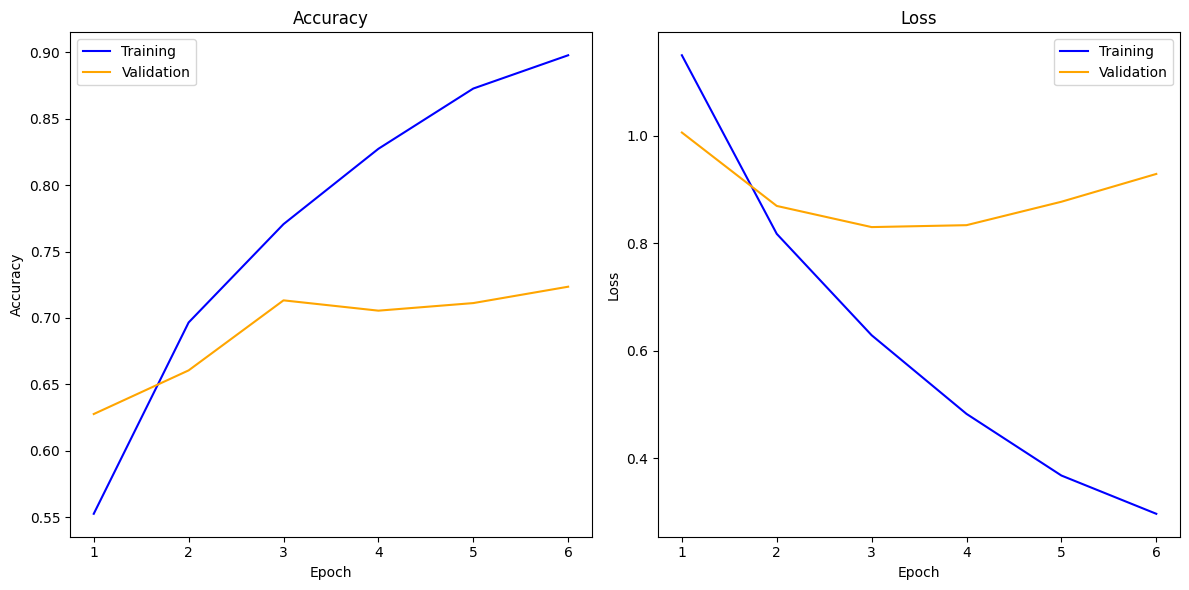

In [ ]:
# Criação do modelo e envio para o dispositivo (CPU ou GPU)
whisper_rnn_model = WhisperClassifierWithRNN(whisper_model, rnn_type='gru').to(device)

# Treinamento com Early Stopping
trained_whisper_rnn = train_model_with_rnn(
    whisper_rnn_model,
    train_loader=train_loader_whisper,
    val_loader=val_loader_whisper,
    epochs=100,
    learning_rate=1e-4,
    patience=3
)

In [ ]:
# Função de avaliação do modelo Whisper
def evaluate_model_whisper(model, test_loader, label_encoder):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)  # inputs.shape: [batch_size, sequence_length]
            labels = labels.to(device)

            # Forward pass através do modelo
            logits = model(inputs)  # logits.shape: [batch_size, num_labels]
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calcular a acurácia
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"Accuracy: {accuracy:.4f}")

    # Gerar relatório de classificação
    target_names = label_encoder.classes_
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=target_names))

    # Calcular a matriz de confusão
    cm = confusion_matrix(all_labels, all_preds)

    # Plotar a matriz de confusão
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=target_names,
                yticklabels=target_names)
    plt.ylabel('Rótulo Verdadeiro')
    plt.xlabel('Previsão do Modelo')
    plt.title('Matriz de Confusão')
    plt.show()

    return accuracy

Accuracy: 0.6950

Classification Report:
              precision    recall  f1-score   support

         ANG       0.78      0.79      0.79       768
         DIS       0.72      0.66      0.69       728
         FEA       0.71      0.57      0.63       778
         HAP       0.64      0.71      0.67       684
         NEU       0.69      0.77      0.73       646
         SAD       0.63      0.68      0.66       756

    accuracy                           0.69      4360
   macro avg       0.70      0.70      0.69      4360
weighted avg       0.70      0.69      0.69      4360



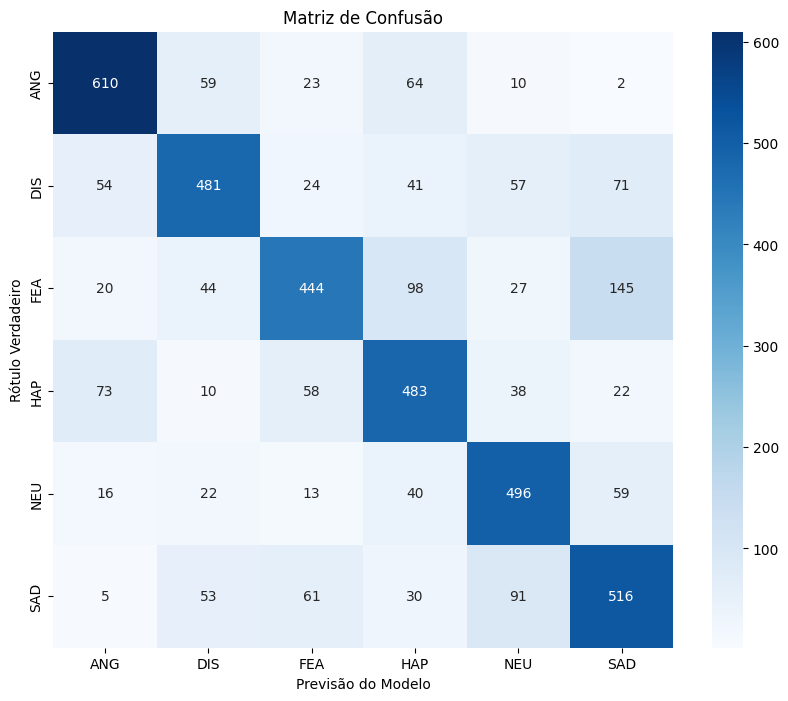

Whisper v3 with GRU Accuracy: 0.6950


In [ ]:
# Avaliação do modelo treinado
whisper_rnn_accuracy = evaluate_model_whisper(trained_whisper_rnn, test_loader_whisper, label_encoder)
print(f"Whisper v3 with GRU Accuracy: {whisper_rnn_accuracy:.4f}")

In [ ]:
# Salvar os pesos do modelo e a acurácia de teste
torch.save({
    'model_state_dict': trained_whisper_rnn.state_dict(),
    'test_accuracy': whisper_rnn_accuracy,
    'model_architecture': {
        'hidden_size': 256,  # Ou o valor que você utilizou
        'rnn_type': 'LSTM'
    }
}, 'whisper_tiny2_rnn_model.pt')

print("Modelo e acurácia salvos em 'whisper_tiny_rnn_model.pt'")

Modelo e acurácia salvos em 'whisper_tiny_rnn_model.pt'


In [ ]:
!cp /content/whisper_tiny2_rnn_model.pt /content/drive/MyDrive/testes_ML/Modelos_treinados

## Gráficos

<ipython-input-7-bc1289c4a2da>:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model['file'])


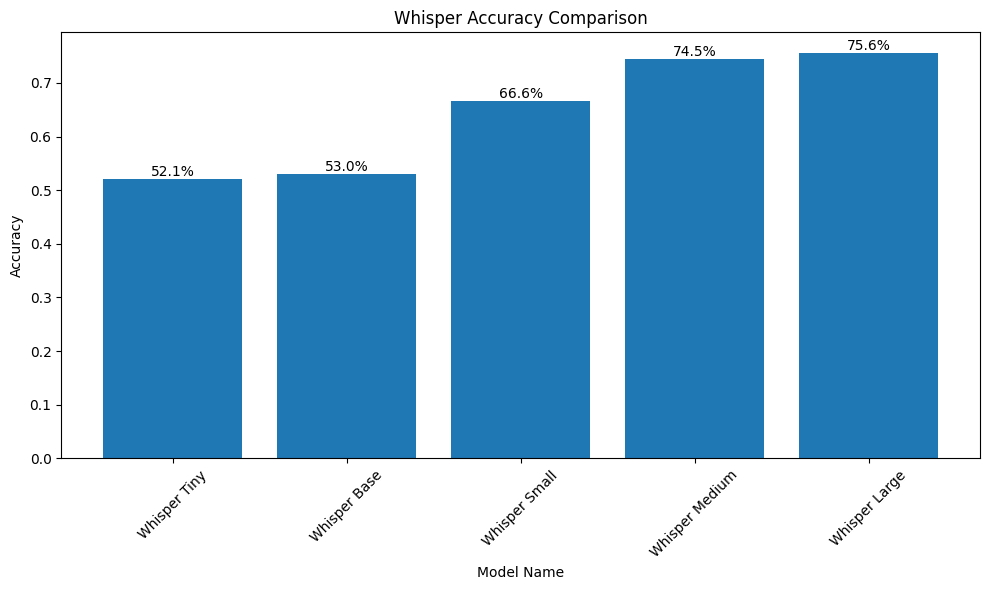

In [ ]:
import torch
import matplotlib.pyplot as plt

# Lista de arquivos de modelos e seus respectivos nomes
model_files = [
    {'name': 'Whisper Tiny', 'file': '/content/drive/MyDrive/testes_ML/Modelos_treinados/whisper_tiny_rnn_model.pt'},
    {'name': 'Whisper Base', 'file': '/content/drive/MyDrive/testes_ML/Modelos_treinados/whisper_base_rnn_model.pt'},
    {'name': 'Whisper Small', 'file': '/content/drive/MyDrive/testes_ML/Modelos_treinados/whisper_small_rnn_model.pt'},
    {'name': 'Whisper Medium', 'file': '/content/drive/MyDrive/testes_ML/Modelos_treinados/whisper_medium_rnn_model.pt'},
    {'name': 'Whisper Large', 'file': '/content/drive/MyDrive/testes_ML/Modelos_treinados/whisper_large_rnn_model.pt'}

]

# Lista para armazenar os nomes dos modelos e suas acurácias
model_names = []
accuracies = []

# Carregar cada modelo e extrair a acurácia
for model in model_files:
    checkpoint = torch.load(model['file'])
    model_names.append(model['name'])
    accuracies.append(checkpoint['test_accuracy'])

# Criar o gráfico
plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, accuracies)
plt.xlabel('Model Name')
plt.ylabel('Accuracy')
plt.title('Whisper Accuracy Comparison')
plt.xticks(rotation=45)

# Adicionar os valores de acurácia como texto sobre cada barra
for bar, accuracy in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
             f'{accuracy * 100:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()


<ipython-input-3-6054fb5ca7b1>:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model['file'])


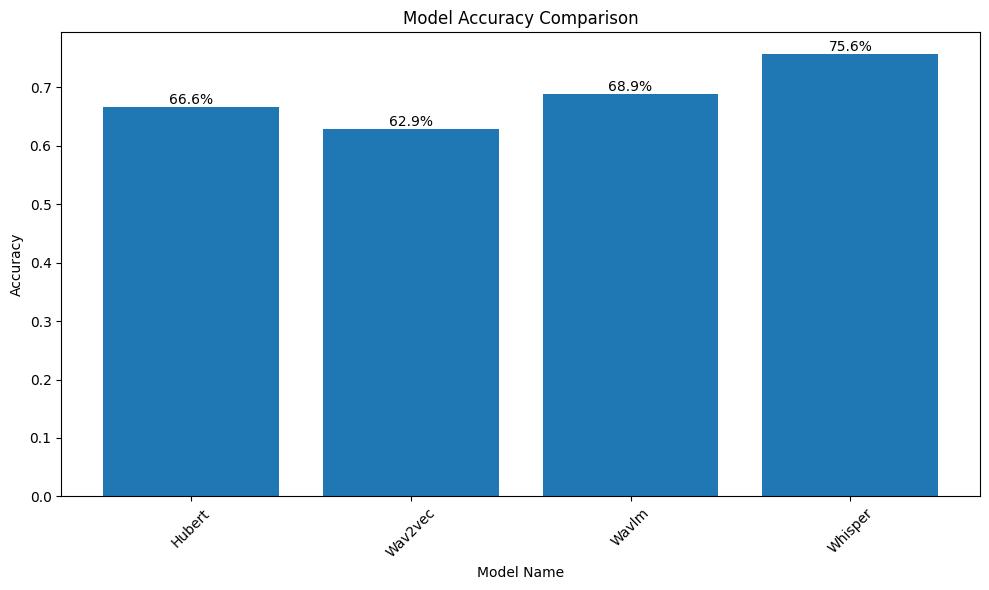

In [ ]:
import torch
import matplotlib.pyplot as plt

# Lista de arquivos de modelos e seus respectivos nomes
model_files = [
    {'name': 'Hubert', 'file': '/content/drive/MyDrive/testes_ML/Modelos_treinados/hubert_rnn_model.pt'},
    {'name': 'Wav2vec', 'file': '/content/drive/MyDrive/testes_ML/Modelos_treinados/wav2vec_rnn_model.pt'},
    {'name': 'Wavlm', 'file': '/content/drive/MyDrive/testes_ML/Modelos_treinados/wavlm_rnn_model.pt'},
    {'name': 'Whisper', 'file': '/content/drive/MyDrive/testes_ML/Modelos_treinados/whisper_large_rnn_model.pt'}


]

# Lista para armazenar os nomes dos modelos e suas acurácias
model_names = []
accuracies = []

# Carregar cada modelo e extrair a acurácia
for model in model_files:
    checkpoint = torch.load(model['file'])
    model_names.append(model['name'])
    accuracies.append(checkpoint['test_accuracy'])

# Criar o gráfico
plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, accuracies)
plt.xlabel('Model Name')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.xticks(rotation=45)

# Adicionar os valores de acurácia como texto sobre cada barra
for bar, accuracy in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
             f'{accuracy * 100:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()

## Transferência para Outras Línguas

### Francês(Canadiano)

Número total de arquivos de áudio: 432
Duração máxima: 7.53 segundos
Duração média: 4.47 segundos
Duração mínima: 2.76 segundos


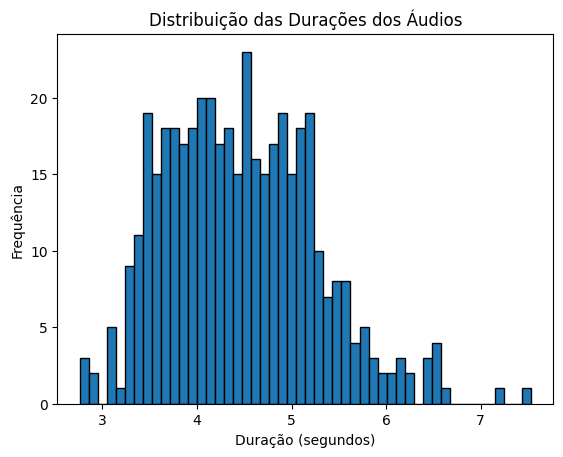

In [ ]:
def analyze_audio_durations(folder_path, sample_rate=16000):
    max_duration = 0.0
    total_duration = 0.0
    durations = []
    file_count = 0

    # Percorrer todos os arquivos na pasta especificada
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith('.wav'):  # Considere apenas arquivos WAV (ajuste conforme necessário)
                file_path = os.path.join(root, file)
                waveform, sr = torchaudio.load(file_path)
                if sr != sample_rate:
                    # Opcional: Resample para a taxa de amostragem desejada
                    resampler = torchaudio.transforms.Resample(orig_freq=sr, new_freq=sample_rate)
                    waveform = resampler(waveform)
                    sr = sample_rate
                # Calcular a duração em segundos
                duration = waveform.shape[1] / sr
                durations.append(duration)
                total_duration += duration
                file_count += 1
                if duration > max_duration:
                    max_duration = duration

    if file_count == 0:
        print("Nenhum arquivo de áudio encontrado na pasta especificada.")
        return

    average_duration = total_duration / file_count
    print(f"Número total de arquivos de áudio: {file_count}")
    print(f"Duração máxima: {max_duration:.2f} segundos")
    print(f"Duração média: {average_duration:.2f} segundos")
    print(f"Duração mínima: {min(durations):.2f} segundos")

    # Opcional: Exibir um histograma das durações
    import matplotlib.pyplot as plt
    plt.hist(durations, bins=50, edgecolor='black')
    plt.xlabel('Duração (segundos)')
    plt.ylabel('Frequência')
    plt.title('Distribuição das Durações dos Áudios')
    plt.show()

# Exemplo de uso:
folder_path = '/content/drive/MyDrive/testes_ML/Fran'  # Substitua pelo caminho da sua pasta
analyze_audio_durations(folder_path)

In [ ]:
# Classe Dataset com aumento de dados "on-the-fly"
class AugmentedCREMADataset(Dataset):
    def __init__(self, file_paths, labels, processor, sample_rate=16000):
        self.file_paths = file_paths
        self.labels = labels
        self.processor = processor  # Pode ser removido se não for usado
        self.sample_rate = sample_rate

    def __len__(self):
        # Retorna o dobro do tamanho para incluir dados originais e aumentados
        return len(self.file_paths) * 2

    def __getitem__(self, idx):
        if idx < len(self.file_paths):
            # Dados originais
            file_path = self.file_paths[idx]
            label = self.labels[idx]

            # Carregar áudio
            waveform, sr = torchaudio.load(file_path)
            if sr != self.sample_rate:
                waveform = torchaudio.transforms.Resample(orig_freq=sr, new_freq=self.sample_rate)(waveform)

            waveform = waveform.squeeze(0)  # Remove a dimensão extra (mono)

            # Retorna o waveform bruto e o label
            return waveform, label
        else:
            # Dados aumentados
            idx = idx - len(self.file_paths)
            file_path = self.file_paths[idx]
            label = self.labels[idx]

            # Carregar áudio
            waveform, sr = torchaudio.load(file_path)
            if sr != self.sample_rate:
                waveform = torchaudio.transforms.Resample(orig_freq=sr, new_freq=self.sample_rate)(waveform)

            waveform = waveform.squeeze(0)  # Remove a dimensão extra (mono)

            # Aplicar aumento de dados
            waveform = self.apply_random_augmentation(waveform, self.sample_rate)

            # Retorna o waveform aumentado e o label
            return waveform, label

    def apply_random_augmentation(self, waveform, sample_rate):
        # Escolha aleatória de uma técnica de aumento
        augmentation_methods = ['pitch_shift', 'add_noise', 'add_reverb', 'insert_silence']
        augmentation = random.choice(augmentation_methods)

        if augmentation == 'pitch_shift':
            n_steps = random.choice([-2, -1, 1, 2])  # Deslocamento de pitch
            augmented_waveform = pitch_shift(waveform.unsqueeze(0), sample_rate, n_steps).squeeze(0)
        elif augmentation == 'add_noise':
            noise_factor = random.uniform(0.001, 0.01)
            augmented_waveform = add_noise(waveform, noise_factor)
        elif augmentation == 'add_reverb':
            augmented_waveform = add_reverb(waveform.unsqueeze(0), sample_rate).squeeze(0)
        elif augmentation == 'insert_silence':
            max_silence_length = 0.5  # Em segundos
            augmented_waveform = insert_silence(waveform.unsqueeze(0), sample_rate, max_silence_length).squeeze(0)
        else:
            augmented_waveform = waveform  # Nenhuma alteração

        return augmented_waveform

In [ ]:
def evaluate_model_whisper(model, test_loader, label_encoder):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)  # inputs.shape: [batch_size, sequence_length]
            labels = labels.to(device)

            # Forward pass através do modelo
            logits = model(inputs)  # logits.shape: [batch_size, num_labels]
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calcular a acurácia
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"Accuracy: {accuracy:.4f}")

    # Gerar relatório de classificação
    target_names = label_encoder.classes_
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=target_names))

    # Calcular a matriz de confusão
    cm = confusion_matrix(all_labels, all_preds)

    # Plotar a matriz de confusão
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=target_names,
                yticklabels=target_names)
    plt.ylabel('Rótulo Verdadeiro')
    plt.xlabel('Previsão do Modelo')
    plt.title('Matriz de Confusão')
    plt.show()

    return accuracy

In [ ]:
# Definir o classificador baseado no Whisper com RNN
class WhisperClassifierWithRNN(nn.Module):
    def __init__(self, whisper_model, hidden_size=256, rnn_type='GRU'):
        super(WhisperClassifierWithRNN, self).__init__()
        self.whisper = whisper_model
        self.hidden_size = hidden_size

        # Use either LSTM or GRU based on rnn_type parameter
        if rnn_type == 'GRU':
            self.rnn = nn.GRU(input_size=whisper_model.config.d_model, hidden_size=hidden_size, batch_first=True)
        else:
            self.rnn = nn.LSTM(input_size=whisper_model.config.d_model, hidden_size=hidden_size, batch_first=True)

        # Classificador com uma camada linear simples
        self.classifier = nn.Linear(hidden_size, 6)

    def forward(self, input_features):
        with torch.no_grad():
            # Use apenas o encoder do modelo Whisper
            encoder_outputs = self.whisper.encoder(input_features)
            hidden_states = encoder_outputs.last_hidden_state  # Shape: [batch_size, seq_len, hidden_size]

        # Passar pelo RNN (LSTM ou GRU)
        rnn_output, _ = self.rnn(hidden_states)  # Shape: [batch_size, seq_len, hidden_size]

        # Agregar tirando a média ao longo do comprimento da sequência
        rnn_output = rnn_output.mean(dim=1)  # Shape: [batch_size, hidden_size]

        # Classificar usando a camada linear
        logits = self.classifier(rnn_output)
        return logits

In [ ]:
def collate_fn(batch):
    waveforms = [item[0] for item in batch]  # Lista de tensores PyTorch
    labels = [item[1] for item in batch]

    # Converter os waveforms para listas de numpy arrays
    waveforms = [waveform.numpy() for waveform in waveforms]

    # Padronizar as formas de onda para o mesmo comprimento
    max_length = max(len(waveform) for waveform in waveforms)
    padded_waveforms = [
        np.pad(waveform, (0, max_length - len(waveform)), 'constant') if len(waveform) < max_length else waveform
        for waveform in waveforms
    ]

    # Processar usando o WhisperProcessor
    inputs = whisper_processor(
        padded_waveforms,
        sampling_rate=16000,
        return_tensors="pt",
        padding=True
    )

    if 'input_features' in inputs:
        input_features = inputs['input_features']
    else:
        raise AttributeError("O WhisperProcessor não gerou 'input_features'. Verifique se os dados de entrada estão corretos.")

    # Padronizar as input features para comprimento 3000 na dimensão temporal
    processed_inputs = []
    for feature in input_features:
        seq_len = feature.shape[1]
        if seq_len < 3000:
            # Pad com zeros até atingir 3000 frames
            pad_length = 3000 - seq_len
            padded_feature = torch.nn.functional.pad(feature, (0, pad_length), "constant", 0)
        elif seq_len > 3000:
            # Truncar para 3000 frames
            padded_feature = feature[:, :3000]
        else:
            padded_feature = feature  # Já tem comprimento 3000
        processed_inputs.append(padded_feature)

    # Empilhar as input features padronizadas
    processed_inputs = torch.stack(processed_inputs)

    # Verificar que as input features agora têm comprimento 3000
    labels = torch.tensor(labels)

    return processed_inputs, labels


In [ ]:
def load_caf_data(data_dir):
    file_paths = []
    labels = []
    # Padrão de nome de arquivo esperado (ajuste conforme necessário)
    pattern = re.compile(r'(\w+)_(\w+)_(\w+)_.*\.wav$')

    for file_name in os.listdir(data_dir):
        if file_name.endswith(".wav"):
            match = pattern.match(file_name)
            if match:
                # Extraia o terceiro grupo como rótulo
                label = match.group(3)
                file_paths.append(os.path.join(data_dir, file_name))
                labels.append(label)
            else:
                print(f"Aviso: O arquivo '{file_name}' não corresponde ao padrão esperado e será ignorado.")
    return file_paths, labels

data_dir = "/content/drive/MyDrive/testes_ML/Fran"
file_paths, labels = load_caf_data(data_dir)

# Codificar os rótulos
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

print(f"Número de arquivos de áudio: {len(file_paths)}")
print(f"Número de rótulos: {len(encoded_labels)}")


Número de arquivos de áudio: 432
Número de rótulos: 432


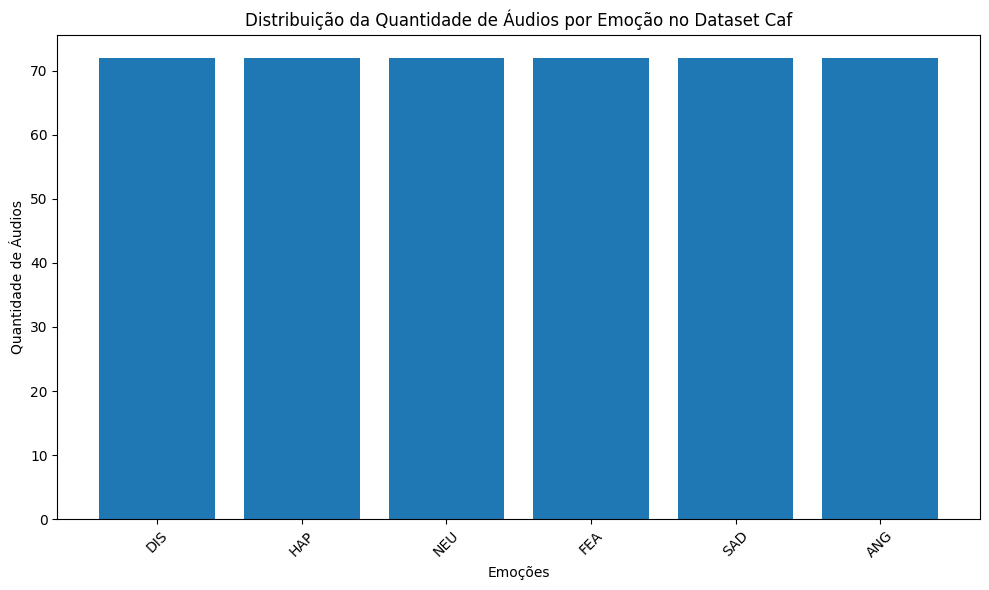

In [ ]:
# Contagem dos rótulos
label_counts = Counter(labels)

# Plotando o gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(label_counts.keys(), label_counts.values())
plt.xlabel('Emoções')
plt.ylabel('Quantidade de Áudios')
plt.title('Distribuição da Quantidade de Áudios por Emoção no Dataset Caf')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
whisper_processor = WhisperProcessor.from_pretrained("openai/whisper-large-v3")
whisper_model = WhisperModel.from_pretrained("openai/whisper-large-v3")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/340 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/283k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.48M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/494k [00:00<?, ?B/s]

normalizer.json:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.07k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.27k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.09G [00:00<?, ?B/s]

In [ ]:
new_dataset = AugmentedCREMADataset(file_paths, encoded_labels, whisper_processor)

In [ ]:
# Definir o batch size
batch_size = 64


test_loader_whisper = DataLoader(
    AugmentedCREMADataset(file_paths, encoded_labels, whisper_processor),
    batch_size=batch_size, shuffle=False, collate_fn=collate_fn, num_workers=0, pin_memory=True
)

In [ ]:
# Inicialize o modelo Whisper com RNN
whisper_rnn_model = WhisperClassifierWithRNN(whisper_model, rnn_type='GRU').to(device)

# Carregue os pesos do arquivo .pt
checkpoint = torch.load('/content/drive/MyDrive/testes_ML/Modelos_treinados/whisper_large4_rnn_model.pt')
whisper_rnn_model.load_state_dict(checkpoint['model_state_dict'])

# Coloque o modelo em modo de avaliação
whisper_rnn_model.eval()

<ipython-input-23-faaedf077481>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('/content/drive/MyDrive/testes_ML/Modelos_treinados/whisper_large4_r

WhisperClassifierWithRNN(
  (whisper): WhisperModel(
    (encoder): WhisperEncoder(
      (conv1): Conv1d(128, 1280, kernel_size=(3,), stride=(1,), padding=(1,))
      (conv2): Conv1d(1280, 1280, kernel_size=(3,), stride=(2,), padding=(1,))
      (embed_positions): Embedding(1500, 1280)
      (layers): ModuleList(
        (0-31): 32 x WhisperEncoderLayer(
          (self_attn): WhisperSdpaAttention(
            (k_proj): Linear(in_features=1280, out_features=1280, bias=False)
            (v_proj): Linear(in_features=1280, out_features=1280, bias=True)
            (q_proj): Linear(in_features=1280, out_features=1280, bias=True)
            (out_proj): Linear(in_features=1280, out_features=1280, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=1280, out_features=5120, bias=True)
          (fc2): Linear(in_features=5120, out_features=1280, bias=Tru

Accuracy: 0.3067

Classification Report:
              precision    recall  f1-score   support

         ANG       0.00      0.00      0.00       144
         DIS       0.49      0.52      0.51       144
         FEA       0.25      0.97      0.40       144
         HAP       1.00      0.01      0.03       144
         NEU       0.00      0.00      0.00       144
         SAD       0.32      0.33      0.32       144

    accuracy                           0.31       864
   macro avg       0.34      0.31      0.21       864
weighted avg       0.34      0.31      0.21       864



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


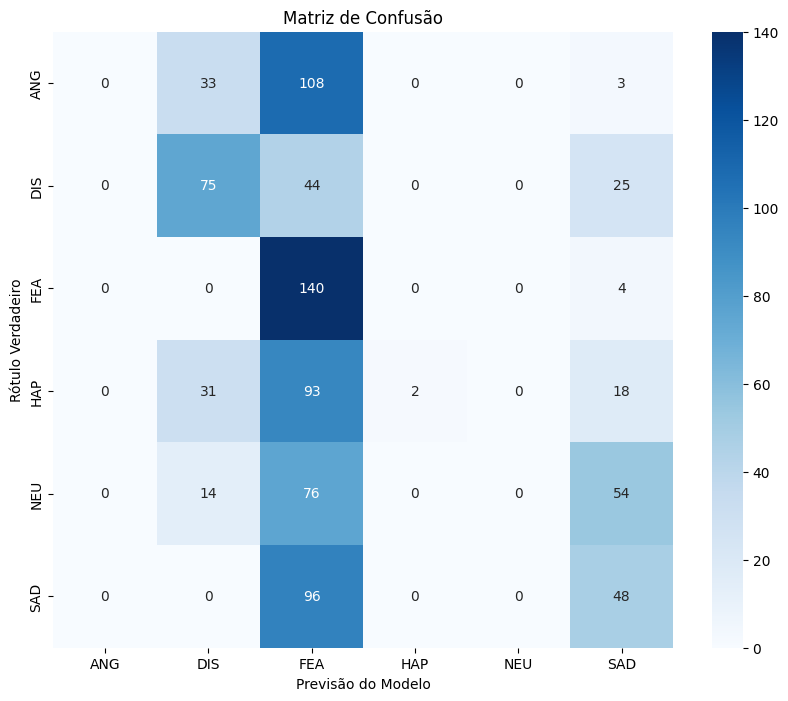

Accuracy on New Dataset: 0.3067


In [ ]:
new_dataset_accuracy = evaluate_model_whisper(whisper_rnn_model, test_loader_whisper, label_encoder)
print(f"Accuracy on New Dataset: {new_dataset_accuracy:.4f}")

### Italiano

Número total de arquivos de áudio: 504
Duração máxima: 13.99 segundos
Duração média: 3.12 segundos
Duração mínima: 1.29 segundos


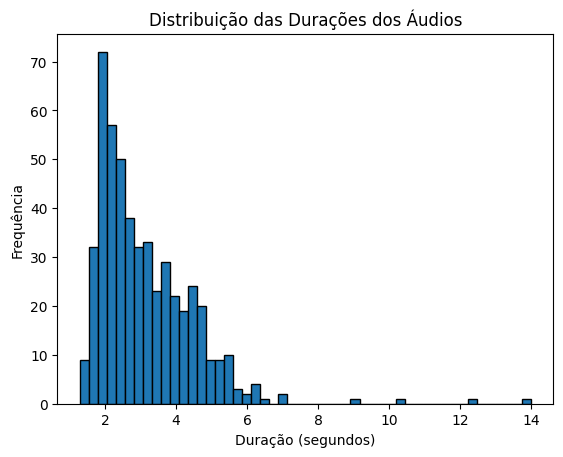

In [ ]:
def analyze_audio_durations(folder_path, sample_rate=16000):
    max_duration = 0.0
    total_duration = 0.0
    durations = []
    file_count = 0

    # Percorrer todos os arquivos na pasta especificada
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith('.wav'):  # Considere apenas arquivos WAV (ajuste conforme necessário)
                file_path = os.path.join(root, file)
                waveform, sr = torchaudio.load(file_path)
                if sr != sample_rate:
                    # Opcional: Resample para a taxa de amostragem desejada
                    resampler = torchaudio.transforms.Resample(orig_freq=sr, new_freq=sample_rate)
                    waveform = resampler(waveform)
                    sr = sample_rate
                # Calcular a duração em segundos
                duration = waveform.shape[1] / sr
                durations.append(duration)
                total_duration += duration
                file_count += 1
                if duration > max_duration:
                    max_duration = duration

    if file_count == 0:
        print("Nenhum arquivo de áudio encontrado na pasta especificada.")
        return

    average_duration = total_duration / file_count
    print(f"Número total de arquivos de áudio: {file_count}")
    print(f"Duração máxima: {max_duration:.2f} segundos")
    print(f"Duração média: {average_duration:.2f} segundos")
    print(f"Duração mínima: {min(durations):.2f} segundos")

    # Opcional: Exibir um histograma das durações
    import matplotlib.pyplot as plt
    plt.hist(durations, bins=50, edgecolor='black')
    plt.xlabel('Duração (segundos)')
    plt.ylabel('Frequência')
    plt.title('Distribuição das Durações dos Áudios')
    plt.show()

# Exemplo de uso:
folder_path = '/content/drive/MyDrive/testes_ML/EMOVO'  # Substitua pelo caminho da sua pasta
analyze_audio_durations(folder_path)

In [ ]:
# Classe Dataset com aumento de dados "on-the-fly"
class AugmentedCREMADataset(Dataset):
    def __init__(self, file_paths, labels, processor, sample_rate=16000):
        self.file_paths = file_paths
        self.labels = labels
        self.processor = processor  # Pode ser removido se não for usado
        self.sample_rate = sample_rate

    def __len__(self):
        # Retorna o dobro do tamanho para incluir dados originais e aumentados
        return len(self.file_paths) * 2

    def __getitem__(self, idx):
        if idx < len(self.file_paths):
            # Dados originais
            file_path = self.file_paths[idx]
            label = self.labels[idx]

            # Carregar áudio
            waveform, sr = torchaudio.load(file_path)
            if sr != self.sample_rate:
                waveform = torchaudio.transforms.Resample(orig_freq=sr, new_freq=self.sample_rate)(waveform)

            waveform = waveform.squeeze(0)  # Remove a dimensão extra (mono)

            # Retorna o waveform bruto e o label
            return waveform, label
        else:
            # Dados aumentados
            idx = idx - len(self.file_paths)
            file_path = self.file_paths[idx]
            label = self.labels[idx]

            # Carregar áudio
            waveform, sr = torchaudio.load(file_path)
            if sr != self.sample_rate:
                waveform = torchaudio.transforms.Resample(orig_freq=sr, new_freq=self.sample_rate)(waveform)

            waveform = waveform.squeeze(0)  # Remove a dimensão extra (mono)

            # Aplicar aumento de dados
            waveform = self.apply_random_augmentation(waveform, self.sample_rate)

            # Retorna o waveform aumentado e o label
            return waveform, label

    def apply_random_augmentation(self, waveform, sample_rate):
        # Escolha aleatória de uma técnica de aumento
        augmentation_methods = ['pitch_shift', 'add_noise', 'add_reverb', 'insert_silence']
        augmentation = random.choice(augmentation_methods)

        if augmentation == 'pitch_shift':
            n_steps = random.choice([-2, -1, 1, 2])  # Deslocamento de pitch
            augmented_waveform = pitch_shift(waveform.unsqueeze(0), sample_rate, n_steps).squeeze(0)
        elif augmentation == 'add_noise':
            noise_factor = random.uniform(0.001, 0.01)
            augmented_waveform = add_noise(waveform, noise_factor)
        elif augmentation == 'add_reverb':
            augmented_waveform = add_reverb(waveform.unsqueeze(0), sample_rate).squeeze(0)
        elif augmentation == 'insert_silence':
            max_silence_length = 0.5  # Em segundos
            augmented_waveform = insert_silence(waveform.unsqueeze(0), sample_rate, max_silence_length).squeeze(0)
        else:
            augmented_waveform = waveform  # Nenhuma alteração

        return augmented_waveform

In [ ]:
def evaluate_model_whisper(model, test_loader, label_encoder):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            # Movendo dados para o dispositivo (CPU ou GPU)
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass através do modelo
            logits = model(inputs)
            preds = torch.argmax(logits, dim=1)

            # Armazenando os resultados
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # **Libere a memória aqui**
            del inputs, labels, logits, preds  # Remover variáveis desnecessárias
            gc.collect()  # Forçar a coleta de lixo para liberar memória

    # Calcular a acurácia
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"Accuracy: {accuracy:.4f}")

    # Gerar relatório de classificação
    target_names = label_encoder.classes_
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=target_names))

    # Calcular a matriz de confusão
    cm = confusion_matrix(all_labels, all_preds)

    # Plotar a matriz de confusão
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=target_names,
                yticklabels=target_names)
    plt.ylabel('Rótulo Verdadeiro')
    plt.xlabel('Previsão do Modelo')
    plt.title('Matriz de Confusão')
    plt.show()

    return accuracy


In [ ]:
# Definir o classificador baseado no Whisper com RNN
class WhisperClassifierWithRNN(nn.Module):
    def __init__(self, whisper_model, hidden_size=256, rnn_type='GRU'):
        super(WhisperClassifierWithRNN, self).__init__()
        self.whisper = whisper_model
        self.hidden_size = hidden_size

        # Use either LSTM or GRU based on rnn_type parameter
        if rnn_type == 'GRU':
            self.rnn = nn.GRU(input_size=whisper_model.config.d_model, hidden_size=hidden_size, batch_first=True)
        else:
            self.rnn = nn.LSTM(input_size=whisper_model.config.d_model, hidden_size=hidden_size, batch_first=True)

        # Classificador com uma camada linear simples
        self.classifier = nn.Linear(hidden_size, 6)

    def forward(self, input_features):
        with torch.no_grad():
            # Use apenas o encoder do modelo Whisper
            encoder_outputs = self.whisper.encoder(input_features)
            hidden_states = encoder_outputs.last_hidden_state  # Shape: [batch_size, seq_len, hidden_size]

        # Passar pelo RNN (LSTM ou GRU)
        rnn_output, _ = self.rnn(hidden_states)  # Shape: [batch_size, seq_len, hidden_size]

        # Agregar tirando a média ao longo do comprimento da sequência
        rnn_output = rnn_output.mean(dim=1)  # Shape: [batch_size, hidden_size]

        # Classificar usando a camada linear
        logits = self.classifier(rnn_output)
        return logits


In [ ]:
def collate_fn(batch):
    waveforms = [item[0] for item in batch]  # Lista de tensores PyTorch
    labels = [item[1] for item in batch]

    # Converter os waveforms para listas de numpy arrays
    waveforms = [waveform.numpy() for waveform in waveforms]

    # Padronizar as formas de onda para o mesmo comprimento
    max_length = max(len(waveform) for waveform in waveforms)
    padded_waveforms = [
        np.pad(waveform, (0, max_length - len(waveform)), 'constant') if len(waveform) < max_length else waveform
        for waveform in waveforms
    ]

    # Processar usando o WhisperProcessor
    inputs = whisper_processor(
        padded_waveforms,
        sampling_rate=16000,
        return_tensors="pt",
        padding=True
    )

    if 'input_features' in inputs:
        input_features = inputs['input_features']
    else:
        raise AttributeError("O WhisperProcessor não gerou 'input_features'. Verifique se os dados de entrada estão corretos.")

    # Padronizar as input features para comprimento 3000 na dimensão temporal
    processed_inputs = []
    for feature in input_features:
        seq_len = feature.shape[1]
        if seq_len < 3000:
            # Pad com zeros até atingir 3000 frames
            pad_length = 3000 - seq_len
            padded_feature = torch.nn.functional.pad(feature, (0, pad_length), "constant", 0)
        elif seq_len > 3000:
            # Truncar para 3000 frames
            padded_feature = feature[:, :3000]
        else:
            padded_feature = feature  # Já tem comprimento 3000
        processed_inputs.append(padded_feature)

    # Empilhar as input features padronizadas
    processed_inputs = torch.stack(processed_inputs)

    # Verificar que as input features agora têm comprimento 3000
    labels = torch.tensor(labels)

    return processed_inputs, labels


In [ ]:
def load_emovo_data(data_dir):
    file_paths = []
    labels = []
    # Padrão de nome de arquivo esperado (ajuste conforme necessário)
    pattern = re.compile(r'(\w+)_(\w+)_(\w+)_.*\.wav$')

    for file_name in os.listdir(data_dir):
        if file_name.endswith(".wav"):
            match = pattern.match(file_name)
            if match:
                # Extraia o terceiro grupo como rótulo
                label = match.group(3)
                file_paths.append(os.path.join(data_dir, file_name))
                labels.append(label)
            else:
                print(f"Aviso: O arquivo '{file_name}' não corresponde ao padrão esperado e será ignorado.")
    return file_paths, labels

data_dir = "/content/drive/MyDrive/testes_ML/EMOVO"
file_paths, labels = load_emovo_data(data_dir)

# Codificar os rótulos
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

print(f"Número de arquivos de áudio: {len(file_paths)}")
print(f"Número de rótulos: {len(encoded_labels)}")

Número de arquivos de áudio: 504
Número de rótulos: 504


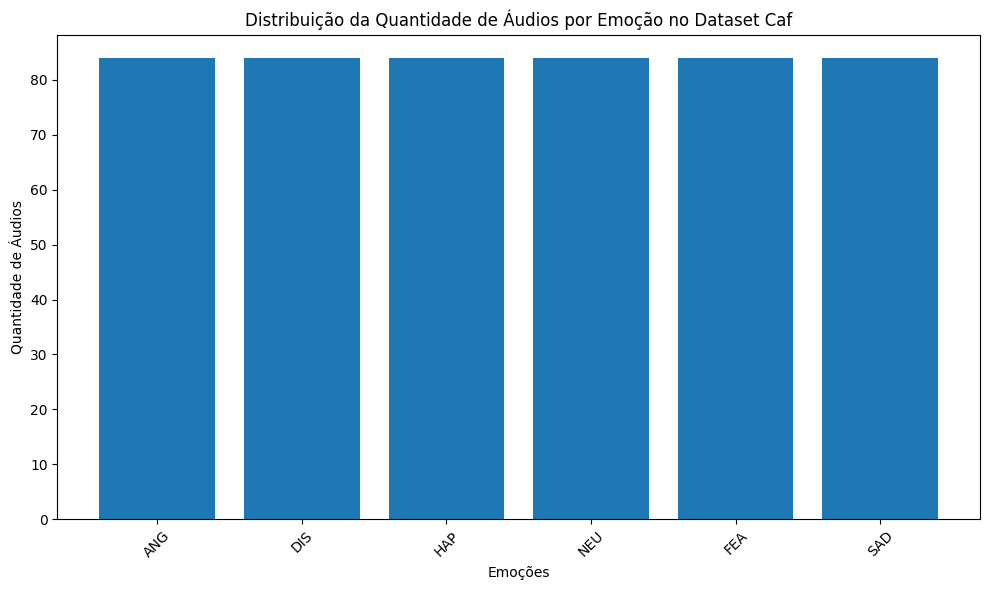

In [ ]:
# Contagem dos rótulos
label_counts = Counter(labels)

# Plotando o gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(label_counts.keys(), label_counts.values())
plt.xlabel('Emoções')
plt.ylabel('Quantidade de Áudios')
plt.title('Distribuição da Quantidade de Áudios por Emoção no Dataset Caf')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
whisper_processor = WhisperProcessor.from_pretrained("openai/whisper-large-v3")
whisper_model = WhisperModel.from_pretrained("openai/whisper-large-v3")

In [ ]:
new_dataset = AugmentedCREMADataset(file_paths, encoded_labels, whisper_processor)

In [ ]:
# Definir o batch size
batch_size = 4


test_loader_whisper = DataLoader(
    AugmentedCREMADataset(file_paths, encoded_labels, whisper_processor),
    batch_size=batch_size, shuffle=False, collate_fn=collate_fn, num_workers=0, pin_memory=True
)

In [ ]:
# Inicialize o modelo Whisper com RNN
whisper_rnn_model = WhisperClassifierWithRNN(whisper_model, rnn_type='GRU').to(device)

# Carregue os pesos do arquivo .pt
checkpoint = torch.load('/content/drive/MyDrive/testes_ML/Modelos_treinados/whisper_large4_rnn_model.pt')
whisper_rnn_model.load_state_dict(checkpoint['model_state_dict'])

# Coloque o modelo em modo de avaliação
whisper_rnn_model.eval()

<ipython-input-46-faaedf077481>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('/content/drive/MyDrive/testes_ML/Modelos_treinados/whisper_large4_r

WhisperClassifierWithRNN(
  (whisper): WhisperModel(
    (encoder): WhisperEncoder(
      (conv1): Conv1d(128, 1280, kernel_size=(3,), stride=(1,), padding=(1,))
      (conv2): Conv1d(1280, 1280, kernel_size=(3,), stride=(2,), padding=(1,))
      (embed_positions): Embedding(1500, 1280)
      (layers): ModuleList(
        (0-31): 32 x WhisperEncoderLayer(
          (self_attn): WhisperSdpaAttention(
            (k_proj): Linear(in_features=1280, out_features=1280, bias=False)
            (v_proj): Linear(in_features=1280, out_features=1280, bias=True)
            (q_proj): Linear(in_features=1280, out_features=1280, bias=True)
            (out_proj): Linear(in_features=1280, out_features=1280, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=1280, out_features=5120, bias=True)
          (fc2): Linear(in_features=5120, out_features=1280, bias=Tru

Accuracy: 0.3214

Classification Report:
              precision    recall  f1-score   support

         ANG       0.77      0.27      0.40       168
         DIS       0.87      0.08      0.14       168
         FEA       0.21      0.94      0.35       168
         HAP       1.00      0.04      0.07       168
         NEU       0.87      0.31      0.46       168
         SAD       0.38      0.29      0.33       168

    accuracy                           0.32      1008
   macro avg       0.68      0.32      0.29      1008
weighted avg       0.68      0.32      0.29      1008



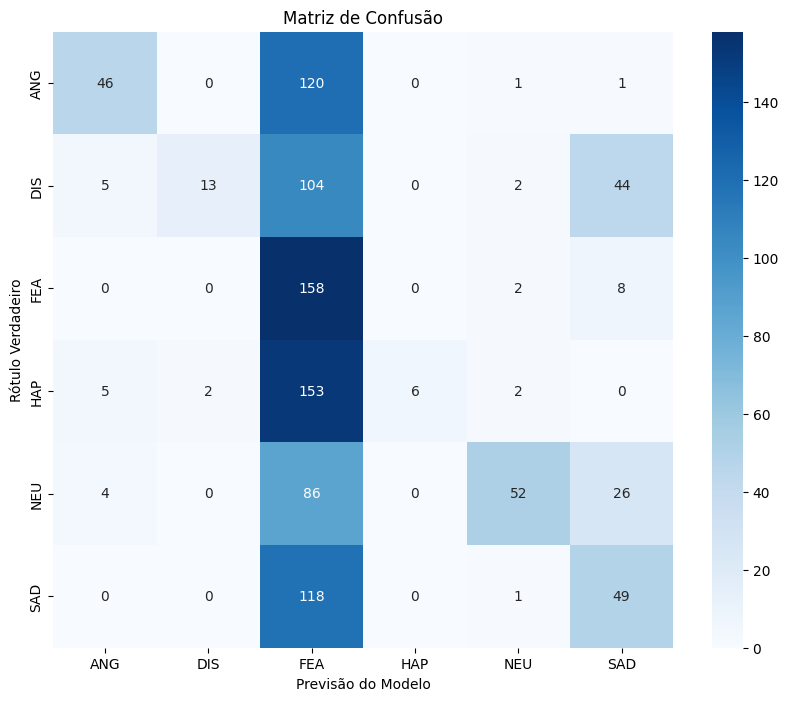

Accuracy on New Dataset: 0.3214


In [ ]:
new_dataset_accuracy = evaluate_model_whisper(whisper_rnn_model, test_loader_whisper, label_encoder)
print(f"Accuracy on New Dataset: {new_dataset_accuracy:.4f}")

### Alemão

Número total de arquivos de áudio: 454
Duração máxima: 8.98 segundos
Duração média: 2.78 segundos
Duração mínima: 1.23 segundos


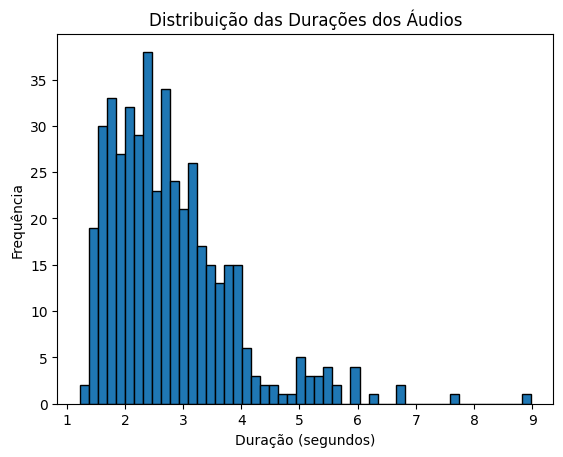

In [ ]:
def analyze_audio_durations(folder_path, sample_rate=16000):
    max_duration = 0.0
    total_duration = 0.0
    durations = []
    file_count = 0

    # Percorrer todos os arquivos na pasta especificada
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith('.wav'):  # Considere apenas arquivos WAV (ajuste conforme necessário)
                file_path = os.path.join(root, file)
                waveform, sr = torchaudio.load(file_path)
                if sr != sample_rate:
                    # Opcional: Resample para a taxa de amostragem desejada
                    resampler = torchaudio.transforms.Resample(orig_freq=sr, new_freq=sample_rate)
                    waveform = resampler(waveform)
                    sr = sample_rate
                # Calcular a duração em segundos
                duration = waveform.shape[1] / sr
                durations.append(duration)
                total_duration += duration
                file_count += 1
                if duration > max_duration:
                    max_duration = duration

    if file_count == 0:
        print("Nenhum arquivo de áudio encontrado na pasta especificada.")
        return

    average_duration = total_duration / file_count
    print(f"Número total de arquivos de áudio: {file_count}")
    print(f"Duração máxima: {max_duration:.2f} segundos")
    print(f"Duração média: {average_duration:.2f} segundos")
    print(f"Duração mínima: {min(durations):.2f} segundos")

    # Opcional: Exibir um histograma das durações
    import matplotlib.pyplot as plt
    plt.hist(durations, bins=50, edgecolor='black')
    plt.xlabel('Duração (segundos)')
    plt.ylabel('Frequência')
    plt.title('Distribuição das Durações dos Áudios')
    plt.show()

# Exemplo de uso:
folder_path = '/content/drive/MyDrive/testes_ML/EMODB'  # Substitua pelo caminho da sua pasta
analyze_audio_durations(folder_path)

In [ ]:
# Classe Dataset com aumento de dados "on-the-fly"
class AugmentedCREMADataset(Dataset):
    def __init__(self, file_paths, labels, processor, sample_rate=16000):
        self.file_paths = file_paths
        self.labels = labels
        self.processor = processor  # Pode ser removido se não for usado
        self.sample_rate = sample_rate

    def __len__(self):
        # Retorna o dobro do tamanho para incluir dados originais e aumentados
        return len(self.file_paths) * 2

    def __getitem__(self, idx):
        if idx < len(self.file_paths):
            # Dados originais
            file_path = self.file_paths[idx]
            label = self.labels[idx]

            # Carregar áudio
            waveform, sr = torchaudio.load(file_path)
            if sr != self.sample_rate:
                waveform = torchaudio.transforms.Resample(orig_freq=sr, new_freq=self.sample_rate)(waveform)

            waveform = waveform.squeeze(0)  # Remove a dimensão extra (mono)

            # Retorna o waveform bruto e o label
            return waveform, label
        else:
            # Dados aumentados
            idx = idx - len(self.file_paths)
            file_path = self.file_paths[idx]
            label = self.labels[idx]

            # Carregar áudio
            waveform, sr = torchaudio.load(file_path)
            if sr != self.sample_rate:
                waveform = torchaudio.transforms.Resample(orig_freq=sr, new_freq=self.sample_rate)(waveform)

            waveform = waveform.squeeze(0)  # Remove a dimensão extra (mono)

            # Aplicar aumento de dados
            waveform = self.apply_random_augmentation(waveform, self.sample_rate)

            # Retorna o waveform aumentado e o label
            return waveform, label

    def apply_random_augmentation(self, waveform, sample_rate):
        # Escolha aleatória de uma técnica de aumento
        augmentation_methods = ['pitch_shift', 'add_noise', 'add_reverb', 'insert_silence']
        augmentation = random.choice(augmentation_methods)

        if augmentation == 'pitch_shift':
            n_steps = random.choice([-2, -1, 1, 2])  # Deslocamento de pitch
            augmented_waveform = pitch_shift(waveform.unsqueeze(0), sample_rate, n_steps).squeeze(0)
        elif augmentation == 'add_noise':
            noise_factor = random.uniform(0.001, 0.01)
            augmented_waveform = add_noise(waveform, noise_factor)
        elif augmentation == 'add_reverb':
            augmented_waveform = add_reverb(waveform.unsqueeze(0), sample_rate).squeeze(0)
        elif augmentation == 'insert_silence':
            max_silence_length = 0.5  # Em segundos
            augmented_waveform = insert_silence(waveform.unsqueeze(0), sample_rate, max_silence_length).squeeze(0)
        else:
            augmented_waveform = waveform  # Nenhuma alteração

        return augmented_waveform

In [ ]:
def evaluate_model_whisper(model, test_loader, label_encoder):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            logits = model(inputs)
            probs = torch.nn.functional.softmax(logits, dim=1)
            preds = torch.argmax(probs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Relatório de Classificação
    target_names = label_encoder.classes_
    print("Valores únicos em all_labels:", np.unique(all_labels))
    print("Valores únicos em all_preds:", np.unique(all_preds))

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=target_names))

    # Matriz de Confusão
    cm = confusion_matrix(all_labels, all_preds, labels=range(len(target_names)))
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
    plt.ylabel('Rótulo Verdadeiro')
    plt.xlabel('Previsão do Modelo')
    plt.title('Matriz de Confusão')
    plt.show()

    accuracy = accuracy_score(all_labels, all_preds)
    print(f"Accuracy: {accuracy:.4f}")

    return accuracy


In [ ]:
# Definir o classificador baseado no Whisper com RNN
class WhisperClassifierWithRNN(nn.Module):
    def __init__(self, whisper_model, hidden_size=256, rnn_type='GRU'):
        super(WhisperClassifierWithRNN, self).__init__()
        self.whisper = whisper_model
        self.hidden_size = hidden_size

        # Use either LSTM or GRU based on rnn_type parameter
        if rnn_type == 'GRU':
            self.rnn = nn.GRU(input_size=whisper_model.config.d_model, hidden_size=hidden_size, batch_first=True)
        else:
            self.rnn = nn.LSTM(input_size=whisper_model.config.d_model, hidden_size=hidden_size, batch_first=True)

        # Classificador com uma camada linear simples
        self.classifier = nn.Linear(hidden_size, 6)

    def forward(self, input_features):
        with torch.no_grad():
            # Use apenas o encoder do modelo Whisper
            encoder_outputs = self.whisper.encoder(input_features)
            hidden_states = encoder_outputs.last_hidden_state  # Shape: [batch_size, seq_len, hidden_size]

        # Passar pelo RNN (LSTM ou GRU)
        rnn_output, _ = self.rnn(hidden_states)  # Shape: [batch_size, seq_len, hidden_size]

        # Agregar tirando a média ao longo do comprimento da sequência
        rnn_output = rnn_output.mean(dim=1)  # Shape: [batch_size, hidden_size]

        # Classificar usando a camada linear
        logits = self.classifier(rnn_output)
        return logits

In [ ]:
def collate_fn(batch):
    waveforms = [item[0] for item in batch]  # Lista de tensores PyTorch
    labels = [item[1] for item in batch]

    # Converter os waveforms para listas de numpy arrays
    waveforms = [waveform.numpy() for waveform in waveforms]

    # Padronizar as formas de onda para o mesmo comprimento
    max_length = max(len(waveform) for waveform in waveforms)
    padded_waveforms = [
        np.pad(waveform, (0, max_length - len(waveform)), 'constant') if len(waveform) < max_length else waveform
        for waveform in waveforms
    ]

    # Processar usando o WhisperProcessor
    inputs = whisper_processor(
        padded_waveforms,
        sampling_rate=16000,
        return_tensors="pt",
        padding=True
    )

    if 'input_features' in inputs:
        input_features = inputs['input_features']
    else:
        raise AttributeError("O WhisperProcessor não gerou 'input_features'. Verifique se os dados de entrada estão corretos.")

    # Padronizar as input features para comprimento 3000 na dimensão temporal
    processed_inputs = []
    for feature in input_features:
        seq_len = feature.shape[1]
        if seq_len < 3000:
            # Pad com zeros até atingir 3000 frames
            pad_length = 3000 - seq_len
            padded_feature = torch.nn.functional.pad(feature, (0, pad_length), "constant", 0)
        elif seq_len > 3000:
            # Truncar para 3000 frames
            padded_feature = feature[:, :3000]
        else:
            padded_feature = feature  # Já tem comprimento 3000
        processed_inputs.append(padded_feature)

    # Empilhar as input features padronizadas
    processed_inputs = torch.stack(processed_inputs)

    # Verificar que as input features agora têm comprimento 3000
    labels = torch.tensor(labels)

    return processed_inputs, labels

In [ ]:
def load_emodb_data(data_dir):
    file_paths = []
    labels = []
    # Padrão de nome de arquivo esperado (ajuste conforme necessário)
    pattern = re.compile(r'(\w+)_(\w+)_(\w+)_.*\.wav$')

    for file_name in os.listdir(data_dir):
        if file_name.endswith(".wav"):
            match = pattern.match(file_name)
            if match:
                # Extraia o terceiro grupo como rótulo
                label = match.group(3)
                file_paths.append(os.path.join(data_dir, file_name))
                labels.append(label)
            else:
                print(f"Aviso: O arquivo '{file_name}' não corresponde ao padrão esperado e será ignorado.")
    return file_paths, labels

data_dir = "/content/drive/MyDrive/testes_ML/EMODB"
file_paths, labels = load_emodb_data(data_dir)

# Codificar os rótulos
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

print(f"Número de arquivos de áudio: {len(file_paths)}")
print(f"Número de rótulos: {len(encoded_labels)}")

Número de arquivos de áudio: 454
Número de rótulos: 454


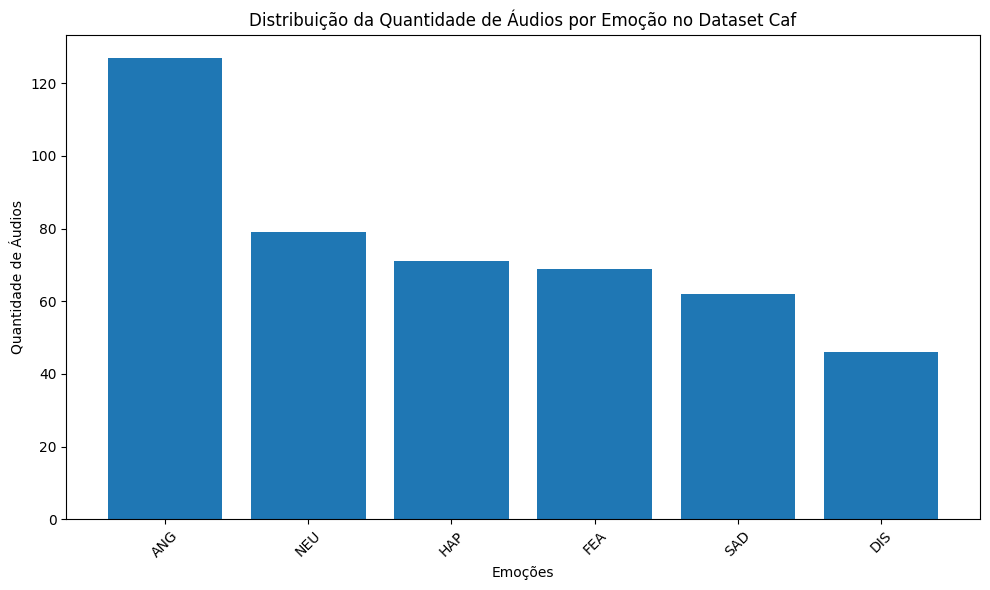

In [ ]:
# Contagem dos rótulos
label_counts = Counter(labels)

# Plotando o gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(label_counts.keys(), label_counts.values())
plt.xlabel('Emoções')
plt.ylabel('Quantidade de Áudios')
plt.title('Distribuição da Quantidade de Áudios por Emoção no Dataset Caf')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
whisper_processor = WhisperProcessor.from_pretrained("openai/whisper-large-v3")
whisper_model = WhisperModel.from_pretrained("openai/whisper-large-v3")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/340 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/283k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.48M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/494k [00:00<?, ?B/s]

normalizer.json:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.07k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.27k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.09G [00:00<?, ?B/s]

In [ ]:
new_dataset = AugmentedCREMADataset(file_paths, encoded_labels, whisper_processor)

In [ ]:
# Definir o batch size
batch_size = 4


test_loader_whisper = DataLoader(
    AugmentedCREMADataset(file_paths, encoded_labels, whisper_processor),
    batch_size=batch_size, shuffle=False, collate_fn=collate_fn, num_workers=0, pin_memory=True
)

In [ ]:
# Inicialize o modelo Whisper com RNN
whisper_rnn_model = WhisperClassifierWithRNN(whisper_model, rnn_type='GRU').to(device)

# Carregue os pesos do arquivo .pt
checkpoint = torch.load('/content/drive/MyDrive/testes_ML/Modelos_treinados/whisper_large4_rnn_model.pt')
whisper_rnn_model.load_state_dict(checkpoint['model_state_dict'])

# Coloque o modelo em modo de avaliação
whisper_rnn_model.eval()

<ipython-input-25-faaedf077481>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('/content/drive/MyDrive/testes_ML/Modelos_treinados/whisper_large4_r

WhisperClassifierWithRNN(
  (whisper): WhisperModel(
    (encoder): WhisperEncoder(
      (conv1): Conv1d(128, 1280, kernel_size=(3,), stride=(1,), padding=(1,))
      (conv2): Conv1d(1280, 1280, kernel_size=(3,), stride=(2,), padding=(1,))
      (embed_positions): Embedding(1500, 1280)
      (layers): ModuleList(
        (0-31): 32 x WhisperEncoderLayer(
          (self_attn): WhisperSdpaAttention(
            (k_proj): Linear(in_features=1280, out_features=1280, bias=False)
            (v_proj): Linear(in_features=1280, out_features=1280, bias=True)
            (q_proj): Linear(in_features=1280, out_features=1280, bias=True)
            (out_proj): Linear(in_features=1280, out_features=1280, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=1280, out_features=5120, bias=True)
          (fc2): Linear(in_features=5120, out_features=1280, bias=Tru

Valores únicos em all_labels: [0 1 2 3 4 5]
Valores únicos em all_preds: [0 1 2 3 4 5]

Classification Report:
              precision    recall  f1-score   support

         ANG       0.85      0.30      0.45       254
         DIS       0.94      0.16      0.28        92
         FEA       0.22      1.00      0.36       138
         HAP       0.61      0.50      0.55       142
         NEU       1.00      0.03      0.05       158
         SAD       0.85      0.37      0.52       124

    accuracy                           0.39       908
   macro avg       0.74      0.39      0.37       908
weighted avg       0.75      0.39      0.37       908



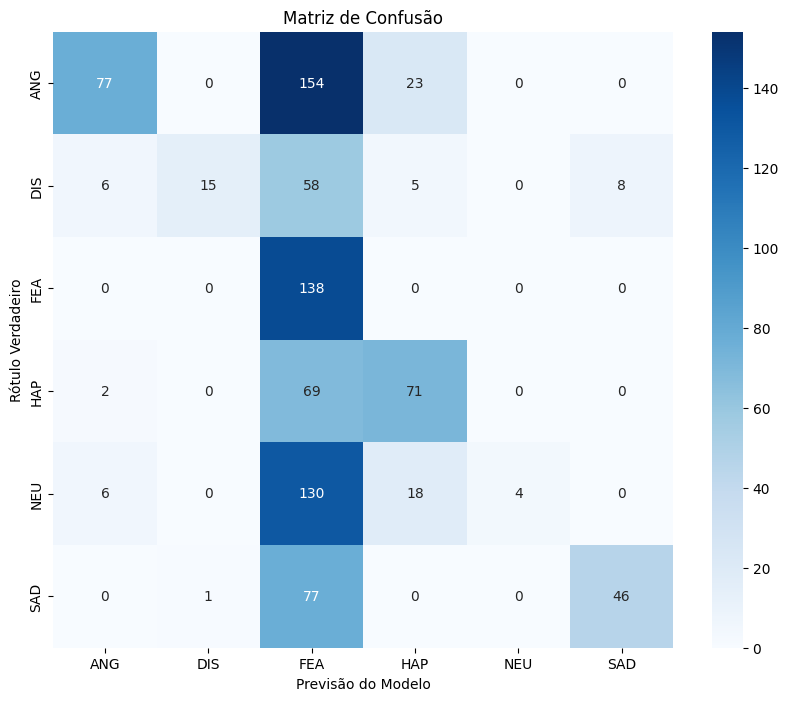

Accuracy: 0.3866
Accuracy on New Dataset: 0.3866


In [ ]:
new_dataset_accuracy = evaluate_model_whisper(whisper_rnn_model, test_loader_whisper, label_encoder)
print(f"Accuracy on New Dataset: {new_dataset_accuracy:.4f}")

### TESS

Número total de arquivos de áudio: 2400
Duração máxima: 2.98 segundos
Duração média: 2.06 segundos
Duração mínima: 1.25 segundos


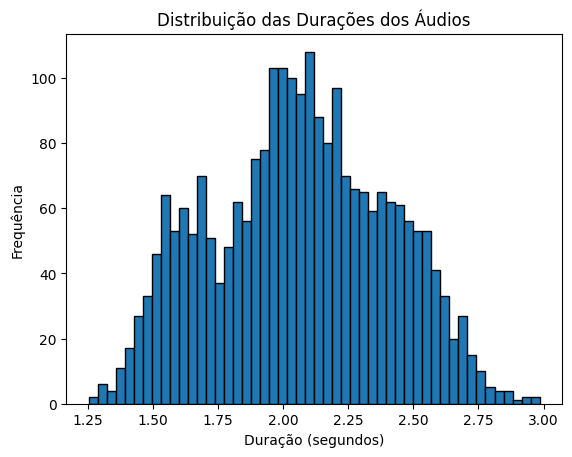

In [ ]:
def analyze_audio_durations(folder_path, sample_rate=16000):
    max_duration = 0.0
    total_duration = 0.0
    durations = []
    file_count = 0

    # Percorrer todos os arquivos na pasta especificada
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith('.wav'):  # Considere apenas arquivos WAV (ajuste conforme necessário)
                file_path = os.path.join(root, file)
                waveform, sr = torchaudio.load(file_path)
                if sr != sample_rate:
                    # Opcional: Resample para a taxa de amostragem desejada
                    resampler = torchaudio.transforms.Resample(orig_freq=sr, new_freq=sample_rate)
                    waveform = resampler(waveform)
                    sr = sample_rate
                # Calcular a duração em segundos
                duration = waveform.shape[1] / sr
                durations.append(duration)
                total_duration += duration
                file_count += 1
                if duration > max_duration:
                    max_duration = duration

    if file_count == 0:
        print("Nenhum arquivo de áudio encontrado na pasta especificada.")
        return

    average_duration = total_duration / file_count
    print(f"Número total de arquivos de áudio: {file_count}")
    print(f"Duração máxima: {max_duration:.2f} segundos")
    print(f"Duração média: {average_duration:.2f} segundos")
    print(f"Duração mínima: {min(durations):.2f} segundos")

    # Opcional: Exibir um histograma das durações
    import matplotlib.pyplot as plt
    plt.hist(durations, bins=50, edgecolor='black')
    plt.xlabel('Duração (segundos)')
    plt.ylabel('Frequência')
    plt.title('Distribuição das Durações dos Áudios')
    plt.show()

# Exemplo de uso:
folder_path = '/content/drive/MyDrive/testes_ML/TESS'  # Substitua pelo caminho da sua pasta
analyze_audio_durations(folder_path)

In [ ]:
# Classe Dataset com aumento de dados "on-the-fly"
class AugmentedCREMADataset(Dataset):
    def __init__(self, file_paths, labels, processor, sample_rate=16000):
        self.file_paths = file_paths
        self.labels = labels
        self.processor = processor  # Pode ser removido se não for usado
        self.sample_rate = sample_rate

    def __len__(self):
        # Retorna o dobro do tamanho para incluir dados originais e aumentados
        return len(self.file_paths) * 2

    def __getitem__(self, idx):
        if idx < len(self.file_paths):
            # Dados originais
            file_path = self.file_paths[idx]
            label = self.labels[idx]

            # Carregar áudio
            waveform, sr = torchaudio.load(file_path)
            if sr != self.sample_rate:
                waveform = torchaudio.transforms.Resample(orig_freq=sr, new_freq=self.sample_rate)(waveform)

            waveform = waveform.squeeze(0)  # Remove a dimensão extra (mono)

            # Retorna o waveform bruto e o label
            return waveform, label
        else:
            # Dados aumentados
            idx = idx - len(self.file_paths)
            file_path = self.file_paths[idx]
            label = self.labels[idx]

            # Carregar áudio
            waveform, sr = torchaudio.load(file_path)
            if sr != self.sample_rate:
                waveform = torchaudio.transforms.Resample(orig_freq=sr, new_freq=self.sample_rate)(waveform)

            waveform = waveform.squeeze(0)  # Remove a dimensão extra (mono)

            # Aplicar aumento de dados
            waveform = self.apply_random_augmentation(waveform, self.sample_rate)

            # Retorna o waveform aumentado e o label
            return waveform, label

    def apply_random_augmentation(self, waveform, sample_rate):
        # Escolha aleatória de uma técnica de aumento
        augmentation_methods = ['pitch_shift', 'add_noise', 'add_reverb', 'insert_silence']
        augmentation = random.choice(augmentation_methods)

        if augmentation == 'pitch_shift':
            n_steps = random.choice([-2, -1, 1, 2])  # Deslocamento de pitch
            augmented_waveform = pitch_shift(waveform.unsqueeze(0), sample_rate, n_steps).squeeze(0)
        elif augmentation == 'add_noise':
            noise_factor = random.uniform(0.001, 0.01)
            augmented_waveform = add_noise(waveform, noise_factor)
        elif augmentation == 'add_reverb':
            augmented_waveform = add_reverb(waveform.unsqueeze(0), sample_rate).squeeze(0)
        elif augmentation == 'insert_silence':
            max_silence_length = 0.5  # Em segundos
            augmented_waveform = insert_silence(waveform.unsqueeze(0), sample_rate, max_silence_length).squeeze(0)
        else:
            augmented_waveform = waveform  # Nenhuma alteração

        return augmented_waveform

In [ ]:
def evaluate_model_whisper(model, test_loader, label_encoder):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            # Movendo dados para o dispositivo (CPU ou GPU)
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass através do modelo
            logits = model(inputs)
            preds = torch.argmax(logits, dim=1)

            # Armazenando os resultados
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # **Libere a memória aqui**
            del inputs, labels, logits, preds  # Remover variáveis desnecessárias
            gc.collect()  # Forçar a coleta de lixo para liberar memória

    # Calcular a acurácia
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"Accuracy: {accuracy:.4f}")

    # Gerar relatório de classificação
    target_names = label_encoder.classes_
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=target_names))

    # Calcular a matriz de confusão
    cm = confusion_matrix(all_labels, all_preds)

    # Plotar a matriz de confusão
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=target_names,
                yticklabels=target_names)
    plt.ylabel('Rótulo Verdadeiro')
    plt.xlabel('Previsão do Modelo')
    plt.title('Matriz de Confusão')
    plt.show()

    return accuracy

In [ ]:
# Definir o classificador baseado no Whisper com RNN
class WhisperClassifierWithRNN(nn.Module):
    def __init__(self, whisper_model, hidden_size=256, rnn_type='GRU'):
        super(WhisperClassifierWithRNN, self).__init__()
        self.whisper = whisper_model
        self.hidden_size = hidden_size

        # Use either LSTM or GRU based on rnn_type parameter
        if rnn_type == 'GRU':
            self.rnn = nn.GRU(input_size=whisper_model.config.d_model, hidden_size=hidden_size, batch_first=True)
        else:
            self.rnn = nn.LSTM(input_size=whisper_model.config.d_model, hidden_size=hidden_size, batch_first=True)

        # Classificador com uma camada linear simples
        self.classifier = nn.Linear(hidden_size, 6)

    def forward(self, input_features):
        with torch.no_grad():
            # Use apenas o encoder do modelo Whisper
            encoder_outputs = self.whisper.encoder(input_features)
            hidden_states = encoder_outputs.last_hidden_state  # Shape: [batch_size, seq_len, hidden_size]

        # Passar pelo RNN (LSTM ou GRU)
        rnn_output, _ = self.rnn(hidden_states)  # Shape: [batch_size, seq_len, hidden_size]

        # Agregar tirando a média ao longo do comprimento da sequência
        rnn_output = rnn_output.mean(dim=1)  # Shape: [batch_size, hidden_size]

        # Classificar usando a camada linear
        logits = self.classifier(rnn_output)
        return logits

In [ ]:
def collate_fn(batch):
    waveforms = [item[0] for item in batch]  # Lista de tensores PyTorch
    labels = [item[1] for item in batch]

    # Converter os waveforms para listas de numpy arrays
    waveforms = [waveform.numpy() for waveform in waveforms]

    # Padronizar as formas de onda para o mesmo comprimento
    max_length = max(len(waveform) for waveform in waveforms)
    padded_waveforms = [
        np.pad(waveform, (0, max_length - len(waveform)), 'constant') if len(waveform) < max_length else waveform
        for waveform in waveforms
    ]

    # Processar usando o WhisperProcessor
    inputs = whisper_processor(
        padded_waveforms,
        sampling_rate=16000,
        return_tensors="pt",
        padding=True
    )

    if 'input_features' in inputs:
        input_features = inputs['input_features']
    else:
        raise AttributeError("O WhisperProcessor não gerou 'input_features'. Verifique se os dados de entrada estão corretos.")

    # Padronizar as input features para comprimento 3000 na dimensão temporal
    processed_inputs = []
    for feature in input_features:
        seq_len = feature.shape[1]
        if seq_len < 3000:
            # Pad com zeros até atingir 3000 frames
            pad_length = 3000 - seq_len
            padded_feature = torch.nn.functional.pad(feature, (0, pad_length), "constant", 0)
        elif seq_len > 3000:
            # Truncar para 3000 frames
            padded_feature = feature[:, :3000]
        else:
            padded_feature = feature  # Já tem comprimento 3000
        processed_inputs.append(padded_feature)

    # Empilhar as input features padronizadas
    processed_inputs = torch.stack(processed_inputs)

    # Verificar que as input features agora têm comprimento 3000
    labels = torch.tensor(labels)

    return processed_inputs, labels

In [ ]:
def load_tess_data(data_dir):
    file_paths = []
    labels = []
    # Padrão de nome de arquivo esperado (ajuste conforme necessário)
    pattern = re.compile(r'(\w+)_(\w+)_(\w+)_.*\.wav$')

    for file_name in os.listdir(data_dir):
        if file_name.endswith(".wav"):
            match = pattern.match(file_name)
            if match:
                # Extraia o terceiro grupo como rótulo
                label = match.group(3)
                file_paths.append(os.path.join(data_dir, file_name))
                labels.append(label)
            else:
                print(f"Aviso: O arquivo '{file_name}' não corresponde ao padrão esperado e será ignorado.")
    return file_paths, labels

data_dir = "/content/drive/MyDrive/testes_ML/TESS"
file_paths, labels = load_tess_data(data_dir)

# Codificar os rótulos
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

print(f"Número de arquivos de áudio: {len(file_paths)}")
print(f"Número de rótulos: {len(encoded_labels)}")

Número de arquivos de áudio: 2400
Número de rótulos: 2400


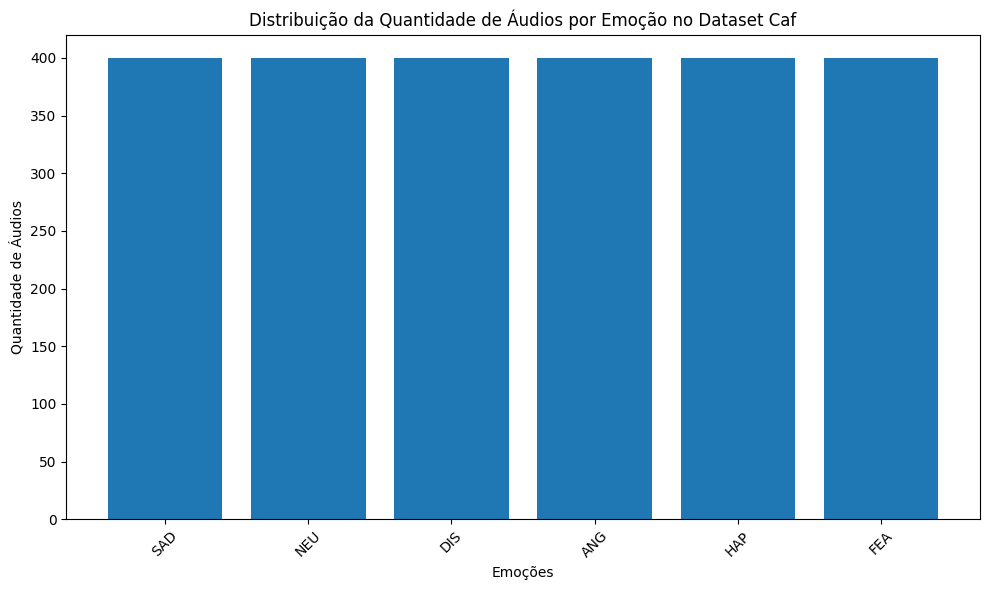

In [ ]:
# Contagem dos rótulos
label_counts = Counter(labels)

# Plotando o gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(label_counts.keys(), label_counts.values())
plt.xlabel('Emoções')
plt.ylabel('Quantidade de Áudios')
plt.title('Distribuição da Quantidade de Áudios por Emoção no Dataset Caf')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
whisper_processor = WhisperProcessor.from_pretrained("openai/whisper-base")
whisper_model = WhisperModel.from_pretrained("openai/whisper-base")

In [ ]:
new_dataset = AugmentedCREMADataset(file_paths, encoded_labels, whisper_processor)

In [ ]:
# Definir o batch size
batch_size = 128


test_loader_whisper = DataLoader(
    AugmentedCREMADataset(file_paths, encoded_labels, whisper_processor),
    batch_size=batch_size, shuffle=False, collate_fn=collate_fn, num_workers=0, pin_memory=True
)

In [ ]:
# Inicialize o modelo Whisper com RNN
whisper_rnn_model = WhisperClassifierWithRNN(whisper_model, rnn_type='GRU').to(device)

# Carregue os pesos do arquivo .pt
checkpoint = torch.load('/content/drive/MyDrive/testes_ML/Modelos_treinados/whisper_base5_rnn_model.pt')
whisper_rnn_model.load_state_dict(checkpoint['model_state_dict'])

# Coloque o modelo em modo de avaliação
whisper_rnn_model.eval()

<ipython-input-39-9236c6c8dffd>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('/content/drive/MyDrive/testes_ML/Modelos_treinados/whisper_base5_rn

WhisperClassifierWithRNN(
  (whisper): WhisperModel(
    (encoder): WhisperEncoder(
      (conv1): Conv1d(80, 512, kernel_size=(3,), stride=(1,), padding=(1,))
      (conv2): Conv1d(512, 512, kernel_size=(3,), stride=(2,), padding=(1,))
      (embed_positions): Embedding(1500, 512)
      (layers): ModuleList(
        (0-5): 6 x WhisperEncoderLayer(
          (self_attn): WhisperSdpaAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=False)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=512, out_features=2048, bias=True)
          (fc2): Linear(in_features=2048, out_features=512, bias=True)
          (fina

Accuracy: 0.7758

Classification Report:
              precision    recall  f1-score   support

         ANG       0.84      0.79      0.82       800
         DIS       0.57      0.95      0.71       800
         FEA       0.87      0.98      0.92       800
         HAP       0.77      0.42      0.55       800
         NEU       0.96      0.79      0.86       800
         SAD       0.82      0.73      0.77       800

    accuracy                           0.78      4800
   macro avg       0.80      0.78      0.77      4800
weighted avg       0.80      0.78      0.77      4800



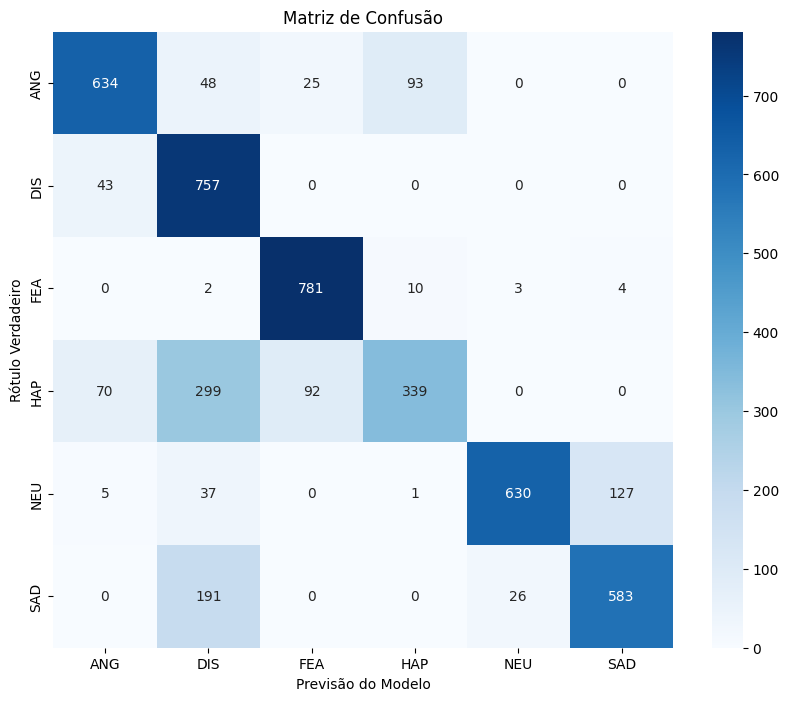

Accuracy on New Dataset: 0.7758


In [ ]:
new_dataset_accuracy = evaluate_model_whisper(whisper_rnn_model, test_loader_whisper, label_encoder)
print(f"Accuracy on New Dataset: {new_dataset_accuracy:.4f}")

In [ ]:
def predict_emotion_for_file(model, processor, file_path, label_encoder, sample_rate=16000, max_seq_len=3000):
    """
    Realiza a inferência de emoção para um único arquivo de áudio.

    Args:
        model: Modelo treinado.
        processor: WhisperProcessor para processar os dados.
        file_path: Caminho do arquivo .wav.
        label_encoder: LabelEncoder usado para decodificar os rótulos.
        sample_rate: Taxa de amostragem usada no treinamento do modelo.
        max_seq_len: Comprimento esperado para as input_features.

    Returns:
        Predição do rótulo da emoção.
    """
    # Carregar o áudio
    waveform, sr = torchaudio.load(file_path)

    # Resample se necessário
    if sr != sample_rate:
        waveform = torchaudio.transforms.Resample(orig_freq=sr, new_freq=sample_rate)(waveform)

    # Remover a dimensão extra (mono)
    waveform = waveform.squeeze(0).numpy()

    # Processar o waveform usando o WhisperProcessor
    inputs = processor(
        [waveform],
        sampling_rate=sample_rate,
        return_tensors="pt",
        padding=True
    )

    if 'input_features' not in inputs:
        raise ValueError("Erro no processamento do WhisperProcessor. 'input_features' não foi gerado.")

    input_features = inputs['input_features']

    # Ajustar o comprimento das input_features para 3000 frames
    processed_inputs = []
    for feature in input_features:
        seq_len = feature.shape[1]
        if seq_len < max_seq_len:
            # Pad com zeros até atingir 3000 frames
            pad_length = max_seq_len - seq_len
            padded_feature = torch.nn.functional.pad(feature, (0, pad_length), "constant", 0)
        elif seq_len > max_seq_len:
            # Truncar para 3000 frames
            padded_feature = feature[:, :max_seq_len]
        else:
            padded_feature = feature  # Já tem comprimento 3000
        processed_inputs.append(padded_feature)

    # Empilhar as input features padronizadas
    processed_inputs = torch.stack(processed_inputs).to(device)

    # Colocar o modelo em modo de avaliação
    model.eval()
    with torch.no_grad():
        logits = model(processed_inputs)
        pred_idx = torch.argmax(logits, dim=1).item()

    # Decodificar o índice do rótulo para o nome da emoção
    emotion = label_encoder.inverse_transform([pred_idx])[0]

    return emotion




# Caminho do arquivo de teste
file_path = "/content/drive/MyDrive/testes_ML/Modelos_treinados/tess-2400-sad-xx_KWFSFoHK.wav"

# Fazer a inferência
predicted_emotion = predict_emotion_for_file(
    model=whisper_rnn_model,
    processor=whisper_processor,
    file_path=file_path,
    label_encoder=label_encoder
)

print(f"A emoção prevista para o arquivo '{file_path}' é: {predicted_emotion}")


A emoção prevista para o arquivo '/content/drive/MyDrive/testes_ML/Modelos_treinados/tess-2400-sad-xx_KWFSFoHK.wav' é: SAD


In [ ]:
import os
!apt-get install ffmpeg -y
!pip install pydub

from pydub import AudioSegment

def extend_audio_to_duration(input_folder, output_folder, target_duration=5000):
    """
    Duplica áudios na pasta até atingir o comprimento alvo.

    Args:
        input_folder (str): Caminho da pasta com os arquivos de áudio originais.
        output_folder (str): Caminho da pasta para salvar os arquivos ajustados.
        target_duration (int): Duração alvo em milissegundos (padrão: 5000 ms = 5 segundos).
    """
    # Verifica se a pasta de saída existe, caso contrário cria
    os.makedirs(output_folder, exist_ok=True)

    # Lista os arquivos de áudio na pasta
    audio_files = [f for f in os.listdir(input_folder) if f.endswith('.wav')]

    if not audio_files:
        print("Nenhum arquivo .wav encontrado na pasta.")
        return

    print(f"Processando {len(audio_files)} arquivos...")

    for file in audio_files:
        file_path = os.path.join(input_folder, file)
        output_path = os.path.join(output_folder, file)

        print(f"Processando: {file_path}")

        # Carregar o áudio
        audio = AudioSegment.from_wav(file_path)

        # Calcular quantas vezes repetir o áudio para atingir a duração alvo
        repetitions = target_duration // len(audio) + 1

        # Repetir e cortar o áudio para atingir exatamente o target_duration
        extended_audio = (audio * repetitions)[:target_duration]

        # Salvar o áudio ajustado
        extended_audio.export(output_path, format="wav")
        print(f"Salvo: {output_path}")

# Caminho da pasta de entrada (com os arquivos .wav)
input_folder = "/content/drive/MyDrive/testes_ML/CremaD"

# Caminho da pasta de saída (para os arquivos ajustados)
output_folder = "/content/drive/MyDrive/testes_ML/CremaD2"

# Executar o programa
extend_audio_to_duration(input_folder, output_folder)

A saída de streaming foi truncada nas últimas 5000 linhas.
Processando: /content/drive/MyDrive/testes_ML/CremaD/1042_MTI_SAD_XX.wav
Salvo: /content/drive/MyDrive/testes_ML/CremaD2/1042_MTI_SAD_XX.wav
Processando: /content/drive/MyDrive/testes_ML/CremaD/1042_IWW_NEU_XX.wav
Salvo: /content/drive/MyDrive/testes_ML/CremaD2/1042_IWW_NEU_XX.wav
Processando: /content/drive/MyDrive/testes_ML/CremaD/1042_IWW_ANG_XX.wav
Salvo: /content/drive/MyDrive/testes_ML/CremaD2/1042_IWW_ANG_XX.wav
Processando: /content/drive/MyDrive/testes_ML/CremaD/1042_IWL_ANG_XX.wav
Salvo: /content/drive/MyDrive/testes_ML/CremaD2/1042_IWL_ANG_XX.wav
Processando: /content/drive/MyDrive/testes_ML/CremaD/1042_TAI_NEU_XX.wav
Salvo: /content/drive/MyDrive/testes_ML/CremaD2/1042_TAI_NEU_XX.wav
Processando: /content/drive/MyDrive/testes_ML/CremaD/1042_IWW_SAD_XX.wav
Salvo: /content/drive/MyDrive/testes_ML/CremaD2/1042_IWW_SAD_XX.wav
Processando: /content/drive/MyDrive/testes_ML/CremaD/1042_IWW_HAP_XX.wav
Salvo: /content/drive/

### Ravdess

Número total de arquivos de áudio: 1056
Duração máxima: 5.27 segundos
Duração média: 3.72 segundos
Duração mínima: 3.07 segundos


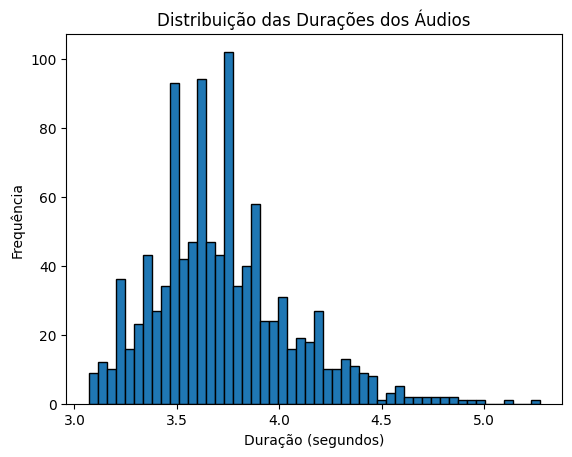

In [ ]:
def analyze_audio_durations(folder_path, sample_rate=16000):
    max_duration = 0.0
    total_duration = 0.0
    durations = []
    file_count = 0

    # Percorrer todos os arquivos na pasta especificada
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith('.wav'):  # Considere apenas arquivos WAV (ajuste conforme necessário)
                file_path = os.path.join(root, file)
                waveform, sr = torchaudio.load(file_path)
                if sr != sample_rate:
                    # Opcional: Resample para a taxa de amostragem desejada
                    resampler = torchaudio.transforms.Resample(orig_freq=sr, new_freq=sample_rate)
                    waveform = resampler(waveform)
                    sr = sample_rate
                # Calcular a duração em segundos
                duration = waveform.shape[1] / sr
                durations.append(duration)
                total_duration += duration
                file_count += 1
                if duration > max_duration:
                    max_duration = duration

    if file_count == 0:
        print("Nenhum arquivo de áudio encontrado na pasta especificada.")
        return

    average_duration = total_duration / file_count
    print(f"Número total de arquivos de áudio: {file_count}")
    print(f"Duração máxima: {max_duration:.2f} segundos")
    print(f"Duração média: {average_duration:.2f} segundos")
    print(f"Duração mínima: {min(durations):.2f} segundos")

    # Opcional: Exibir um histograma das durações
    import matplotlib.pyplot as plt
    plt.hist(durations, bins=50, edgecolor='black')
    plt.xlabel('Duração (segundos)')
    plt.ylabel('Frequência')
    plt.title('Distribuição das Durações dos Áudios')
    plt.show()

# Exemplo de uso:
folder_path = '/content/drive/MyDrive/testes_ML/RAVDESS'  # Substitua pelo caminho da sua pasta
analyze_audio_durations(folder_path)

In [ ]:
# Classe Dataset com aumento de dados "on-the-fly"
class AugmentedCREMADataset(Dataset):
    def __init__(self, file_paths, labels, processor, sample_rate=16000):
        self.file_paths = file_paths
        self.labels = labels
        self.processor = processor  # Pode ser removido se não for usado
        self.sample_rate = sample_rate

    def __len__(self):
        # Retorna o dobro do tamanho para incluir dados originais e aumentados
        return len(self.file_paths) * 2

    def __getitem__(self, idx):
        if idx < len(self.file_paths):
            # Dados originais
            file_path = self.file_paths[idx]
            label = self.labels[idx]

            # Carregar áudio
            waveform, sr = torchaudio.load(file_path)
            if sr != self.sample_rate:
                waveform = torchaudio.transforms.Resample(orig_freq=sr, new_freq=self.sample_rate)(waveform)

            waveform = waveform.squeeze(0)  # Remove a dimensão extra (mono)

            # Retorna o waveform bruto e o label
            return waveform, label
        else:
            # Dados aumentados
            idx = idx - len(self.file_paths)
            file_path = self.file_paths[idx]
            label = self.labels[idx]

            # Carregar áudio
            waveform, sr = torchaudio.load(file_path)
            if sr != self.sample_rate:
                waveform = torchaudio.transforms.Resample(orig_freq=sr, new_freq=self.sample_rate)(waveform)

            waveform = waveform.squeeze(0)  # Remove a dimensão extra (mono)

            # Aplicar aumento de dados
            waveform = self.apply_random_augmentation(waveform, self.sample_rate)

            # Retorna o waveform aumentado e o label
            return waveform, label

    def apply_random_augmentation(self, waveform, sample_rate):
        # Escolha aleatória de uma técnica de aumento
        augmentation_methods = ['pitch_shift', 'add_noise', 'add_reverb', 'insert_silence']
        augmentation = random.choice(augmentation_methods)

        if augmentation == 'pitch_shift':
            n_steps = random.choice([-2, -1, 1, 2])  # Deslocamento de pitch
            augmented_waveform = pitch_shift(waveform.unsqueeze(0), sample_rate, n_steps).squeeze(0)
        elif augmentation == 'add_noise':
            noise_factor = random.uniform(0.001, 0.01)
            augmented_waveform = add_noise(waveform, noise_factor)
        elif augmentation == 'add_reverb':
            augmented_waveform = add_reverb(waveform.unsqueeze(0), sample_rate).squeeze(0)
        elif augmentation == 'insert_silence':
            max_silence_length = 0.5  # Em segundos
            augmented_waveform = insert_silence(waveform.unsqueeze(0), sample_rate, max_silence_length).squeeze(0)
        else:
            augmented_waveform = waveform  # Nenhuma alteração

        return augmented_waveform

In [ ]:
def evaluate_model_whisper(model, test_loader, label_encoder):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            # Movendo dados para o dispositivo (CPU ou GPU)
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass através do modelo
            logits = model(inputs)
            preds = torch.argmax(logits, dim=1)

            # Armazenando os resultados
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # **Libere a memória aqui**
            del inputs, labels, logits, preds  # Remover variáveis desnecessárias
            gc.collect()  # Forçar a coleta de lixo para liberar memória

    # Calcular a acurácia
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"Accuracy: {accuracy:.4f}")

    # Gerar relatório de classificação
    target_names = label_encoder.classes_
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=target_names))

    # Calcular a matriz de confusão
    cm = confusion_matrix(all_labels, all_preds)

    # Plotar a matriz de confusão
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=target_names,
                yticklabels=target_names)
    plt.ylabel('Rótulo Verdadeiro')
    plt.xlabel('Previsão do Modelo')
    plt.title('Matriz de Confusão')
    plt.show()

    return accuracy

In [ ]:
# Definir o classificador baseado no Whisper com RNN
class WhisperClassifierWithRNN(nn.Module):
    def __init__(self, whisper_model, hidden_size=256, rnn_type='GRU'):
        super(WhisperClassifierWithRNN, self).__init__()
        self.whisper = whisper_model
        self.hidden_size = hidden_size

        # Use either LSTM or GRU based on rnn_type parameter
        if rnn_type == 'GRU':
            self.rnn = nn.GRU(input_size=whisper_model.config.d_model, hidden_size=hidden_size, batch_first=True)
        else:
            self.rnn = nn.LSTM(input_size=whisper_model.config.d_model, hidden_size=hidden_size, batch_first=True)

        # Classificador com uma camada linear simples
        self.classifier = nn.Linear(hidden_size, 6)

    def forward(self, input_features):
        with torch.no_grad():
            # Use apenas o encoder do modelo Whisper
            encoder_outputs = self.whisper.encoder(input_features)
            hidden_states = encoder_outputs.last_hidden_state  # Shape: [batch_size, seq_len, hidden_size]

        # Passar pelo RNN (LSTM ou GRU)
        rnn_output, _ = self.rnn(hidden_states)  # Shape: [batch_size, seq_len, hidden_size]

        # Agregar tirando a média ao longo do comprimento da sequência
        rnn_output = rnn_output.mean(dim=1)  # Shape: [batch_size, hidden_size]

        # Classificar usando a camada linear
        logits = self.classifier(rnn_output)
        return logits

In [ ]:
def collate_fn(batch):
    waveforms = [item[0] for item in batch]  # Lista de tensores PyTorch
    labels = [item[1] for item in batch]

    # Converter os waveforms para listas de numpy arrays
    waveforms = [waveform.numpy() for waveform in waveforms]

    # Padronizar as formas de onda para o mesmo comprimento
    max_length = max(len(waveform) for waveform in waveforms)
    padded_waveforms = [
        np.pad(waveform, (0, max_length - len(waveform)), 'constant') if len(waveform) < max_length else waveform
        for waveform in waveforms
    ]

    # Processar usando o WhisperProcessor
    inputs = whisper_processor(
        padded_waveforms,
        sampling_rate=16000,
        return_tensors="pt",
        padding=True
    )

    if 'input_features' in inputs:
        input_features = inputs['input_features']
    else:
        raise AttributeError("O WhisperProcessor não gerou 'input_features'. Verifique se os dados de entrada estão corretos.")

    # Padronizar as input features para comprimento 3000 na dimensão temporal
    processed_inputs = []
    for feature in input_features:
        seq_len = feature.shape[1]
        if seq_len < 3000:
            # Pad com zeros até atingir 3000 frames
            pad_length = 3000 - seq_len
            padded_feature = torch.nn.functional.pad(feature, (0, pad_length), "constant", 0)
        elif seq_len > 3000:
            # Truncar para 3000 frames
            padded_feature = feature[:, :3000]
        else:
            padded_feature = feature  # Já tem comprimento 3000
        processed_inputs.append(padded_feature)

    # Empilhar as input features padronizadas
    processed_inputs = torch.stack(processed_inputs)

    # Verificar que as input features agora têm comprimento 3000
    labels = torch.tensor(labels)

    return processed_inputs, labels

In [ ]:
def load_RAVDESS_data(data_dir):
    file_paths = []
    labels = []
    # Padrão de nome de arquivo esperado (ajuste conforme necessário)
    pattern = re.compile(r'(\w+)_(\w+)_(\w+)_.*\.wav$')

    for file_name in os.listdir(data_dir):
        if file_name.endswith(".wav"):
            match = pattern.match(file_name)
            if match:
                # Extraia o terceiro grupo como rótulo
                label = match.group(3)
                file_paths.append(os.path.join(data_dir, file_name))
                labels.append(label)
            else:
                print(f"Aviso: O arquivo '{file_name}' não corresponde ao padrão esperado e será ignorado.")
    return file_paths, labels

data_dir = "/content/drive/MyDrive/testes_ML/RAVDESS"
file_paths, labels = load_RAVDESS_data(data_dir)

# Codificar os rótulos
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

print(f"Número de arquivos de áudio: {len(file_paths)}")
print(f"Número de rótulos: {len(encoded_labels)}")

Número de arquivos de áudio: 1056
Número de rótulos: 1056


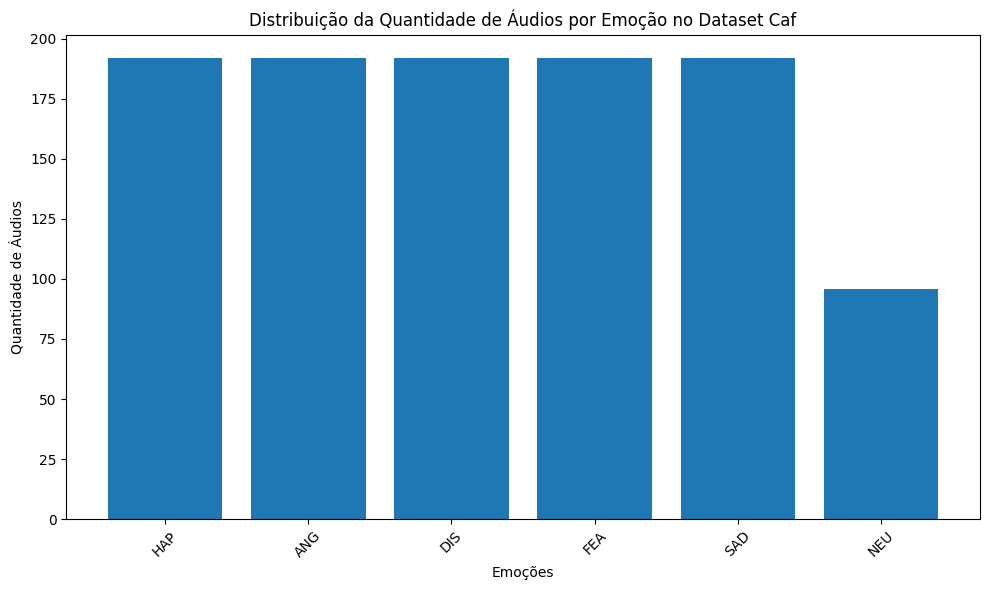

In [ ]:
# Contagem dos rótulos
label_counts = Counter(labels)

# Plotando o gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(label_counts.keys(), label_counts.values())
plt.xlabel('Emoções')
plt.ylabel('Quantidade de Áudios')
plt.title('Distribuição da Quantidade de Áudios por Emoção no Dataset Caf')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
whisper_processor = WhisperProcessor.from_pretrained("openai/whisper-large-v3")
whisper_model = WhisperModel.from_pretrained("openai/whisper-large-v3")

In [ ]:
new_dataset = AugmentedCREMADataset(file_paths, encoded_labels, whisper_processor)

In [ ]:
# Definir o batch size
batch_size = 128


test_loader_whisper = DataLoader(
    AugmentedCREMADataset(file_paths, encoded_labels, whisper_processor),
    batch_size=batch_size, shuffle=False, collate_fn=collate_fn, num_workers=0, pin_memory=True
)

In [ ]:
# Inicialize o modelo Whisper com RNN
whisper_rnn_model = WhisperClassifierWithRNN(whisper_model, rnn_type='GRU').to(device)

# Carregue os pesos do arquivo .pt
checkpoint = torch.load('/content/drive/MyDrive/testes_ML/Modelos_treinados/whisper_large4_rnn_model.pt')
whisper_rnn_model.load_state_dict(checkpoint['model_state_dict'])

# Coloque o modelo em modo de avaliação
whisper_rnn_model.eval()

<ipython-input-36-faaedf077481>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('/content/drive/MyDrive/testes_ML/Modelos_treinados/whisper_large4_r

WhisperClassifierWithRNN(
  (whisper): WhisperModel(
    (encoder): WhisperEncoder(
      (conv1): Conv1d(128, 1280, kernel_size=(3,), stride=(1,), padding=(1,))
      (conv2): Conv1d(1280, 1280, kernel_size=(3,), stride=(2,), padding=(1,))
      (embed_positions): Embedding(1500, 1280)
      (layers): ModuleList(
        (0-31): 32 x WhisperEncoderLayer(
          (self_attn): WhisperSdpaAttention(
            (k_proj): Linear(in_features=1280, out_features=1280, bias=False)
            (v_proj): Linear(in_features=1280, out_features=1280, bias=True)
            (q_proj): Linear(in_features=1280, out_features=1280, bias=True)
            (out_proj): Linear(in_features=1280, out_features=1280, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=1280, out_features=5120, bias=True)
          (fc2): Linear(in_features=5120, out_features=1280, bias=Tru

Accuracy: 0.5185

Classification Report:
              precision    recall  f1-score   support

         ANG       0.93      0.33      0.49       384
         DIS       0.63      0.80      0.71       384
         FEA       0.39      0.96      0.55       384
         HAP       1.00      0.09      0.16       384
         NEU       0.97      0.15      0.26       192
         SAD       0.48      0.60      0.53       384

    accuracy                           0.52      2112
   macro avg       0.73      0.49      0.45      2112
weighted avg       0.71      0.52      0.47      2112



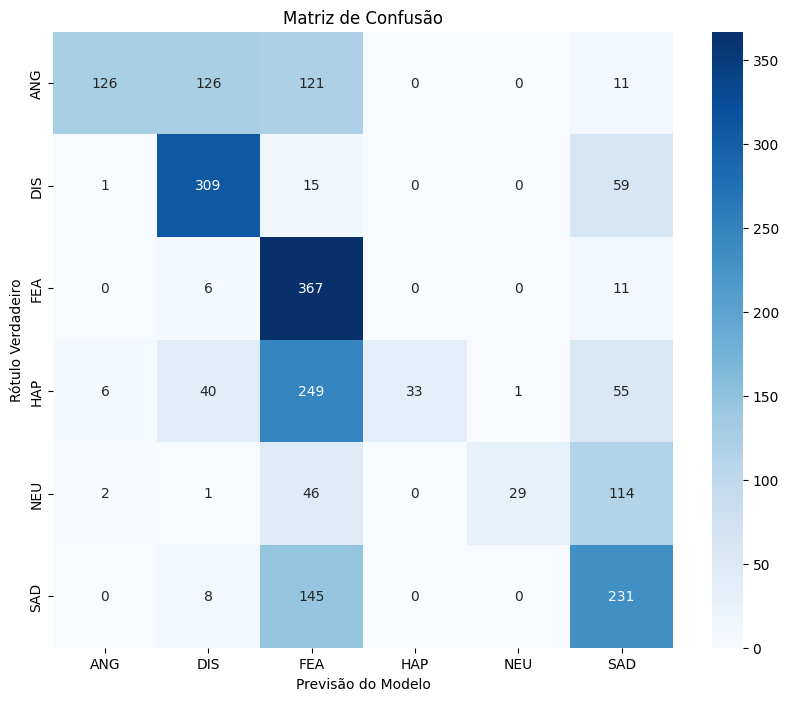

Accuracy on New Dataset: 0.5185


In [ ]:
new_dataset_accuracy = evaluate_model_whisper(whisper_rnn_model, test_loader_whisper, label_encoder)
print(f"Accuracy on New Dataset: {new_dataset_accuracy:.4f}")

### CREMAD

In [ ]:
def analyze_audio_durations(folder_path, sample_rate=16000):
    max_duration = 0.0
    total_duration = 0.0
    durations = []
    file_count = 0

    # Percorrer todos os arquivos na pasta especificada
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith('.wav'):  # Considere apenas arquivos WAV (ajuste conforme necessário)
                file_path = os.path.join(root, file)
                waveform, sr = torchaudio.load(file_path)
                if sr != sample_rate:
                    # Opcional: Resample para a taxa de amostragem desejada
                    resampler = torchaudio.transforms.Resample(orig_freq=sr, new_freq=sample_rate)
                    waveform = resampler(waveform)
                    sr = sample_rate
                # Calcular a duração em segundos
                duration = waveform.shape[1] / sr
                durations.append(duration)
                total_duration += duration
                file_count += 1
                if duration > max_duration:
                    max_duration = duration

    if file_count == 0:
        print("Nenhum arquivo de áudio encontrado na pasta especificada.")
        return

    average_duration = total_duration / file_count
    print(f"Número total de arquivos de áudio: {file_count}")
    print(f"Duração máxima: {max_duration:.2f} segundos")
    print(f"Duração média: {average_duration:.2f} segundos")
    print(f"Duração mínima: {min(durations):.2f} segundos")

    # Opcional: Exibir um histograma das durações
    import matplotlib.pyplot as plt
    plt.hist(durations, bins=50, edgecolor='black')
    plt.xlabel('Duração (segundos)')
    plt.ylabel('Frequência')
    plt.title('Distribuição das Durações dos Áudios')
    plt.show()

# Exemplo de uso:
folder_path = '/content/drive/MyDrive/testes_ML/CremaD'  # Substitua pelo caminho da sua pasta
analyze_audio_durations(folder_path)

## TESTE WAV2VEC superb

In [ ]:
# Classe Dataset com aumento de dados "on-the-fly"
class AugmentedCREMADataset(Dataset):
    def __init__(self, file_paths, labels, processor, sample_rate=16000):
        self.file_paths = file_paths
        self.labels = labels
        self.processor = processor  # Pode ser removido se não for usado
        self.sample_rate = sample_rate

    def __len__(self):
        # Retorna o dobro do tamanho para incluir dados originais e aumentados
        return len(self.file_paths) * 2

    def __getitem__(self, idx):
        if idx < len(self.file_paths):
            # Dados originais
            file_path = self.file_paths[idx]
            label = self.labels[idx]

            # Carregar áudio
            waveform, sr = torchaudio.load(file_path)
            if sr != self.sample_rate:
                waveform = torchaudio.transforms.Resample(orig_freq=sr, new_freq=self.sample_rate)(waveform)

            waveform = waveform.squeeze(0)  # Remove a dimensão extra (mono)

            # Retorna o waveform bruto e o label
            return waveform, label
        else:
            # Dados aumentados
            idx = idx - len(self.file_paths)
            file_path = self.file_paths[idx]
            label = self.labels[idx]

            # Carregar áudio
            waveform, sr = torchaudio.load(file_path)
            if sr != self.sample_rate:
                waveform = torchaudio.transforms.Resample(orig_freq=sr, new_freq=self.sample_rate)(waveform)

            waveform = waveform.squeeze(0)  # Remove a dimensão extra (mono)

            # Aplicar aumento de dados
            waveform = self.apply_random_augmentation(waveform, self.sample_rate)

            # Retorna o waveform aumentado e o label
            return waveform, label

    def apply_random_augmentation(self, waveform, sample_rate):
        # Escolha aleatória de uma técnica de aumento
        augmentation_methods = ['pitch_shift', 'add_noise', 'add_reverb', 'insert_silence']
        augmentation = random.choice(augmentation_methods)

        if augmentation == 'pitch_shift':
            n_steps = random.choice([-2, -1, 1, 2])  # Deslocamento de pitch
            augmented_waveform = pitch_shift(waveform.unsqueeze(0), sample_rate, n_steps).squeeze(0)
        elif augmentation == 'add_noise':
            noise_factor = random.uniform(0.001, 0.01)
            augmented_waveform = add_noise(waveform, noise_factor)
        elif augmentation == 'add_reverb':
            augmented_waveform = add_reverb(waveform.unsqueeze(0), sample_rate).squeeze(0)
        elif augmentation == 'insert_silence':
            max_silence_length = 0.5  # Em segundos
            augmented_waveform = insert_silence(waveform.unsqueeze(0), sample_rate, max_silence_length).squeeze(0)
        else:
            augmented_waveform = waveform  # Nenhuma alteração

        return augmented_waveform

In [ ]:
def evaluate_model_whisper(model, test_loader, label_encoder):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            # Movendo dados para o dispositivo (CPU ou GPU)
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass através do modelo
            logits = model(inputs)
            preds = torch.argmax(logits, dim=1)

            # Armazenando os resultados
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # **Libere a memória aqui**
            del inputs, labels, logits, preds  # Remover variáveis desnecessárias
            gc.collect()  # Forçar a coleta de lixo para liberar memória

    # Calcular a acurácia
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"Accuracy: {accuracy:.4f}")

    # Gerar relatório de classificação
    target_names = label_encoder.classes_
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=target_names))

    # Calcular a matriz de confusão
    cm = confusion_matrix(all_labels, all_preds)

    # Plotar a matriz de confusão
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=target_names,
                yticklabels=target_names)
    plt.ylabel('Rótulo Verdadeiro')
    plt.xlabel('Previsão do Modelo')
    plt.title('Matriz de Confusão')
    plt.show()

    return accuracy

In [ ]:
# Definir o classificador baseado no Whisper com RNN
class WhisperClassifierWithRNN(nn.Module):
    def __init__(self, whisper_model, hidden_size=256, rnn_type='GRU'):
        super(WhisperClassifierWithRNN, self).__init__()
        self.whisper = whisper_model
        self.hidden_size = hidden_size

        # Use either LSTM or GRU based on rnn_type parameter
        if rnn_type == 'GRU':
            self.rnn = nn.GRU(input_size=whisper_model.config.d_model, hidden_size=hidden_size, batch_first=True)
        else:
            self.rnn = nn.LSTM(input_size=whisper_model.config.d_model, hidden_size=hidden_size, batch_first=True)

        # Classificador com uma camada linear simples
        self.classifier = nn.Linear(hidden_size, 6)

    def forward(self, input_features):
        with torch.no_grad():
            # Use apenas o encoder do modelo Whisper
            encoder_outputs = self.whisper.encoder(input_features)
            hidden_states = encoder_outputs.last_hidden_state  # Shape: [batch_size, seq_len, hidden_size]

        # Passar pelo RNN (LSTM ou GRU)
        rnn_output, _ = self.rnn(hidden_states)  # Shape: [batch_size, seq_len, hidden_size]

        # Agregar tirando a média ao longo do comprimento da sequência
        rnn_output = rnn_output.mean(dim=1)  # Shape: [batch_size, hidden_size]

        # Classificar usando a camada linear
        logits = self.classifier(rnn_output)
        return logits

In [ ]:
def collate_fn(batch):
    waveforms = [item[0] for item in batch]  # Lista de tensores PyTorch
    labels = [item[1] for item in batch]

    # Converter os waveforms para listas de numpy arrays
    waveforms = [waveform.numpy() for waveform in waveforms]

    # Padronizar as formas de onda para o mesmo comprimento
    max_length = max(len(waveform) for waveform in waveforms)
    padded_waveforms = [
        np.pad(waveform, (0, max_length - len(waveform)), 'constant') if len(waveform) < max_length else waveform
        for waveform in waveforms
    ]

    # Processar usando o WhisperProcessor
    inputs = whisper_processor(
        padded_waveforms,
        sampling_rate=16000,
        return_tensors="pt",
        padding=True
    )

    if 'input_features' in inputs:
        input_features = inputs['input_features']
    else:
        raise AttributeError("O WhisperProcessor não gerou 'input_features'. Verifique se os dados de entrada estão corretos.")

    # Padronizar as input features para comprimento 3000 na dimensão temporal
    processed_inputs = []
    for feature in input_features:
        seq_len = feature.shape[1]
        if seq_len < 3000:
            # Pad com zeros até atingir 3000 frames
            pad_length = 3000 - seq_len
            padded_feature = torch.nn.functional.pad(feature, (0, pad_length), "constant", 0)
        elif seq_len > 3000:
            # Truncar para 3000 frames
            padded_feature = feature[:, :3000]
        else:
            padded_feature = feature  # Já tem comprimento 3000
        processed_inputs.append(padded_feature)

    # Empilhar as input features padronizadas
    processed_inputs = torch.stack(processed_inputs)

    # Verificar que as input features agora têm comprimento 3000
    labels = torch.tensor(labels)

    return processed_inputs, labels

In [ ]:
def load_RAVDESS_data(data_dir):
    file_paths = []
    labels = []
    # Padrão de nome de arquivo esperado (ajuste conforme necessário)
    pattern = re.compile(r'(\w+)_(\w+)_(\w+)_.*\.wav$')

    for file_name in os.listdir(data_dir):
        if file_name.endswith(".wav"):
            match = pattern.match(file_name)
            if match:
                # Extraia o terceiro grupo como rótulo
                label = match.group(3)
                file_paths.append(os.path.join(data_dir, file_name))
                labels.append(label)
            else:
                print(f"Aviso: O arquivo '{file_name}' não corresponde ao padrão esperado e será ignorado.")
    return file_paths, labels

data_dir = "/content/drive/MyDrive/testes_ML/RAVDESS"
file_paths, labels = load_RAVDESS_data(data_dir)

# Codificar os rótulos
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

print(f"Número de arquivos de áudio: {len(file_paths)}")
print(f"Número de rótulos: {len(encoded_labels)}")

Número de arquivos de áudio: 1056
Número de rótulos: 1056


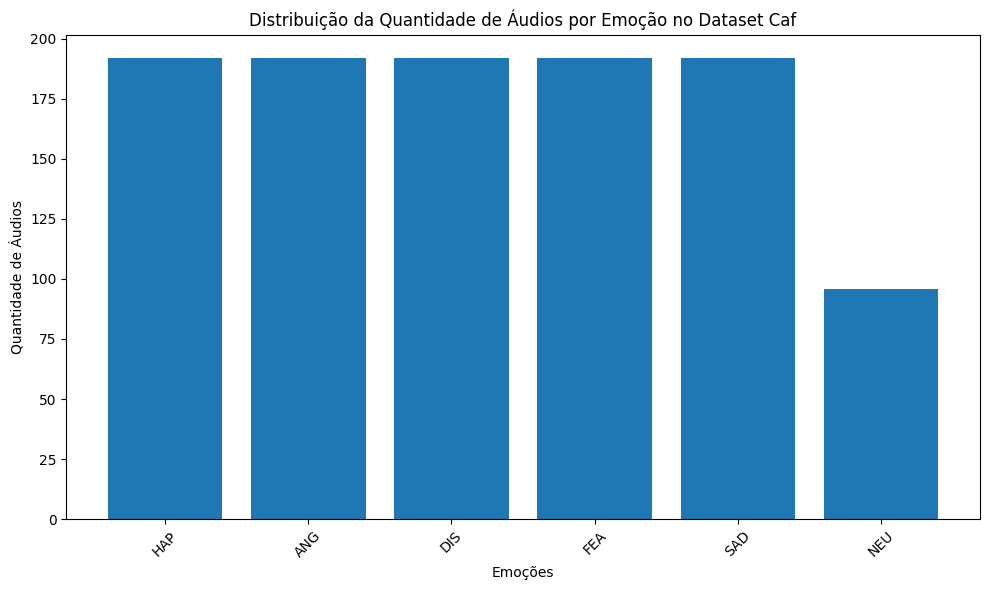

In [ ]:
# Contagem dos rótulos
label_counts = Counter(labels)

# Plotando o gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(label_counts.keys(), label_counts.values())
plt.xlabel('Emoções')
plt.ylabel('Quantidade de Áudios')
plt.title('Distribuição da Quantidade de Áudios por Emoção no Dataset Caf')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
import torch
from transformers import Wav2Vec2Processor, Wav2Vec2ForSequenceClassification
import torchaudio

from transformers import Wav2Vec2FeatureExtractor, Wav2Vec2ForSequenceClassification

# Carregar apenas o feature extractor e o modelo
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("superb/wav2vec2-base-superb-er")
model = Wav2Vec2ForSequenceClassification.from_pretrained("superb/wav2vec2-base-superb-er")

/usr/local/lib/python3.10/dist-packages/transformers/configuration_utils.py:306: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/378M [00:00<?, ?B/s]

In [ ]:
model.to(device)

Wav2Vec2ForSequenceClassification(
  (wav2vec2): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2GroupNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
          (activation): GELUActivation()
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        )
        (1-4): 4 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (5-6): 2 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): Wav2Vec2FeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (projection): Linear(in_features=512, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)



Relatório de Classificação:
              precision    recall  f1-score   support

         ANG       0.03      0.02      0.02       192
         DIS       0.20      0.27      0.23       192
         FEA       0.20      0.70      0.31       192
         HAP       0.00      0.00      0.00       192
         NEU       0.00      0.00      0.00        96
         SAD       0.00      0.00      0.00       192

    accuracy                           0.18      1056
   macro avg       0.07      0.16      0.09      1056
weighted avg       0.08      0.18      0.10      1056



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


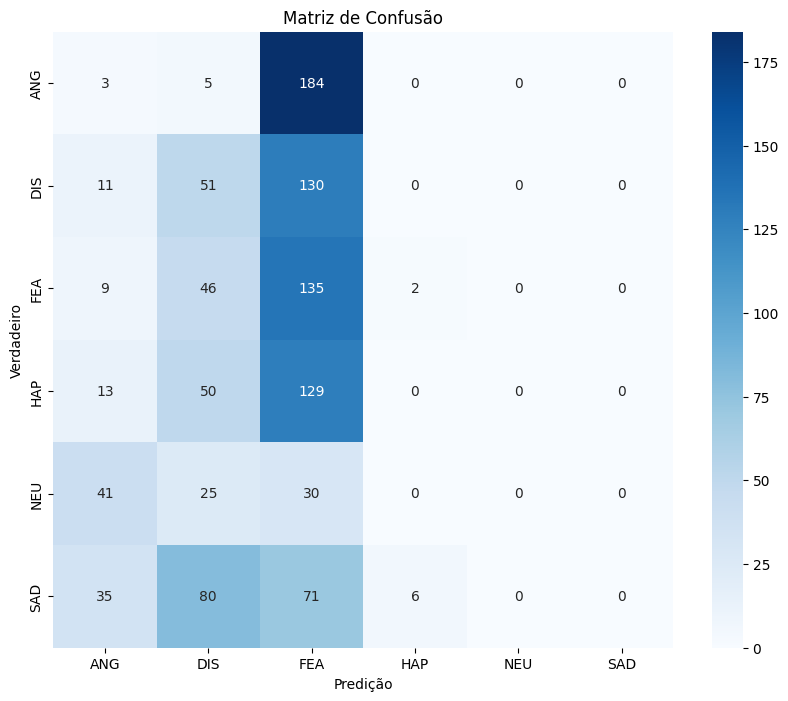


Acurácia Geral: 0.1790
              precision    recall  f1-score   support

         ANG       0.03      0.02      0.02       192
         DIS       0.20      0.27      0.23       192
         FEA       0.20      0.70      0.31       192
         HAP       0.00      0.00      0.00       192
         NEU       0.00      0.00      0.00        96
         SAD       0.00      0.00      0.00       192

    accuracy                           0.18      1056
   macro avg       0.07      0.16      0.09      1056
weighted avg       0.08      0.18      0.10      1056



In [ ]:
# Função para fazer a predição
def predict_emotion(file_path):
    waveform, sample_rate = torchaudio.load(file_path)
    if sample_rate != 16000:
        waveform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)(waveform)
    if waveform.shape[0] > 1:
        waveform = waveform.mean(dim=0, keepdim=True)
    inputs = feature_extractor(waveform.squeeze().numpy(), sampling_rate=16000, return_tensors="pt", padding=True)
    inputs = {key: value.to(device) for key, value in inputs.items()}
    with torch.no_grad():
        logits = model(**inputs).logits
    predicted_class = torch.argmax(logits, dim=-1).item()
    return predicted_class

# Avaliação dos arquivos
predicted_labels = []
for file_path in file_paths:
    predicted_labels.append(predict_emotion(file_path))

# Decodificar rótulos previstos
decoded_predictions = label_encoder.inverse_transform(predicted_labels)

# Relatório de classificação
print("\nRelatório de Classificação:")
print(classification_report(labels, decoded_predictions, target_names=label_encoder.classes_))

# Matriz de Confusão
cm = confusion_matrix(labels, decoded_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Matriz de Confusão")
plt.xlabel("Predição")
plt.ylabel("Verdadeiro")
plt.show()

# Accuracy geral
accuracy = accuracy_score(labels, decoded_predictions)
print(f"\nAcurácia Geral: {accuracy:.4f}")


from sklearn.metrics import classification_report

print(classification_report(labels, decoded_predictions, target_names=label_encoder.classes_, zero_division=0))


Labels ajustados e número de arquivos correspondentes:
sad: 1863 arquivos
ang: 1863 arquivos
hap: 1863 arquivos
neu: 1583 arquivos


preprocessor_config.json:   0%|          | 0.00/214 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.87k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.26G [00:00<?, ?B/s]


Relatório de Classificação:
              precision    recall  f1-score   support

         ang       0.70      0.90      0.79      1863
         hap       0.52      0.63      0.57      1863
         neu       0.55      0.49      0.52      1583
         sad       0.72      0.42      0.53      1863

    accuracy                           0.61      7172
   macro avg       0.62      0.61      0.60      7172
weighted avg       0.62      0.61      0.60      7172



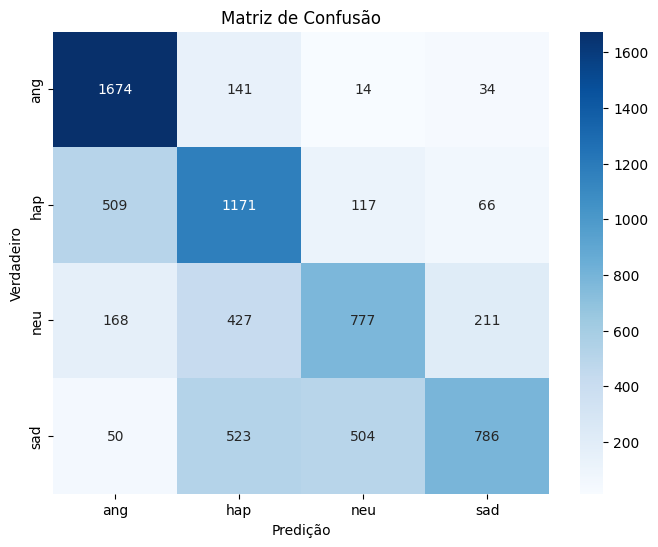


Acurácia Geral: 0.6146


In [ ]:
import os
import re
import torch
import torchaudio
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import Wav2Vec2FeatureExtractor, Wav2Vec2ForSequenceClassification

# Função para carregar os dados
def load_crema_d_data(data_dir):
    file_paths = []
    labels = []
    # Padrão de nome de arquivo esperado (ajuste conforme necessário)
    pattern = re.compile(r'(\w+)_(\w+)_(\w+)_.*\.wav$')

    for file_name in os.listdir(data_dir):
        if file_name.endswith(".wav"):
            match = pattern.match(file_name)
            if match:
                # Extraia o terceiro grupo como rótulo
                label = match.group(3)
                file_paths.append(os.path.join(data_dir, file_name))
                labels.append(label)
            else:
                print(f"Aviso: O arquivo '{file_name}' não corresponde ao padrão esperado e será ignorado.")
    return file_paths, labels

# Caminhos dos diretórios de dados
data_dir_cremaD = "/content/drive/MyDrive/testes_ML/CremaD"
data_dir_ravdess = "/content/drive/MyDrive/testes_ML/RAVDESS"
data_dir_tess = "/content/drive/MyDrive/testes_ML/TESS"

# Carregar os dados
file_paths1, labels1 = load_crema_d_data(data_dir_cremaD)
file_paths2, labels2 = load_crema_d_data(data_dir_ravdess)
file_paths3, labels3 = load_crema_d_data(data_dir_tess)

# Combinar os dados
file_paths = file_paths1 + file_paths2 + file_paths3
labels = labels1 + labels2 + labels3

# Mapeamento de labels do dataset para as classes do modelo
label_mapping = {
    "ANG": "ang",  # Anger
    "DIS": None,   # Disgust (não suportado pelo modelo)
    "FEA": None,   # Fear (não suportado pelo modelo)
    "HAP": "hap",  # Happy
    "NEU": "neu",  # Neutral
    "SAD": "sad"   # Sad
}

# Ajustar os rótulos e filtrar os arquivos
adjusted_file_paths = []
adjusted_labels = []
for file_path, label in zip(file_paths, labels):
    mapped_label = label_mapping.get(label)
    if mapped_label is not None:
        adjusted_file_paths.append(file_path)
        adjusted_labels.append(mapped_label)
    else:
        # Ignorar arquivos com rótulos não suportados
        pass

# Verificar o mapeamento de labels
print("Labels ajustados e número de arquivos correspondentes:")
unique_labels = set(adjusted_labels)
for label in unique_labels:
    count = adjusted_labels.count(label)
    print(f"{label}: {count} arquivos")

# Codificar os rótulos ajustados
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(adjusted_labels)
id2label = {idx: label for idx, label in enumerate(label_encoder.classes_)}

# Carregar o modelo e o feature extractor
model_name = "superb/wav2vec2-large-superb-er"
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(model_name)
model = Wav2Vec2ForSequenceClassification.from_pretrained(model_name)

# Enviar modelo para GPU, se disponível
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Função para fazer a predição
def predict_emotion(file_path):
    waveform, sample_rate = torchaudio.load(file_path)
    if sample_rate != 16000:
        waveform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)(waveform)
    if waveform.shape[0] > 1:
        waveform = waveform.mean(dim=0, keepdim=True)
    inputs = feature_extractor(waveform.squeeze().numpy(), sampling_rate=16000, return_tensors="pt", padding=True)
    inputs = {key: value.to(device) for key, value in inputs.items()}
    with torch.no_grad():
        logits = model(**inputs).logits
    predicted_class = torch.argmax(logits, dim=-1).item()
    predicted_label = model.config.id2label[predicted_class]
    return predicted_label

# Avaliação dos arquivos
predicted_labels = []
for file_path in adjusted_file_paths:
    predicted_label = predict_emotion(file_path)
    predicted_labels.append(predicted_label)

# Gerar relatório de classificação
print("\nRelatório de Classificação:")
print(classification_report(adjusted_labels, predicted_labels, target_names=label_encoder.classes_, zero_division=0))

# Matriz de Confusão
cm = confusion_matrix(adjusted_labels, predicted_labels, labels=label_encoder.classes_)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Matriz de Confusão")
plt.xlabel("Predição")
plt.ylabel("Verdadeiro")
plt.show()

# Acurácia geral
accuracy = accuracy_score(adjusted_labels, predicted_labels)
print(f"\nAcurácia Geral: {accuracy:.4f}")
